# Setup

## Import packages

In [1]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from scipy.stats import zscore
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings, get_cell_filepaths

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def sns_joint_equal_axes(g):
    
    g.ax_joint.set_aspect('equal')
    
    # Get the position of the joint plot and marginal plots
    joint_position = g.ax_joint.get_position()
    xmarg_position = g.ax_marg_x.get_position()
    ymarg_position = g.ax_marg_y.get_position()

    # Set the position and size of the x-axis marginal plot
    g.ax_marg_x.set_position([xmarg_position.x0, joint_position.y1 + 0.02, joint_position.width, xmarg_position.height])

    # Set the position and size of the y-axis marginal plot
    g.ax_marg_y.set_position([ymarg_position.x0, joint_position.y0, ymarg_position.width, joint_position.height])
    
    return g


def pairwise_distances(df, target_ids, dimensions = ['soma_x', 'soma_y_adj', 'soma_z'], source_ids = None, source_coords = None):
    # Extract source coordinates
    if source_ids is not None:
        # source_ids is a tuple of ('column_name',[column_values])
        source_coords = df[df[source_ids[0]].isin(source_ids[1])].loc[:, dimensions].values
    
    # Extract target coordinates
    # target_ids is a tuple of ('column_name',[column_values])
    target_coords = df[df[target_ids[0]].isin(target_ids[1])].loc[:, dimensions].values

    # Handle NaN values
    source_coords = np.nan_to_num(source_coords, nan=np.nan)
    target_coords = np.nan_to_num(target_coords, nan=np.nan)

    # Calculate pairwise distances
    distances = np.linalg.norm(source_coords - target_coords, axis=-1)
    
    return distances

## Import settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [3]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

vx_sizes = [16,16,30]

# Molecular layer fit

In [4]:
from scipy.optimize import curve_fit 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D 

In [5]:
# Define mathematical function for curve fitting 
def func(xy, a, b, c, d, e, f, g, h):  # #h):#
    x, y = xy 
    return a + b*x + c*y + d*x**2 + e*y**2 + f*x**3 + g*y**3 + h*x*y # + h*x*y #

In [6]:
Path(settings_dict['save_dir']).parent.parent

PosixPath('/Users/kperks/Library/CloudStorage/GoogleDrive-kperky@gmail.com/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome')

In [7]:
neuroglancer_path = Path(settings_dict['save_dir']).parent.parent / 'Krista/blender/soma_locations/layer-molecular_annotation.json'
voxel_sizes = [16,16,30]
nl_ = 'molecular'

with open(Path(neuroglancer_path), 'r') as myfile: # 'p' is the dirpath and 'f' is the filename from the created 'd' dictionary
    neuroglancer_data = json.load(myfile)
    
neuroglancer_layer = next((item for item in neuroglancer_data['layers'] if item["name"] == nl_), None)
vertices = [[p['point'][i]*voxel_sizes[i] for i in range(3)] for p in neuroglancer_layer['annotations']]

x_pts = [p[0] for p in vertices]
y_pts = [p[1] for p in vertices]
z_pts = [p[2] for p in vertices]

In [8]:
# Perform curve fitting 
popt, pcov = curve_fit(func, (x_pts, z_pts), y_pts) 
  
# Print optimized parameters 
print(popt) 

[ 2.71956920e+05 -5.43115077e-02 -1.87026179e-01 -3.46153667e-07
  2.31048373e-06  9.59242290e-13 -1.51595014e-11  6.68290149e-07]Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



# Load files

## mg_network file names

In [405]:
dirpath = Path(settings_dict['save_dir'])


In [406]:
nodefiles = get_cell_filepaths(dirpath)

In [407]:
len(nodefiles)

5542

## df_syn pre or post

In [408]:
df_syn = pd.read_csv(dirpath / 'graphs/df_pfsyn.csv')
syn = 'post-synaptic'

In [409]:
len(df_syn)

1000

In [410]:
y_adj_col = []
for i,r in df_syn.iterrows():
    yoffset = func((r['x'], r['z']), *popt)
    y_adj = r['y'] - yoffset#/1000
    y_adj_col.append(y_adj)

df_syn.loc[:,'y_adj']=y_adj_col

In [15]:
# pf_df = deepcopy(df_syn[(df_syn['pre_type'].isin(['pf']))&(df_syn['post_type'].isin(['mg1','mg2','lg','lf']))])
# pf_df['x']=pf_df['x'].apply(lambda x: x/16)
# pf_df['y']=pf_df['y'].apply(lambda x: x/16)
# pf_df['z']=pf_df['z'].apply(lambda x: x/30)

# pf_df.to_csv(Path('/Users/kperks/Downloads/pf_synapses.csv'))

# cell types for all files in directory

## manual type

In [411]:
cell_type = {}
not_typed = []
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    cell_type[int(x)] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        cell_type[int(x)]=np.NaN
        not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
print('the following cells are not typed in the main network')
print(not_typed)        
        
df_type = pd.DataFrame(cell_type.items(),columns = ['id','cell_type'])

df_type.loc[df_type['cell_type'].isin(['dml']),'cell_type']='mli'
df_type.loc[df_type['cell_type'].isin(['grc-d']),'cell_type']='grc'
df_type.loc[df_type['cell_type'].isin(['grc-s']),'cell_type']='smpl'
df_type.loc[df_type['cell_type'].isin(['pfm']),'cell_type']='pf'

the following cells are not typed in the main network
[]


## auto type

this field is populated when an auto-typing of the cells was different from the manual typing

In [412]:
cell_type = {}
# not_typed = []
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    cell_type[int(x)] = cell.get_ctype('auto') 
    if (cell.get_ctype('auto') == []) | (cell.get_ctype('auto') == ''):
        cell_type[int(x)]=np.NaN
        # not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
# print('the following cells are not typed in the main network')
# print(not_typed)        
        
df_type_auto = pd.DataFrame(cell_type.items(),columns = ['id','cell_type'])


In [413]:
df_type_auto.dropna(inplace=True)

In [414]:
df_type_auto.head()

id cell_type
98   127607174       mg2
100  127672247       mg2
148  129572524       mg1
724  213501262       mg1
749  214440956       mg2

## combine manual and auto df_type

In [415]:
for i,r in df_type_auto.iterrows():
    df_type.loc[i,'cell_type'] = r['cell_type'] # the match up of i for df_type and _auto depends on both being made by iterating over the same nodefiles list

In [416]:
# for i,r in df_type.iterrows():
#     df_type.loc[i,'fsize'] = nodefiles[str(r['id'])].stat().st_size

# df_type[df_type['type'].isin(['sg2'])].sort_values('fsize').head(20)

In [417]:
df_type.head()

id cell_type
0  102463116        pf
1  103366246        uk
2  103549879       mli
3  109461049       fov
4  109502641       mli

## add cell type to df_syn

In [418]:
for i,r in df_syn.iterrows():
    try:
        df_syn.loc[i,'pre_type'] =df_type[df_type['id'].isin([r['pre']])].cell_type.values[0]
        df_syn.loc[i,'post_type']=df_type[df_type['id'].isin([r['post']])].cell_type.values[0]
    except:
        print(r['pre'],r['post'])
        continue

In [377]:
# for ctype in ['aff','grc','smpl','sgx1','sgx2','sg1','sg2','mg1','mg2','lg','lf']:#,'uk','tsd']:
    # all_mg = set([int(id_) for id_ in df_type[df_type['type'].isin([ctype])]['id'].values])
    # print(f'{len(all_mg)} {ctype}')

# ctype = 'mg1'
# all_mg = set([int(id_) for id_ in df_type[df_type['type'].isin([ctype])]['id'].values])
# print(f'{len(all_mg)} mg1')

In [220]:
# df_syn.loc[df_syn['post_type'].isin(['dml']),'post_type']='mli'
# df_syn.loc[df_syn['pre_type'].isin(['dml']),'pre_type']='mli'

# df_syn.loc[df_syn['post_type'].isin(['grc-d']),'post_type']='grc'
# df_syn.loc[df_syn['pre_type'].isin(['grc-d']),'pre_type']='grc'

# df_syn.loc[df_syn['post_type'].isin(['grc-s']),'post_type']='smpl'
# df_syn.loc[df_syn['pre_type'].isin(['grc-s']),'pre_type']='smpl'

### --> df_edges

In [221]:
df_syn.head()

Unnamed: 0        pre       post        structure       x      y      z  \
0           0  187230424   40665046  apical dendrite  264418  99130  53925   
1           1  187230424  281055658          unknown  244772  97528  52725   
2           2  187230424  275333062  apical dendrite  246575  97307  56505   
3           3  187230424  386426114  apical dendrite  246084  98728  59325   
4           4  187230424  132342130  apical dendrite  239084  96504  60195   

           y_adj pre_type post_type  
0 -155782.891869       pf       mg2  
1 -157427.907054       pf       fov  
2 -157977.938051       pf       mli  
3 -156823.857077       pf       mg2  
4 -159215.850207       pf       tsd

In [222]:
# remove structure and soma diameter information if want to
# df_syn = df_syn.drop(['Unnamed: 0','x','y','z','structure'],axis=1)#,'pre_diam','post_diam','diam_diff'],axis=1) # 

In [419]:
df_edges=df_syn.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')

In [420]:
df_edges.loc[:,'post_type'] = [t.lower() for t in df_edges['post_type']]
df_edges.loc[:,'pre_type'] = [t.lower() for t in df_edges['pre_type']]

Filter for "canonical" sgs: 

In [359]:
canonical_sgs = [386455093, 387554847, 301693439, 387493257, 387677355, 300596446,
       302654853, 302668963, 215712894, 386565412,389891998, 220336851, 308471538, 309743149, 392055938, 476801247,
       393433572, 477962738, 473491444, 394423863] # from min 10 kdist kmeans on sg cluster with ['soma_diam','bdstd_x','axstd_x','axstd_z','bdstd_z','soma_x','soma_z']
        # see where others done are in that distrubution: 218095913, 385434515
mask = (df_edges['pre_type'].isin(['sg1','sg2'])) & ~(df_edges['pre'].isin(canonical_sgs))
df_edges.drop(df_edges[mask].index, inplace=True)

In [798]:
# get the number of inputs from a certain type to all individual neurons of a specific type
df_edges[(df_edges['post_type'].isin(['smpl'])) & (df_edges['pre_type'].isin(['grc']))].groupby(['pre_type','post'])['weight'].sum()

pre_type  post     
grc       220352606    3
          390956911    3
          392086587    1
          476849947    1
          476926118    3
          479153010    1
          565013265    2
Name: weight, dtype: int64

In [403]:
df_edges[df_edges['pre'].isin([479153010])].groupby(['pre','post_type']).sum(['weight']).drop(columns=['post'])

weight
pre       post_type        
479153010 fov            11
          grc            29
          h               2
          mli             1
          pe              4
          pf              1
          sg1            12
          uk             13

## Combined df_syn

In [506]:
df_post = pd.read_csv(dirpath / 'graphs/df_postsyn.csv')
df_pre = pd.read_csv(dirpath / 'graphs/df_presyn.csv')



In [507]:
df_pre.loc[df_pre['post_type'].isin(['dml']),'post_type']='mli'
df_pre.loc[df_pre['pre_type'].isin(['dml']),'pre_type']='mli'
df_post.loc[df_post['post_type'].isin(['dml']),'post_type']='mli'
df_post.loc[df_post['pre_type'].isin(['dml']),'pre_type']='mli'

df_pre.loc[df_pre['post_type'].isin(['grc-d']),'post_type']='grc'
df_pre.loc[df_pre['pre_type'].isin(['grc-d']),'pre_type']='grc'
df_post.loc[df_post['post_type'].isin(['grc-d']),'post_type']='grc'
df_post.loc[df_post['pre_type'].isin(['grc-d']),'pre_type']='grc'

df_pre.loc[df_pre['post_type'].isin(['grc-s']),'post_type']='smpl'
df_pre.loc[df_pre['pre_type'].isin(['grc-s']),'pre_type']='smpl'
df_post.loc[df_post['post_type'].isin(['grc-s']),'post_type']='smpl'
df_post.loc[df_post['pre_type'].isin(['grc-s']),'pre_type']='smpl'

In [508]:
df_pre = df_pre.rename(columns={'pre':'post','post':'pre','pre_type':'post_type','post_type':'pre_type'})

## --> df_edges

In [509]:
df_edges_pre=df_pre.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')

df_edges_post=df_post.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')

In [510]:
df_edges = deepcopy(df_edges_post)

## if want to keep any information that might differ between the two dataframes, use the following code first to rename columns in df_edges_pre to match df_edges
# df_edges_pre = df_edges_pre.rename(columns={'pre_type': 'pre_type_x', 'post_type': 'post_type_x', 'weight': 'weight_x'})

# Than use combine_first to merge the DataFrames
df_edges = df_edges_post.set_index(['pre', 'post']).combine_first(df_edges_pre.set_index(['pre', 'post'])).reset_index()

In [511]:
df_edges.loc[:,'post_type'] = [t.lower() for t in df_edges['post_type']]
df_edges.loc[:,'pre_type'] = [t.lower() for t in df_edges['pre_type']]

In [512]:
# Display the final DataFrame
df_edges.head(4)

pre       post post_type pre_type  weight
0  23379765  128832297       sg1       pe       1
1  23379765  218095913       sg2       pe       1
2  23379765  299405462       mg1       pe       3
3  23379765  299439953       mg1       pe       2

In [ ]:
df_edges[(df_edges['post_type'].isin(['mg2'])) & (df_edges['pre_type'].isin(['mg1']))].groupby(['pre_type','post'])['weight'].sum()

In [522]:
df_edges['weight'].sum()

24062

# export synapse locations to xyz file for blender

In [127]:
# [(56662421, 'aff'), ## a small aff though
  # (226019332, 'grc-d'),
  # (44025489, 'sg1'),
#214581797 mg2

# [(668081112, 'aff'),
#   (313068329, 'grc-d'), #low synapse count per connection in this example though
#   (558191083, 'sg1'),
#   (214581797, 'mg2')],

# [(668081112, 'aff'),
#   (222597526, 'grc-d'), #grcs are sgx2?
#   (394470350, 'sgx2'), #grcs are sgx2?
#   (301632702, 'sg1'),
#   (214581797, 'mg2')],

pre = 668081112
post = 214581797

In [128]:
df_syn = df_post
df_syn[(df_syn['pre'].isin([pre])) & (df_syn['post'].isin([post]))]#.groupby(['post']).count().sort_values('pre').index

Empty DataFrame
Columns: [Unnamed: 0, pre, post, structure, x, y, z, pre_type, post_type]
Index: []

In [129]:
df_syn = df_pre
df_syn[(df_syn['pre'].isin([pre])) & (df_syn['post'].isin([post]))]#.groupby(['post']).count().sort_values('pre').index

Empty DataFrame
Columns: [Unnamed: 0, post, pre, structure, x, y, z, post_type, pre_type]
Index: []

In [87]:
238528/16,	295792/16,	68370/30


(14908.0, 18487.0, 2279.0)

In [120]:
ctype = [pre]
# ctype = ['sg2','grc-d','mg2']

scale_factor = 100000

yaxis_replace_scale = 32768*16/scale_factor
zaxis_replace_scale = 3500*30/scale_factor
refpt = [0,0,0]

for c_ in ctype:
    _pts = df_syn[(df_syn['post'].isin([post])) & (df_syn['pre'].isin([c_]))][['x','y','z']].values #299496636 mg1  #214581797 mg2
        
    vertices = [[(v[0]-refpt[0])/scale_factor,
         (v[1]-refpt[1])/scale_factor,
         (v[2]-refpt[2])/scale_factor] for v in _pts]
    vertices = [[v[0],yaxis_replace_scale-v[1],-v[2]] for v in vertices] #in this case, the z needed to be mirrored (not sure why did not need to do for cells to blender)
        

    fullpath = f'/Users/kperks/Library/CloudStorage/GoogleDrive-kperky@gmail.com/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/Krista/blender/disinhibition-mg2_214581797/{c_}_to_{post}_syn.xyz'
    with open(fullpath, 'w') as file:
        for v in vertices:
    
           # file.write(f'{s[0]},{s[1]},{s[2]}\n')
            file.write("{}\t {}\t {}\n".format(v[0],v[2],v[1]))

# shuffle synaptic connection dataframe

In [ ]:
df1 = df_syn.sample(frac = 1).reset_index()
display(df1)

df_syn.loc[df1['index'],['post']] = df1['post']
df_syn.loc[df1['index'],['post_type']] = df1['post_type']

In [289]:
affblender = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-kperky@gmail.com/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/Krista/blender/afferents')

In [313]:

affsmade = [int(f.name.replace('.','_').split('_')[1]) for f in affblender.iterdir()]
    

In [314]:
df_type[(df_type['type'].isin(['aff'])) & ~(df_type['id'].isin(affsmade))].values

id type
3116  52009078  aff
3542  57873109  aff
3571  59230810  aff
3572  59234038  aff
3581  60097298  aff

In [307]:
affsmade

['60143700',
 '669119245',
 '59122377',
 '60227359',
 '665759890',
 '60192229',
 '654494461',
 '668343333',
 '58847815',
 '60159066',
 '667942902',
 '568605093',
 '150476045',
 '58797425',
 '61319896',
 '55487871',
 '149364748',
 '56553977',
 '56569586',
 '317600983',
 '229342290',
 '54372224',
 '669195832',
 '57714981',
 '56662421',
 '61367908',
 '666843351',
 '53135305',
 '147025259',
 '60129918',
 '668081112',
 '238458563',
 '55472256',
 '666982330',
 '57840606',
 '657915418',
 '60081840',
 '60240478']

### mg without syn

In [422]:
ctype = 'mg1'

all_mg = set([int(id_) for id_ in df_type[df_type['type'].isin([ctype])]['id'].values])

syn_mg = set(df_edges[df_edges['pre_type'].isin([ctype])]['pre'].values)

In [423]:
print(f'{len(all_mg.difference(syn_mg))} without synapses labelled')
all_mg.difference(syn_mg)

11 without synapses labelled


{40508404,
 41591506,
 41748464,
 43587455,
 43590603,
 44439012,
 129604015,
 214535386,
 299405462,
 561980827,
 646633319}

mg1s without syn
 40508404: no axon,
 41591506: no axon,
 41748464: no axon,
 43587455: no axon,
 44517560: nate,
 128813171: nate, 
 129604015: no axon,
 213760634: nate,
 214411806, nate
 214535386, no axon
 215030183, nate
 216081986, nate
 298228381, nate
 299405462, no axon
 301973569, to sg1, kp
 303244291, nate
 386612701, nate
 387197529, kp
 387909811, kp
 472994717, kp
 473647416, fov
 473675810, nate
 556752337, kp
 557092670, kp
 557818053, no axon
 558360429, nate
 559551706, nate
 560744270, kp 
 560819551, kp
 561980827, no axon 
 642905044, nate
 646633319 no axon
 
 mg2s without syn
 40448913, nate
 40665046, kp
 41670234, nate
 42015852, nate
 42769344, no axon
 44098544: no axon,
 47658586, kp
 126649726: no axon,
 127607174: no axon,
 130021134: no axon,
 131137860: no axon,
 214288055, no axon
 214799314, kp
 215492896, nate
 216192012, kp
 218575005, kp
 300226567, nate
 300503092, nate
 302018917, no axon
 303166992, sg2; kp
 386300356, nate
 392411629, sg2
 472115344, nate
 477019570, to sg2, kp
 477300082: nate,
 556969316: no axon,
 558254086: no axon,
 562815622: sg2?,
 642458763: nate,
 644205547: no axon,
 644824766: nate

In [ ]:
40448913,41670234,300226567,300503092,477300082,642458763,644824766
# 40665046, kp

# Cell features to add

## Soma diameter and location

In [22]:
soma_diam = {}
soma_loc = {}
# cell_type = {}
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    # cell_type[x] = cell.get_ctype('manual') 

    if 'soma' in cell.cell_data['end_points'].keys():
        soma_anno = cell.cell_data['end_points']['soma']
        
        xpts = [p[0][0] for p in soma_anno]
        ypts = [p[0][1] for p in soma_anno]
        zpts = [p[0][2] for p in soma_anno]

        if len(soma_anno)==4:
            soma_diam[x] = np.mean([int((np.max(xpts)-np.min(xpts))),int((np.max(zpts)-np.min(zpts)))])
            soma_loc[x] = (np.mean([np.max(xpts),np.min(xpts)]),np.mean(ypts),np.mean([np.max(zpts),np.min(zpts)]))
            
        elif len(soma_anno)==3:
            soma_diam[x] = np.NaN
            soma_loc[x] = (np.mean([np.max(xpts),np.min(xpts)]),np.mean(ypts),np.mean([np.max(zpts),np.min(zpts)]))
            
        else:
            soma_diam[x] = np.NaN
            soma_loc[x] = (np.NaN,np.NaN,np.NaN)
    
    if 'soma' not in cell.cell_data['end_points'].keys():
        soma_diam[x] = np.NaN
        soma_loc[x] = (np.NaN,np.NaN,np.NaN)
    
    

In [23]:
df_loc = pd.DataFrame(soma_loc).T
df_loc.columns=['soma_x','soma_y','soma_z']

dict_list = [soma_diam, cell_type]

dfs = [pd.DataFrame(d.values()) for d in dict_list]

df_ = pd.concat(dfs, axis=1)

df_.columns = ['soma_diam','cell_type']
df_.index = soma_diam.keys()

df_soma = pd.concat([df_,df_loc],axis=1)

df_soma = df_soma.rename_axis('id').reset_index()

df_soma['id'] = df_soma['id'].astype('int')
df_soma = df_soma.replace([np.inf, -np.inf], np.nan)

df_soma[['soma_diam','soma_x','soma_y','soma_z']] = df_soma[['soma_diam','soma_x','soma_y','soma_z']].div(1000).round(2)

In [24]:
y_adj_col = []
for i,r in df_soma.iterrows():
    # print(i,r)
    # break
    yoffset = func((r['soma_x']*1000, r['soma_z']*1000), *popt)
    # print(yoffset)
    y_adj = r['soma_y'] - yoffset/1000
    y_adj_col.append(y_adj)

df_soma.loc[:,'soma_y_adj']=y_adj_col

In [ ]:
# df_soma.to_csv(dirpath / 'metadata/df_soma.csv')

In [ ]:
df_soma[df_soma['cell_type'].isin(['lg'])].sort_values('soma_y_adj')

In [ ]:
307418797	18.00	lf	262.89	311.27	42.92	57.515047

In [ ]:
df_soma[(df_soma['cell_type'].isin(['sg2','sg1','mg2','mg1','lg','lf']))&(df_soma['x'].isna())]['id'].values

In [ ]:
213501262,559551706,126618353

In [26]:
syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc':'#33cc33',
    'smpl':'#e6e600',
    'dml':'#cccccc',
    'mli':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#737373',
    'pe':'#550055',
    'pf':'#880088',
    'uk':'#000000'
}

<Axes: xlabel='soma_diam', ylabel='soma_y_adj'>

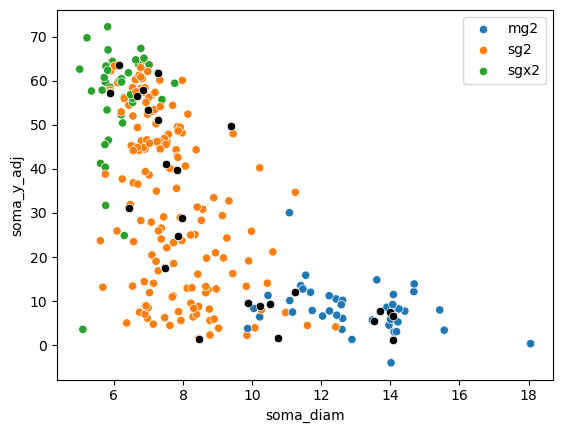

In [219]:
mask = df_soma['cell_type'].isin(['sgx2','sg2','mg2'])
sns.scatterplot(data = df_soma[mask],x='soma_diam',y='soma_y_adj',hue='cell_type')

mask = df_soma['id'].isin(df_edges[df_edges['pre_type'].isin(['sgx2','sg2','mg2'])]['pre'].unique())
sns.scatterplot(data = df_soma[mask],x='soma_diam',y='soma_y_adj',color='black')

In [975]:
maskaff = (df_edges['pre_type'].isin(['grc-d','grc','sgx2','sg2','mg2'])) & (df_edges['post_type'].isin(['aff']))
maskdi = (df_edges['pre_type'].isin(['grc-d','grc','sgx2','sg2','mg2'])) & (df_edges['post_type'].isin(['sg1','smpl','grc-s','sgx1']))
df_input = pd.merge(df_edges[maskaff].groupby(['pre'])['weight'].sum().reset_index().rename(columns = {'pre':'id','weight':'aff'}),
         df_edges[maskdi].groupby(['pre'])['weight'].sum().reset_index().rename(columns = {'pre':'id','weight':'di'}),
         on=['id'])
df_input = pd.merge(df_soma,df_input,on='id')

<Axes: xlabel='soma_diam', ylabel='aff'>

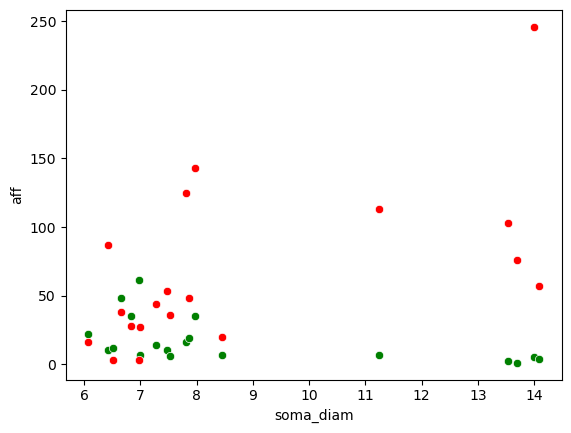

In [977]:
# ax = sns.scatterplot(data=df_input,x='soma_y_adj',y=df_input['aff']/df_input['di'])
ax = sns.scatterplot(data=df_input,x='soma_diam',y='aff',color='green')
sns.scatterplot(data=df_input,x='soma_diam',y='di',ax = ax,color='red')
# ax.set_ylim(0,2)

(0.0, 2.0)

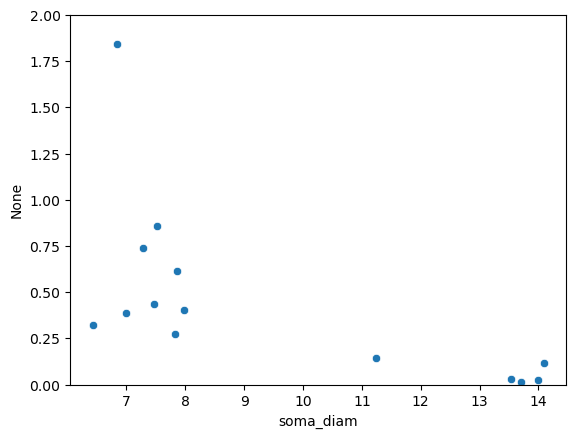

In [957]:

ax = sns.scatterplot(data=df_input,x='soma_diam',y=df_input['aff']/df_input['di'])
ax.set_ylim(0,2)

In [861]:
mask = (df_soma['cell_type'].isin(['sg2'])) & (df_soma['soma_y_adj']>55) & (df_soma['soma_diam']<8)

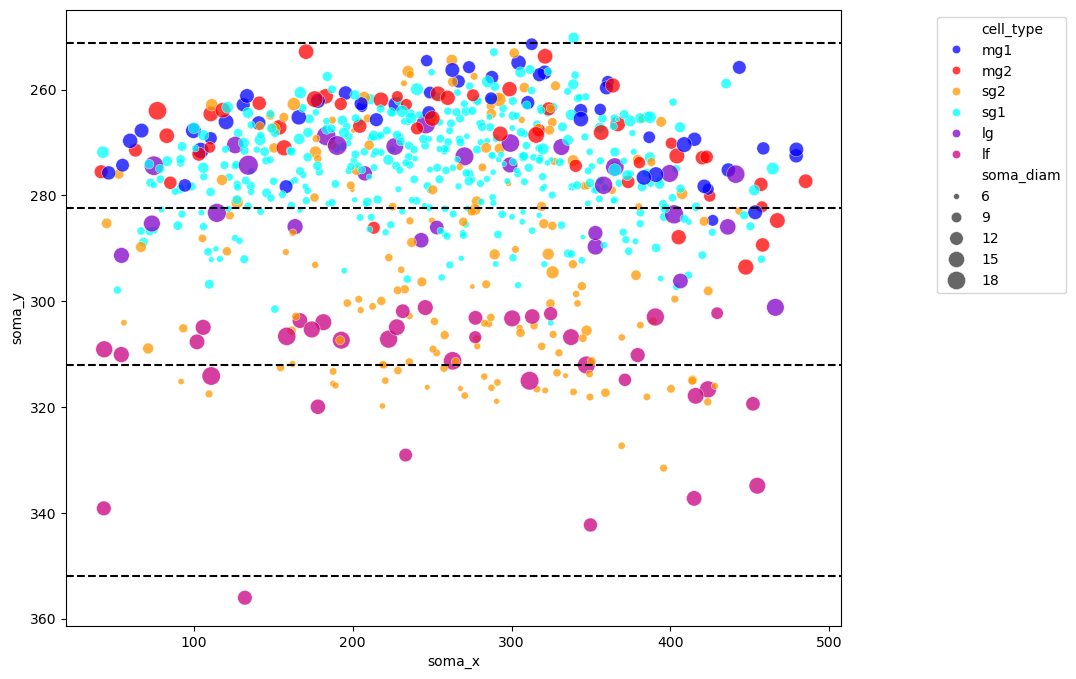

In [223]:
hfig,ax = plt.subplots(1,figsize=(10,8))
sns.scatterplot(data=df_soma[df_soma['cell_type'].isin(['sg1','sg2','mg1','mg2','lg','lf'])],x='soma_x',y='soma_y',hue='cell_type',palette=syn_colors,
                size='soma_diam',sizes=(5, 200),alpha = 0.75)
for y_ in [22000*16, 19500*16, 17650*16, 15700*16]:
    ax.axhline(y=y_/1000,color = 'black',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
# ax.set_ylim(15000*16,22500*16)
ax.invert_yaxis()

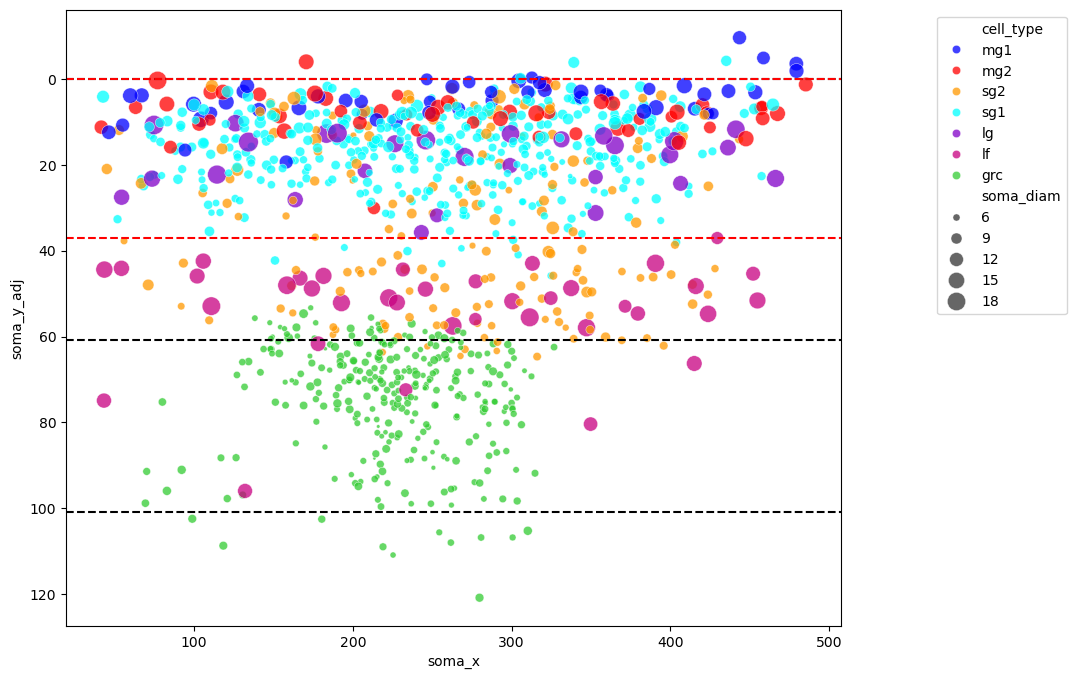

In [27]:
hfig,ax = plt.subplots(1,figsize=(10,8))
sns.scatterplot(data=df_soma[df_soma['cell_type'].isin(['grc','sg1','sg2','mg1','mg2','lg','lf'])],x='soma_x',y='soma_y_adj',hue='cell_type',palette=syn_colors,size='soma_diam',sizes=(5, 200),alpha = 0.75) #['sg1','sg2','mg1','mg2','lg','lf']
for y_ in [(22000-15700)*16, (19500-15700)*16, (15700-15700)*16]: #(17650-15700)*16, 
    ax.axhline(y=y_/1000,color = 'black',linestyle='--')
for y_ in [0,37]:
    ax.axhline(y=y_,color = 'red',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
# ax.set_ylim(15000*16,22500*16)
ax.invert_yaxis()
plt.show()

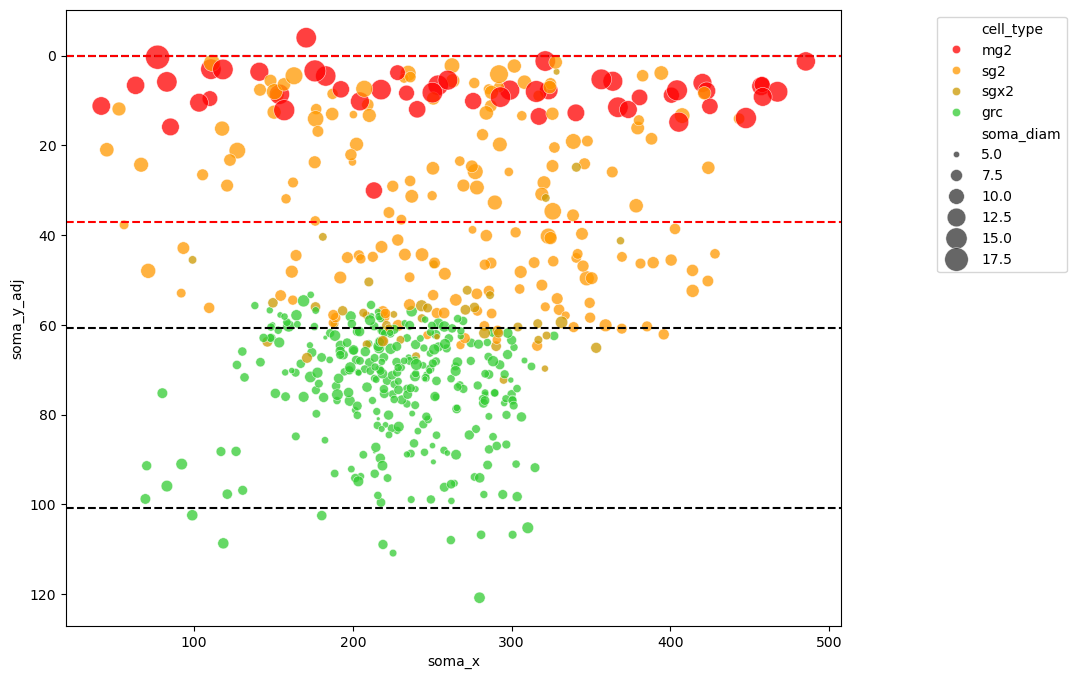

In [229]:
hfig,ax = plt.subplots(1,figsize=(10,8))
sns.scatterplot(data=df_soma[df_soma['cell_type'].isin(['grc','sgx2','sg2','mg2'])],x='soma_x',y='soma_y_adj',hue='cell_type',palette=syn_colors,size='soma_diam',sizes=(5, 300),alpha = 0.75) #['sg1','sg2','mg1','mg2','lg','lf']
for y_ in [(22000-15700)*16, (19500-15700)*16, (15700-15700)*16]: #(17650-15700)*16, 
    ax.axhline(y=y_/1000,color = 'black',linestyle='--')
for y_ in [0,37]:
    ax.axhline(y=y_,color = 'red',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
# ax.set_ylim(15000*16,22500*16)
ax.invert_yaxis()
plt.show()

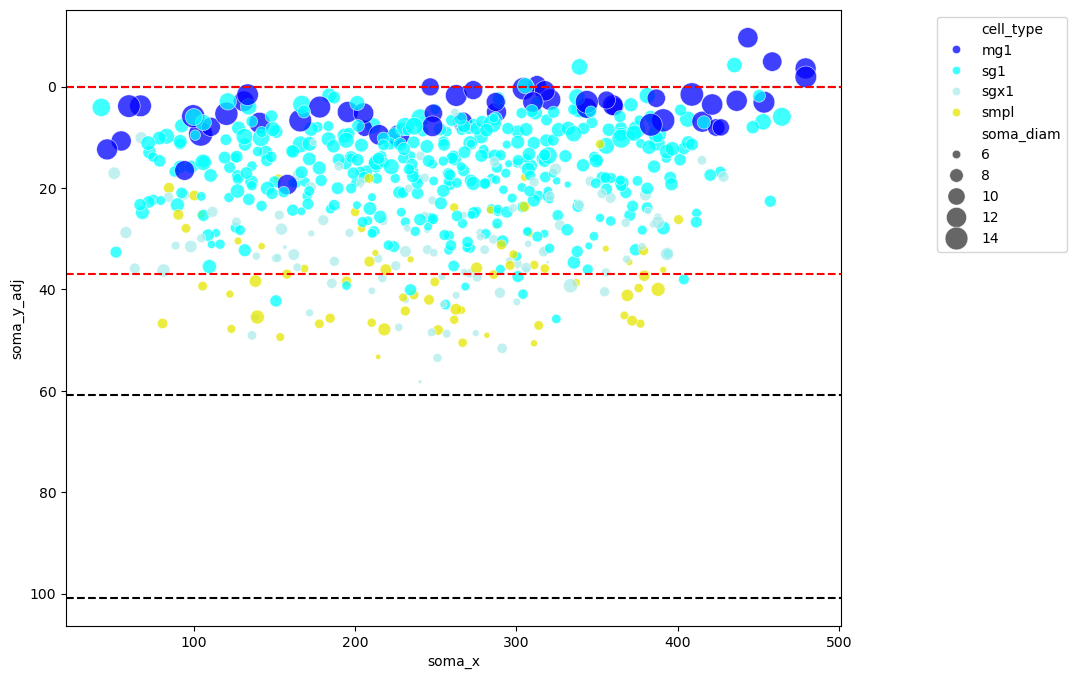

In [230]:
hfig,ax = plt.subplots(1,figsize=(10,8))
sns.scatterplot(data=df_soma[df_soma['cell_type'].isin(['smpl','sgx1','sg1','mg1'])],x='soma_x',y='soma_y_adj',hue='cell_type',palette=syn_colors,size='soma_diam',sizes=(5, 300),alpha = 0.75) #['sg1','sg2','mg1','mg2','lg','lf']
for y_ in [(22000-15700)*16, (19500-15700)*16, (15700-15700)*16]: #(17650-15700)*16, 
    ax.axhline(y=y_/1000,color = 'black',linestyle='--')
for y_ in [0,37]:
    ax.axhline(y=y_,color = 'red',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
# ax.set_ylim(15000*16,22500*16)
ax.invert_yaxis()
plt.show()

In [748]:
output_ann = [393325331,307418797,301787806,392072123,472392041,300474334]


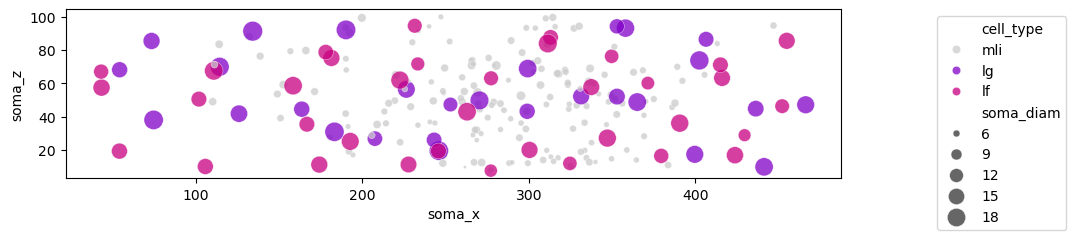

In [545]:
hfig,ax = plt.subplots(1,figsize=(10,8))
sns.scatterplot(data=df_soma[df_soma['cell_type'].isin(['mli','lf','lg'])],x='soma_x',y='soma_z',hue='cell_type',palette=syn_colors,size='soma_diam',sizes=(5, 200),alpha = 0.75) #['sg1','sg2','mg1','mg2','lg','lf']
# sns.scatterplot(data=df_soma[df_soma['id'].isin(output_ann)],x='soma_x',y='soma_z',color='black',size='soma_diam',sizes=(5, 200),alpha = 0.75) 

sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))

ax.set_aspect('equal')
plt.show()

In [763]:
df_soma[(df_soma['cell_type'].isin(['lf'])) & (df_soma['soma_x']>150)& (df_soma['soma_x']<300) & ~df_soma['id'].isin(output_ann)]

id  soma_diam cell_type  soma_x  soma_y  soma_z  soma_y_adj
230   134492570      14.47        lf  245.69  301.20   19.36   48.941764
255   135529018      17.11        lf  192.78  307.37   25.12   52.119419
799   221358318      14.22        lf  166.74  303.66   35.42   46.388581
2075  393078033      18.00        lf  158.46  306.64   58.54   48.036963
2841  479001172      15.79        lf  181.49  303.98   75.19   45.872116
2897  481274292      13.86        lf  178.07  319.96   78.69   61.666806
2968  483687142      11.95        lf  233.32  329.09   71.61   72.410975
3002   48573302      15.47        lf  227.75  304.91   11.24   52.066657
3072   49625293      15.90        lf  174.19  305.34   11.18   48.798653
3109   49841518      11.15        lf  277.15  306.80    7.56   55.951681
3500  563840037      12.95        lf  231.50  301.89   94.52   44.370437
4018  650953193        NaN        lf  272.00  309.13  103.37   50.851025

In [ ]:
393325331 # lf  392072123 307418797
301787806 # lg 472392041  300474334

In [263]:
df_soma[(df_soma['cell_type'].isin(['lf','lg'])) & ((df_soma['soma_x']<300)& (df_soma['soma_x']>200))& ((df_soma['soma_z']<75)& (df_soma['soma_z']>25))]

id  soma_diam cell_type  soma_x  soma_y  soma_z  soma_y_adj
128   129838223      13.72        lg  207.57  275.82   26.77   21.400237
182   132205966      13.98        lg  243.12  288.47   25.96   35.738522
1113  300474334      16.88        lg  226.45  270.74   56.39   15.077543
1148  301727988      18.61        lg  270.34  272.62   49.73   18.158390
1152  301787806      14.57        lg  298.98  274.22   43.18   20.167970
1215  303969144      12.84        lg  252.92  286.06   47.24   31.755431
1308  307418797      18.00        lf  262.90  311.28   42.93   57.524103
1869  392072123      17.50        lf  222.59  307.17   61.89   50.986246
1909  393325331      13.02        lf  277.30  303.14   63.00   47.135229
2415  472392041      17.92        lg  299.29  270.09   68.81   12.784123
2721  483687142      11.95        lf  233.32  329.09   71.61   72.410975

In [182]:
mask = (df_soma['cell_type'].isin(['uk'])) & (df_soma['soma_y_adj']>61) & (100>df_soma['soma_y_adj'])#& (37>df_soma['soma_y_adj']) #

<Axes: xlabel='soma_diam', ylabel='Count'>

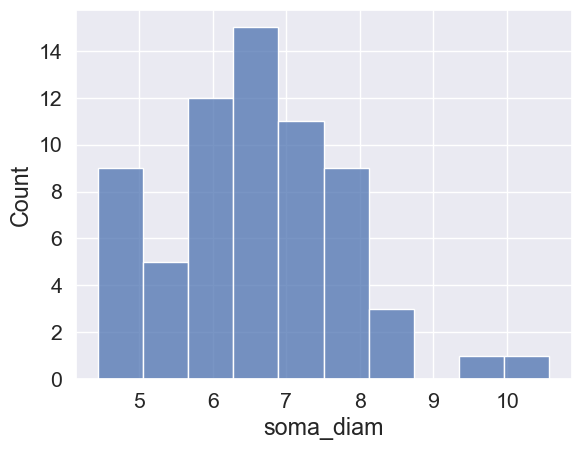

In [183]:
sns.histplot(data=df_soma[mask],x='soma_diam')

In [184]:
df_soma[mask]['id'].values#.sort_values('soma_diam',ascending=False).head(50)#

array([134634255, 137988771, 138130976, 139183144, 142386425, 142571993,
       142651117, 223866888, 223866966, 223912857, 223941461, 224143785,
       224980791, 225028168, 225071474, 226079662, 226247320, 227206860,
       228630093, 230425855, 309678846, 309712320, 309741117, 309802465,
       310513798, 310651611, 310871239, 311987323, 312029654, 312988765,
       313146074, 313562584, 313919138, 314196422, 314212054, 314335736,
       315437044, 391099022, 395542709, 395692303, 396604606, 396838378,
       397705437, 397997102, 399251283, 400522185, 481551715, 482341966,
       482479609, 483779331, 484972148, 484987963, 485018029, 487463682,
        50956829,  50999287,  51991063,  52177863,  52241475,  52320040,
        53215014,  53290934,  53338888,  54435181,  56569306, 567102390,
       571047348,  57373896,  59297712, 654448841, 655220273, 657791522,
       657977227])

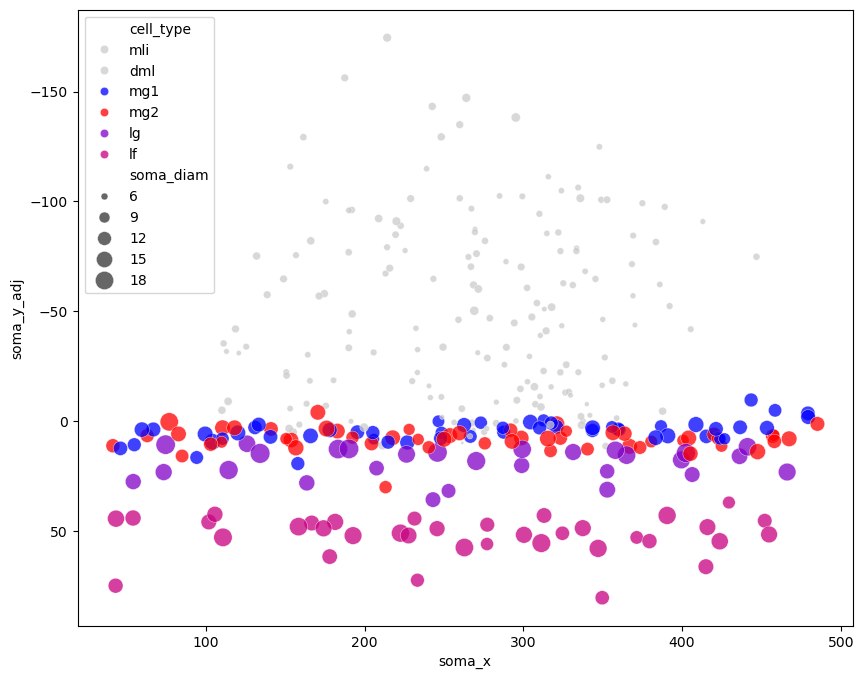

In [538]:
hfig,ax = plt.subplots(1,figsize=(10,8))
sns.scatterplot(data=df_soma[df_soma['cell_type'].isin(['mg1','mg2','lg','lf','mli','dml'])],x='soma_x',y='soma_y_adj',hue='cell_type',palette=syn_colors,size='soma_diam',sizes=(5, 200),alpha = 0.75)
ax.invert_yaxis()

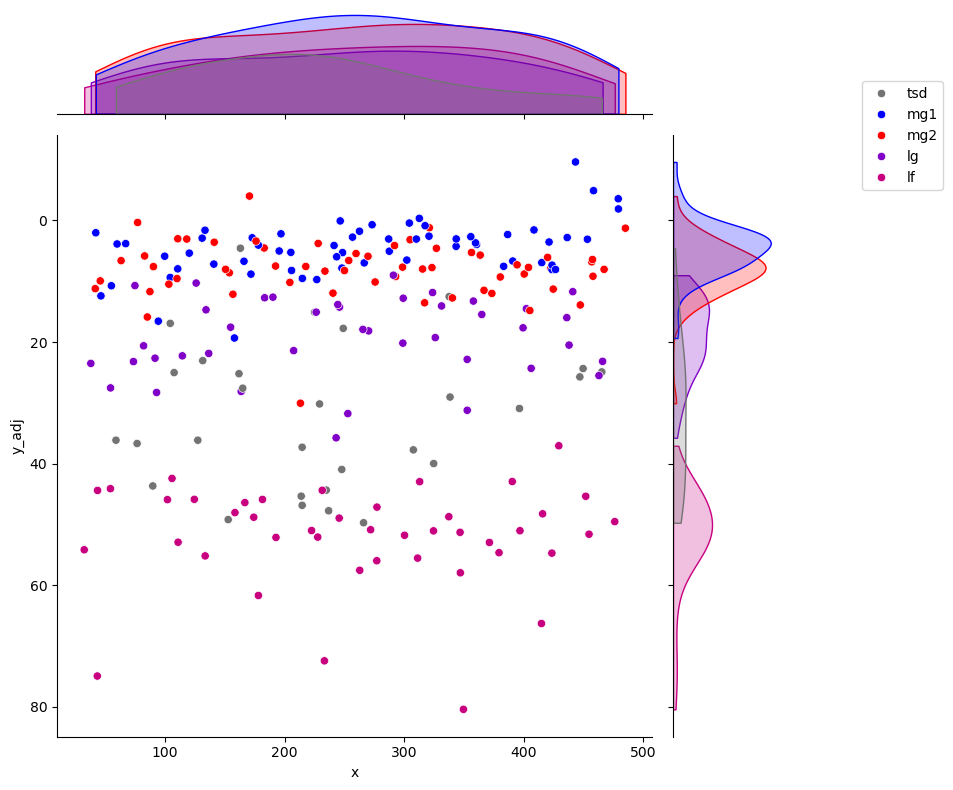

In [126]:
# hfig,ax = plt.subplots(1,figsize=(10,8))
g = sns.jointplot(data=df_soma[df_soma['cell_type'].isin(['mg1','mg2','lg','lf','tsd'])],
              x='x',y='y_adj',hue='cell_type',palette=syn_colors,height=8,marginal_kws = {'cut':0}) #,'grc-d','grc-s','sg1','sg2',
# ax.invert_yaxis()
g.ax_joint.legend(bbox_to_anchor=(1.5, 1.1))
g.ax_joint.invert_yaxis()

### export soma locations to xyz file for blender

In [509]:
soma_pts[0][0]

245690.0

In [16]:
ctype = ['mg2','mg1','lg','lf']

for c_ in ctype:
    soma_pts = df_soma[(df_soma['cell_type'].isin([c_]))][['x','y','z']].values * 1000
    scale_factor = 100000
    
    yaxis_replace_scale = 32768*16/scale_factor
    zaxis_replace_scale = 3500*30/scale_factor
    refpt = [0,0,0]
    
    vertices = [[(v[0]-refpt[0])/scale_factor,
         (v[1]-refpt[1])/scale_factor,
         (v[2]-refpt[2])/scale_factor] for v in soma_pts]
    vertices = [[v[0],yaxis_replace_scale-v[1],-v[2]] for v in vertices] #in this case, the z needed to be mirrored (not sure why did not need to do for cells to blender)
    
    fullpath = f'/Users/kperks/Library/CloudStorage/GoogleDrive-kperky@gmail.com/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/Krista/blender/soma_locations/{c_}_soma.xyz'
    with open(fullpath, 'w') as file:
        for v in vertices:
    
           # file.write(f'{s[0]},{s[1]},{s[2]}\n')
            file.write("{}\t {}\t {}\n".format(v[0],v[2],v[1]))



In [ ]:
# fullpath = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-kperky@gmail.com/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/Krista/blender/mg2_soma.xyz')
with open(fullpath, 'r') as f:
    for line in f:
        values = line.split()
        # print(values)

## distribution soma diam

(5.0, 20.0)

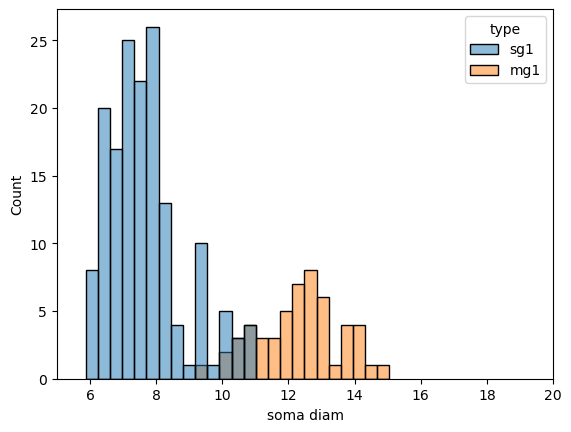

In [482]:

# df['binned'] = pd.cut(df['soma diam'], bins=np.arange(0,4000,200)).values
ax = sns.histplot(data = df[df['type'].isin(['sg1','mg1'])],x='soma diam',bins = 25,hue='type')#,hue='type') ['mg1','mg2','sg1','sg2','sgx1','sgx2']
plt.xlim(5,20)

(5.0, 20.0)

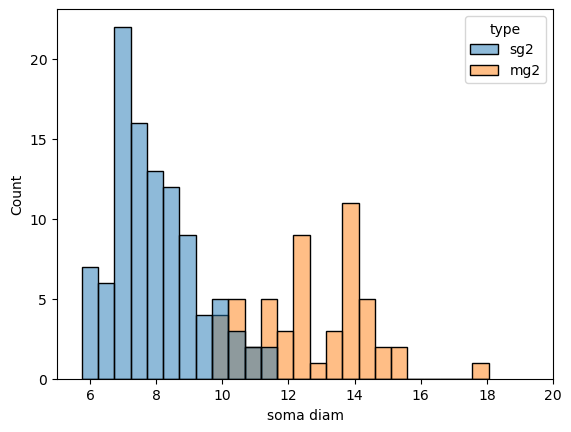

In [461]:
# df['binned'] = pd.cut(df['soma diam'], bins=np.arange(0,4000,200)).values
ax = sns.histplot(data = df[df['type'].isin(['sg2','mg2'])],x='soma diam',bins = 25,hue='type')#,hue='type') ['mg1','mg2','sg1','sg2','sgx1','sgx2']
plt.xlim(5,20)

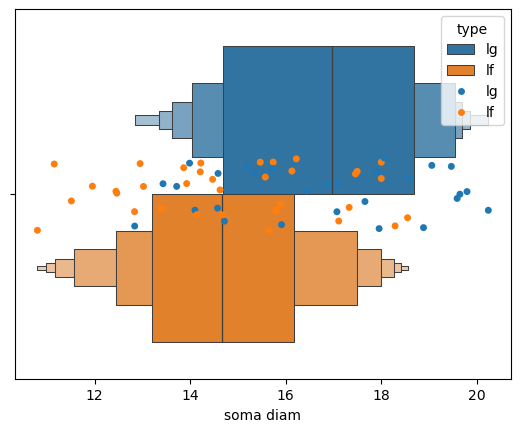

In [402]:
# df['binned'] = pd.cut(df['soma diam'], bins=np.arange(0,4000,200)).values
# ax = sns.histplot(data = df[df['type'].isin(['lg','lf'])],x='soma diam',bins = 10,hue='type')#,hue='type') ['mg1','mg2','sg1','sg2','sgx1','sgx2']
# plt.xlim(5,20)
ax = sns.boxenplot(data = df[df['type'].isin(['lg','lf'])],x='soma diam',hue='type',k_depth ='full')#,hue='type') ['mg1','mg2','sg1','sg2','sgx1','sgx2']
ax = sns.stripplot(data = df[df['type'].isin(['lg','lf'])],x='soma diam',hue='type')#,palette='dark:black')#,k_depth ='full')#,hue='type') ['mg1','mg2','sg1','sg2','sgx1','sgx2']


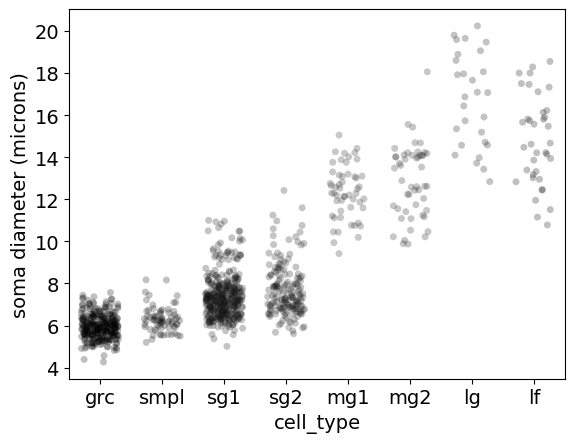

In [232]:

hfig,ax = plt.subplots(1)
# sns.kdeplot(data = df[df['type'].isin(['mg1','mg2','lg','lf'])],x='soma diam',bw_adjust=0.25,cut=0,hue='type',ax=ax) #,'sg1','sg2','sgx1','sgx2'
# sns.kdeplot(data = df[df['type'].isin(['mg1','mg2','lg','lf'])],x='soma diam',bw_adjust=0.25,cut=0,color='black',ax=ax) #,'sg1','sg2','sgx1','sgx2'

sns.stripplot(data = df_soma[df_soma['cell_type'].isin(['grc','smpl','sg1','sg2','mg1','mg2','lg','lf'])],x = 'cell_type',hue='cell_type',y='soma_diam',alpha = 0.25,legend=False,palette='dark:black',order=['grc','smpl','sg1','sg2','mg1','mg2','lg','lf'],jitter=0.3)#,bw_adjust=0.25,cut=0,hue='type',ax=ax) 

ax.set_ylabel('soma diameter (microns)')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)


<Axes: xlabel='type', ylabel='soma diam'>

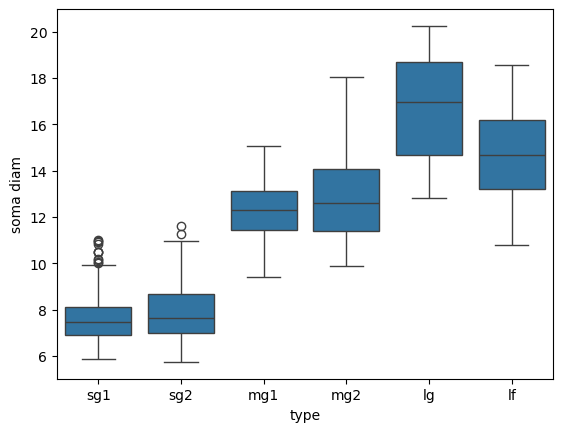

In [463]:
types_include = ['sg1','sg2','mg1','mg2','lg','lf'] #'grc-d','grc-s','sg1','sg2',
sns.boxplot(data = df[df['type'].isin(types_include)], y = 'soma diam', x = 'type',order = types_include)

In [32]:
df.groupby('type')['soma diam'].describe()

count       mean       std      min        25%       50%        75%  \
type                                                                         
UK       0.0        NaN       NaN      NaN        NaN       NaN        NaN   
aff      0.0        NaN       NaN      NaN        NaN       NaN        NaN   
dml     32.0   6.049984  0.603641   5.1600   5.677625   5.87475   6.343375   
fov      0.0        NaN       NaN      NaN        NaN       NaN        NaN   
glia     5.0   6.822300  3.150928   3.7330   5.740000   6.04850   6.451500   
grc-d   44.0   5.980886  0.595482   3.8960   5.621250   5.96700   6.331625   
grc-s   20.0   6.391450  1.134542   5.2760   6.016500   6.10500   6.429500   
lf      33.0  15.003606  2.127972  10.7975  13.391000  14.67150  17.094500   
lg      27.0  16.720630  2.274393  12.8350  14.645000  16.88000  18.748500   
mg1     54.0  12.198065  1.398795   8.0450  11.147875  12.24075  13.098875   
mg2     49.0  12.759408  1.811253   9.8605  11.413500  12.59550  14.093000   
mli    102.0   5.984319  0.520526   4.4330   5.601375   5.95125   6.296625   
pe       0.0        NaN       NaN      NaN        NaN       NaN        NaN   
pf       0.0        NaN       NaN      NaN        NaN       NaN        NaN   
sg1    148.0   7.662527  1.138838   6.0025   6.889375   7.46650   8.147375   
sg2     89.0   7.956994  1.315587   5.7455   6.991500   7.72500   8.729000   
sgx1    25.0   6.508200  0.611328   5.5100   6.148000   6.40550   6.801000   
sgx2    14.0   6.145536  0.735066   5.0125   5.727750   5.83425   6.476375   
tsd     14.0   9.953929  1.246642   7.8165   9.360875   9.77900  10.758250   
uk      97.0   7.512103  1.526092   5.0390   6.746000   7.39200   7.929000   

           max  
type            
UK         NaN  
aff        NaN  
dml     7.4780  
fov        NaN  
glia   12.1385  
grc-d   7.2460  
grc-s  11.0115  
lf     18.5535  
lg     20.2435  
mg1    15.0530  
mg2    18.0595  
mli     7.4490  
pe         NaN  
pf         NaN  
sg1    10.9970  
sg2    11.6010  
sgx1    7.7900  
sgx2    7.7605  
tsd    12.7240  
uk     17.6950

## Load into df_edges

In [9]:

for i,r in df_edges.iterrows():
    try:
        df_edges.loc[i,'pre_diam']=soma_diam[df_edges.loc[i,'pre']]
        df_edges.loc[i,'post_diam']=soma_diam[df_edges.loc[i,'post']]
    except:
        continue
df_edges.loc[:,'diam_diff'] = (df_edges['post_diam']-df_edges['pre_diam'])/df_edges['pre_diam']


# Cell types dict from df_edges

In [31]:
cell_type = {}

for i,r in df_edges.iterrows():
    cell_type[r['pre']]=r['pre_type'].lower()
    cell_type[r['post']]=r['post_type'].lower()
    


In [32]:
len(cell_type)

3253

In [33]:
df_type = pd.DataFrame(cell_type.items(),columns = ['id','type'])

In [34]:
df_type['type'].unique()

array(['sgx2', 'aff', 'grc', 'sg2', 'lg', 'mg2', 'mg1', 'sg1', 'lf',
       'fov', 'sgx1', 'smpl', 'uk', 'mli', 'pe', 'pf', 'h', 'tsd', 'none',
       'glia'], dtype=object)

In [313]:
t = 0
for ctype in ['aff','grc','smpl','sgx1','sgx2','sg1','sg2','mg1','mg2','lg','lf','tsd','h','pf','pe','uk','fov','glia','mli']:
    all_mg = set([int(id_) for id_ in df_type[df_type['cell_type'].isin([ctype])]['id'].values])
    print(f'{len(all_mg)} {ctype}')
    t += len(all_mg)

print(f'total {t}')
# ctype = 'mg1'
# all_mg = set([int(id_) for id_ in df_type[df_type['type'].isin([ctype])]['id'].values])
# print(f'{len(all_mg)} mg1')

65 aff
746 grc
185 smpl
141 sgx1
45 sgx2
384 sg1
167 sg2
81 mg1
79 mg2
42 lg
46 lf
69 tsd
87 h
177 pf
172 pe
783 uk
1773 fov
138 glia
309 mli
total 5489


In [192]:
n = sum(df_type['type'].isin(['lf','lg']))
n1 = sum(df_type['type'].isin(['lg']))
n2 = sum(df_type['type'].isin(['lf']))
print(f'{n} total ouput in network; {n1} lg, {n2} lf')

84 total ouput in network; 41 lg, 43 lf


In [193]:
n = sum(df_type['type'].isin(['mg1','mg2']))
n1 = sum(df_type['type'].isin(['mg1']))
n2 = sum(df_type['type'].isin(['mg2']))
print(f'{n} total mg in network; {n1} mg1, {n2} mg2')

117 total mg in network; 60 mg1, 57 mg2


In [195]:
n = sum(df_type['type'].isin(['sg1','sg2']))
n1 = sum(df_type['type'].isin(['sg1']))
n2 = sum(df_type['type'].isin(['sg2']))
print(f'{n} total sg in network; {n1} sg1, {n2} sg2')

363 total sg in network; 224 sg1, 139 sg2


In [171]:
n = df_edges[df_edges['pre_type'].isin(['mg1','mg2'])]['pre'].nunique()
print(f'{n} have synapses labeled')

101 have synapses labeled


In [172]:
sum(df_type['type'].isin(['pf']))

37

# synapses locations in df_syn

## absolute

In [24]:
# df_syn = pd.read_csv(dirpath / 'graphs/df_pfsyn.csv')
# syn = 'post-synaptic'

In [329]:
syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#737373',
    'pe':'#550055',
    'pf':'#880088'
}

In [ ]:
df_edges['y_adj'] = df_edges['y_adj']/1000 * -1#.max()

In [ ]:
df_edges['depth'] = pd.cut(df_edges['y_adj'], bins=np.arange(0,350,50))

In [388]:
df_edges

pre       post       y_adj pre_type post_type  weight       depth
0    369312115  305130656   98.496519       pf       tsd       2   (50, 100]
1    369312115  214768681  107.802556       pf       sg1       2  (100, 150]
2    369312115   42800051   90.294311       pf       sg2       2   (50, 100]
3    369312115  213501262  106.141067       pf       mg1       2  (100, 150]
4    369312115  213605530  104.977453       pf       mg2       2  (100, 150]
..         ...        ...         ...      ...       ...     ...         ...
916  283391297  214581797  101.487990       pf       mg2       1  (100, 150]
917  283391297  299530386  113.972778       pf       mg1       1  (100, 150]
918  283391297  558300217  112.323926       pf       mg2       1  (100, 150]
919  283391297  560664932  138.351599       pf       sg1       1  (100, 150]
920  636004167  636022214   43.176316       pf       fov       1     (0, 50]

[921 rows x 7 columns]

In [399]:
mask = df_edges['pre'].isin([295969348,295969442,295969134,295969355,295968777,282228761,283375247, 283391297,283390956,282230475,268614458,268614383,273086215,187230424,
                            290552453,27220895,31694533,102463116,188296613,15401313,17877032,187151336]) & df_edges['post_type'].isin(['sg1','sg2','mg1','mg2','lg','lf','mli','tsd','dml']) # 


In [400]:
df_grouped = df_edges[mask][['pre','post_type','depth','weight']].groupby(['depth','post_type']).sum().reset_index()

/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_1104/229427782.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_edges[mask][['pre','post_type','depth','weight']].groupby(['depth','post_type']).sum().reset_index()


In [401]:
df_grouped#[df_grouped['weight']>0]

depth post_type         pre  weight
0      (0, 50]        lf  1183877286       4
1      (0, 50]        lg   591938703       2
2      (0, 50]       mg1  2367754558       8
3      (0, 50]       mg2  3847600490      13
4      (0, 50]       mli  1775816370       6
5      (0, 50]       sg1  3255661382      11
6      (0, 50]       sg2   887908044       3
7      (0, 50]       tsd   295969442       1
8    (50, 100]        lf  1423584192       7
9    (50, 100]        lg   290552453       1
10   (50, 100]       mg1  1180508899       5
11   (50, 100]       mg2  1451487971       9
12   (50, 100]       mli    54441790       2
13   (50, 100]       sg1   290552453       1
14   (50, 100]       sg2   290552453       1
15   (50, 100]       tsd   504924684       3
16  (100, 150]        lf  1486079110       6
17  (100, 150]        lg  1224443759       5
18  (100, 150]       mg1  3861197814      15
19  (100, 150]       mg2  6831573094      28
20  (100, 150]       mli  3712674901      15
21  (100, 150]       sg1   310612192       2
22  (100, 150]       sg2   837543737       3
23  (100, 150]       tsd  1211928925       5
24  (150, 200]        lf  1275103452       5
25  (150, 200]        lg           0       0
26  (150, 200]       mg1  1659774319       7
27  (150, 200]       mg2  4437397282      21
28  (150, 200]       mli  4890685347      25
29  (150, 200]       sg1           0       0
30  (150, 200]       sg2   455844807       2
31  (150, 200]       tsd  1290622369       6
32  (200, 250]        lf           0       0
33  (200, 250]        lg           0       0
34  (200, 250]       mg1           0       0
35  (200, 250]       mg2   537228916       2
36  (200, 250]       mli           0       0
37  (200, 250]       sg1           0       0
38  (200, 250]       sg2           0       0
39  (200, 250]       tsd           0       0
40  (250, 300]        lf           0       0
41  (250, 300]        lg           0       0
42  (250, 300]       mg1           0       0
43  (250, 300]       mg2           0       0
44  (250, 300]       mli           0       0
45  (250, 300]       sg1           0       0
46  (250, 300]       sg2           0       0
47  (250, 300]       tsd           0       0

In [402]:
df_grouped.loc[df_grouped['post_type'].isin(['sg1','sg2']),'class'] = 'sg'
df_grouped.loc[df_grouped['post_type'].isin(['mg1','mg2']),'class'] = 'mg'
df_grouped.loc[df_grouped['post_type'].isin(['lf','lg']),'class'] = 'output'
df_grouped.loc[df_grouped['post_type'].isin(['mli','tsd','dml']),'class'] = 'smooth'

In [403]:
df_grouped['weight_norm'] = df_grouped.groupby('depth')['weight'].transform(lambda x: (x / x.sum()) )

df_grouped['weight_all'] = df_grouped.groupby('depth')['weight'].transform(lambda x: (x.sum()) )





/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_1104/2396153113.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped['weight_norm'] = df_grouped.groupby('depth')['weight'].transform(lambda x: (x / x.sum()) )
/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_1104/2396153113.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped['weight_all'] = df_grouped.groupby('depth')['weight'].transform(lambda x: (x.sum()) )


<Axes: xlabel='depth', ylabel='weight'>

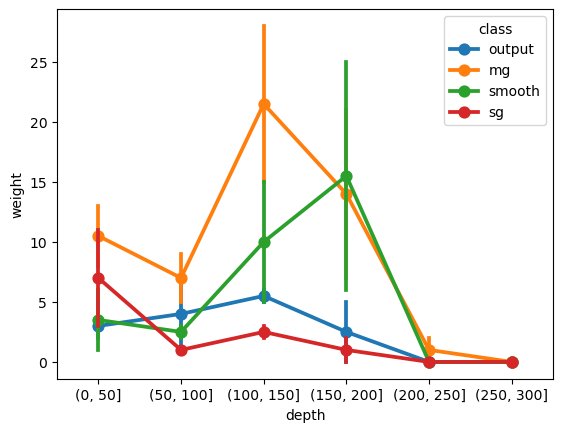

In [404]:
# Create a seaborn plot
sns.pointplot(data=df_grouped,x='depth', y='weight',hue = 'class')
# sns.pointplot(data=df_grouped,x='depth', y='weight_all',color='black')

In [ ]:


sns.stripplot(data = df_syn[mask],x = y_adj,)

In [397]:
for v in ['x','y','z','y_adj']:
    df_syn[v] = df_syn[v]/1000
df_syn['y_adj'] = df_syn['y_adj']*-1    

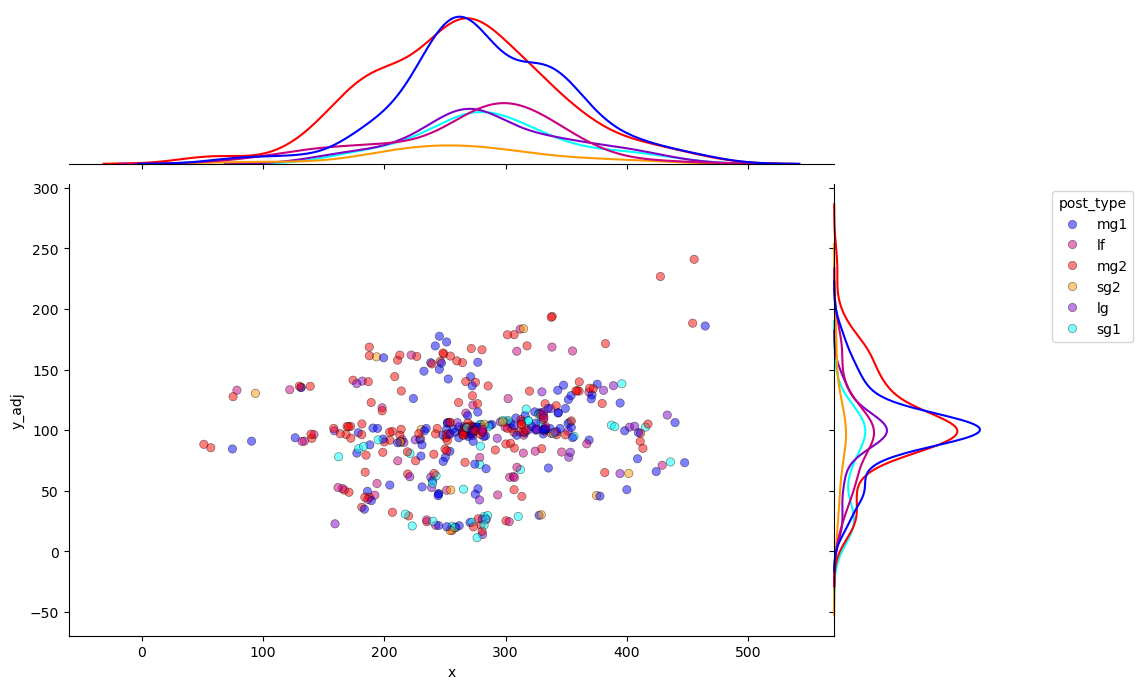

In [398]:

g = sns.jointplot(data=df_syn[df_syn['post_type'].isin(['mg2','mg1','sg2','sg1','lg','lf'])], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
                  x="x", y="y_adj", hue="post_type", height=10,
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

# g = sns.jointplot(data=df_syn[df_syn['pre_type'].isin(['mg2','mg1'])], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
#                   x="x", y="z", hue="pre_type", height=10,
#                   alpha = 0.5, edgecolor='black',palette = syn_colors,
#                  marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# # sns.scatterplot(x=[0],y=[0],color='black',s=100);

# sns_joint_equal_axes(g);
# sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

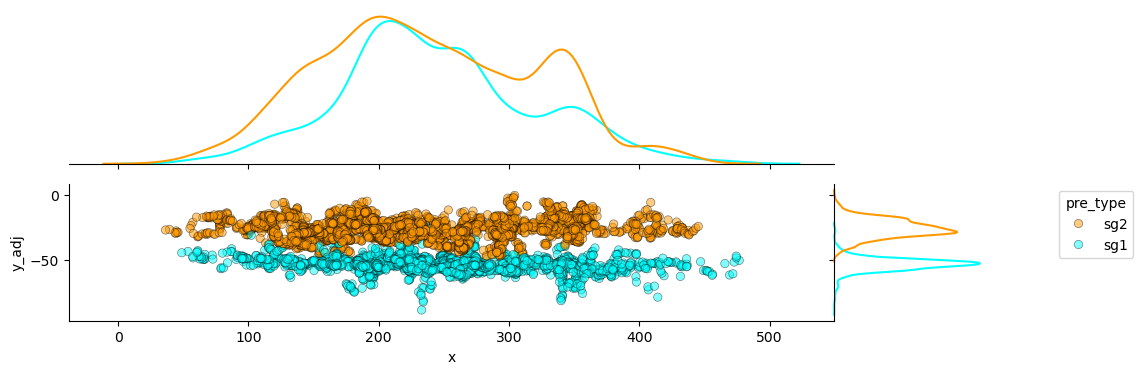

In [95]:

g = sns.jointplot(data=df_syn[df_syn['pre_type'].isin(['sg2','sg1'])], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
                  x="x", y="y_adj", hue="pre_type", height=10,
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

# g = sns.jointplot(data=df_syn[df_syn['pre_type'].isin(['mg2','mg1'])], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
#                   x="x", y="z", hue="pre_type", height=10,
#                   alpha = 0.5, edgecolor='black',palette = syn_colors,
#                  marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# # sns.scatterplot(x=[0],y=[0],color='black',s=100);

# sns_joint_equal_axes(g);
# sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

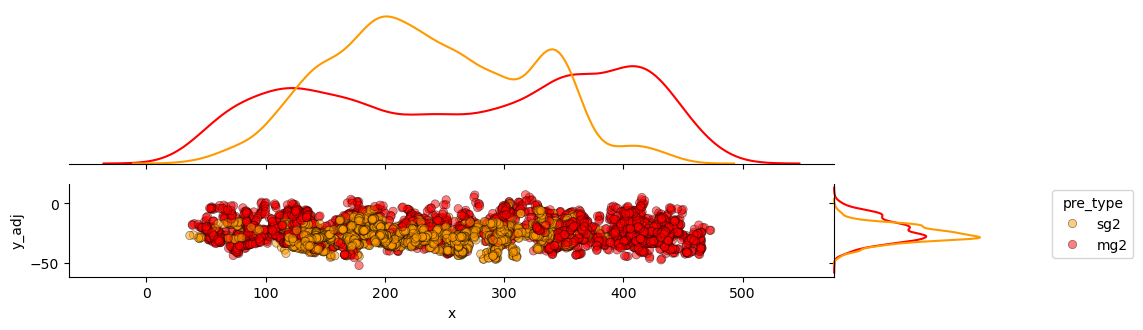

In [96]:

g = sns.jointplot(data=df_syn[df_syn['pre_type'].isin(['mg2','sg2'])], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
                  x="x", y="y_adj", hue="pre_type", height=10,
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

# g = sns.jointplot(data=df_syn[df_syn['pre_type'].isin(['mg2','mg1'])], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
#                   x="x", y="z", hue="pre_type", height=10,
#                   alpha = 0.5, edgecolor='black',palette = syn_colors,
#                  marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# # sns.scatterplot(x=[0],y=[0],color='black',s=100);

# sns_joint_equal_axes(g);
# sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

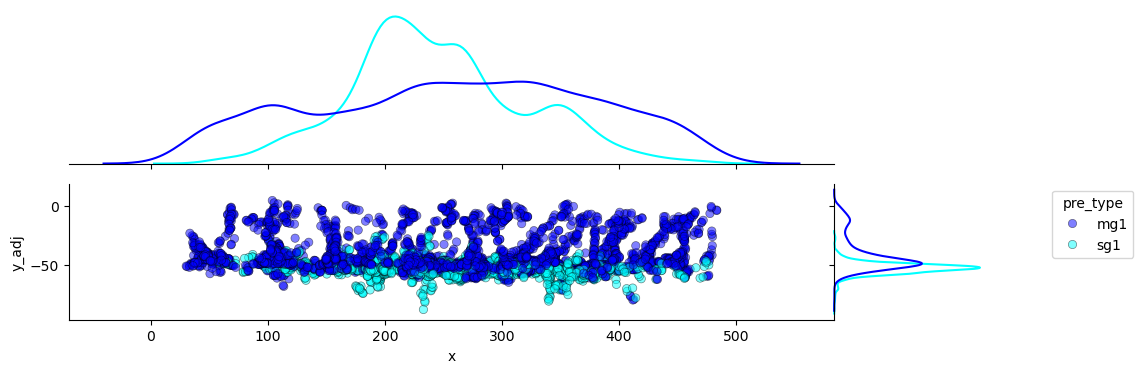

In [97]:

g = sns.jointplot(data=df_syn[df_syn['pre_type'].isin(['mg1','sg1'])], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
                  x="x", y="y_adj", hue="pre_type", height=10,
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

# g = sns.jointplot(data=df_syn[df_syn['pre_type'].isin(['mg2','mg1'])], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
#                   x="x", y="z", hue="pre_type", height=10,
#                   alpha = 0.5, edgecolor='black',palette = syn_colors,
#                  marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# # sns.scatterplot(x=[0],y=[0],color='black',s=100);

# sns_joint_equal_axes(g);
# sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

<Axes: xlabel='soma_diam', ylabel='Count'>

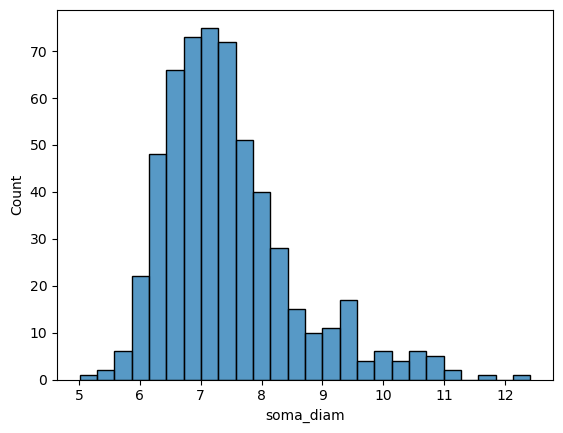

In [44]:
mask = df_soma['cell_type'].isin(['sg1','sg2'])
sns.histplot(data = df_soma[mask],x = 'soma_diam')


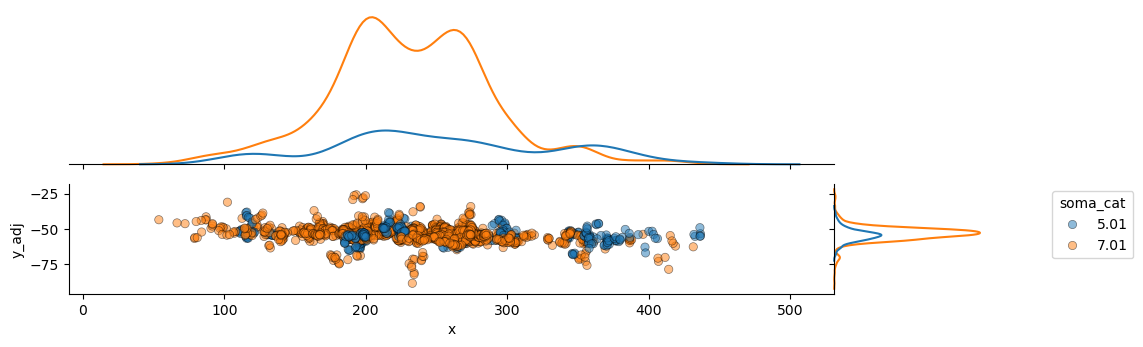

In [98]:
mask = df_soma['cell_type'].isin(['sg1'])
df_merged = pd.merge(df_soma[mask], df_syn.rename(columns = {'pre':'id'}), on='id', how='left')


df_merged['soma_cat'] = pd.cut(x = df_merged['soma_diam'],
                               bins = np.arange(df_merged['soma_diam'].min(),df_merged['soma_diam'].max(),2),
                              labels = np.arange(df_merged['soma_diam'].min(),df_merged['soma_diam'].max(),2)[0:-1])


g = sns.jointplot(data=df_merged.dropna(), #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
                  x="x", y="y_adj", hue="soma_cat", height=10,
                  alpha = 0.5, edgecolor='black',#palette = syn_colors,
                 marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

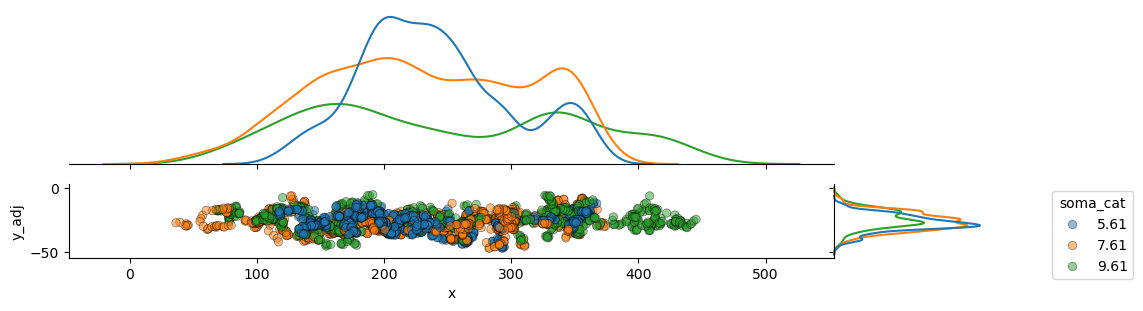

In [99]:
mask = df_soma['cell_type'].isin(['sg2'])
df_merged = pd.merge(df_soma[mask], df_syn.rename(columns = {'pre':'id'}), on='id', how='left')


df_merged['soma_cat'] = pd.cut(x = df_merged['soma_diam'],
                               bins = np.arange(df_merged['soma_diam'].min(),df_merged['soma_diam'].max(),2),
                              labels = np.arange(df_merged['soma_diam'].min(),df_merged['soma_diam'].max(),2)[0:-1])


g = sns.jointplot(data=df_merged.dropna(), #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
                  x="x", y="y_adj", hue="soma_cat", height=10,
                  alpha = 0.5, edgecolor='black',#palette = syn_colors,
                 marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

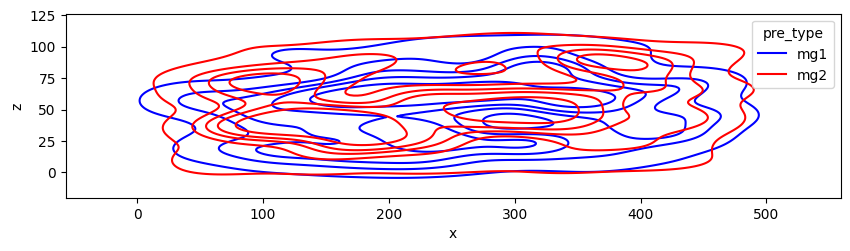

In [49]:
hfig,ax = plt.subplots(1,figsize=(10,10))

g = sns.kdeplot(ax = ax,data = df_syn[df_syn['pre_type'].isin(['mg2','mg1',])],x='x',y='z',hue='pre_type',
                common_norm=True,palette=syn_colors,levels=6)#,thresh=0.15)#,fill=True,alpha = 0.25)

ax = plt.gca()
# ax.set_xlim(-100,100)
ax.set_aspect('equal')

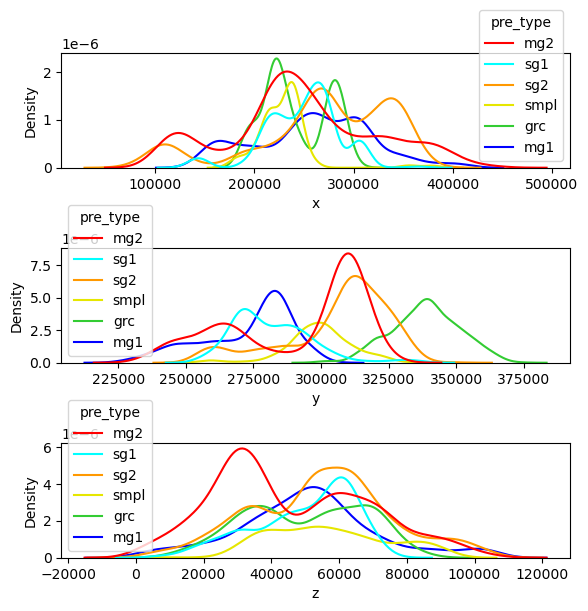

In [233]:
hfig,ax = plt.subplots(3,figsize=(6,6))
sns.kdeplot(ax=ax[0],data = df_syn[df_syn['pre_type'].isin(['sg2','mg2','sg1','mg1','grc','smpl'])],x='x',hue='pre_type',common_norm=True,clip_on=0,palette=syn_colors)
sns.kdeplot(ax=ax[1],data = df_syn[df_syn['pre_type'].isin(['sg2','mg2','sg1','mg1','grc','smpl'])],x='y',hue='pre_type',common_norm=True,clip_on=0,palette=syn_colors)
sns.kdeplot(ax=ax[2],data = df_syn[df_syn['pre_type'].isin(['sg2','mg2','sg1','mg1','grc','smpl'])],x='z',hue='pre_type',common_norm=True,clip_on=0,palette=syn_colors)
plt.tight_layout()

## relative to cell type soma 

### df_syn pre or post

In [21]:
df_syn = pd.read_csv(dirpath / 'graphs/df_postsyn.csv')
syn = 'post-synaptic'

In [22]:
df_syn.loc[df_syn['post_type'].isin(['dml']),'post_type']='mli'

df_syn.loc[df_syn['pre_type'].isin(['dml']),'pre_type']='mli'

### plot

In [23]:
syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#737373' 
}

In [ ]:
df_syn

In [25]:
df_loc = pd.DataFrame(soma_loc.items(), columns=['cell', 'soma loc']).set_index('cell')
post_types_subset = ['lf','lg']

for c in df_loc.index:
    df_loc.loc[c,'type'] = cell_types[c]

# df_to_plot = df_loc[(df_loc.index.isin(df_progress[df_progress['completed']>0.9]['id'].values))&df_loc['type'].isin(['mg1','mg2','sg1','sg2'])].dropna()
df_to_plot = df_loc[df_loc['type'].isin(['mg1','mg2','sg1','sg2'])].dropna()

# Initialize an empty DataFrame
df_syn_locs = pd.DataFrame(columns=['x', 'y', 'z', 'cell_type'])

# Loop through cell types and extend the DataFrame
for i,r in df_to_plot.iterrows():
    # print(i,r)
    
    x,y,z = r['soma loc']
    cell = df_syn[(df_syn['pre'].isin([int(i)])) & (df_syn['post_type'].isin(post_types_subset))]
    # cell = ecrest(settings_dict,filepath = nodefiles[i],launch_viewer=False)
    positions = [(s[0]/1000-x,s[1]/1000-y,s[2]/1000-z) for s in list(cell[['x','y','z']].to_records(index=False))]#cell.cell_data['end_points']['post-synaptic']]
   
    # break
    cell_df = pd.DataFrame(positions, columns=['x', 'y', 'z'])  # Create DataFrame for the current cell type
    cell_df['cell_type'] = r['type']  # Add cell type column
    df_syn_locs = pd.concat([df_syn_locs, cell_df], ignore_index=True)  # Concatenate the current cell DataFrame to the main DataFrame

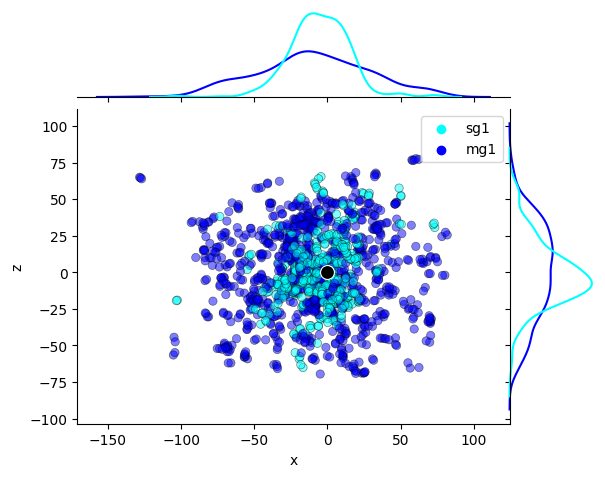

In [26]:
g = sns.jointplot(data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg1','mg1'])], 
                  x="x", y="z", hue="cell_type",
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=False,clip_on=0, fill=False), space=0)
sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);

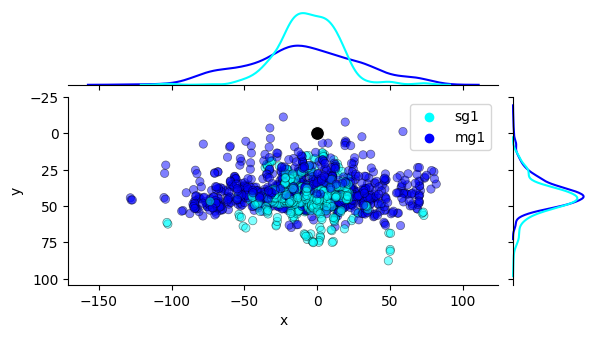

In [27]:
g = sns.jointplot(data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg1','mg1'])], 
                  x="x", y="y", hue="cell_type",
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=False,clip_on=0, fill=False), ratio=5)
sns.scatterplot(x=[0],y=[0],color='black',s=100);

g.ax_joint.invert_yaxis()

g = sns_joint_equal_axes(g)

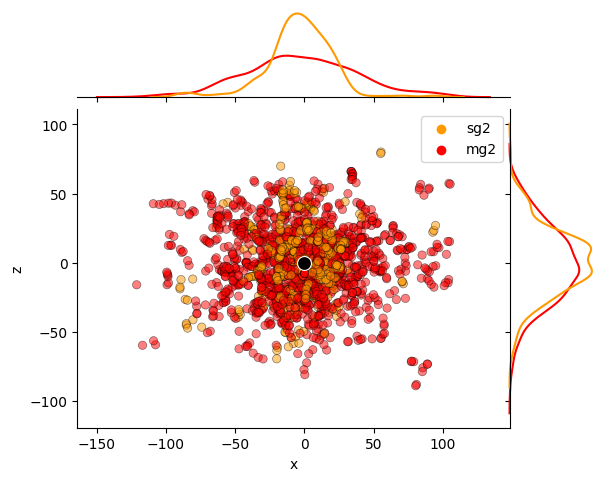

In [28]:
g = sns.jointplot(data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg2','mg2'])], 
                  x="x", y="z", hue="cell_type",
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=False,clip_on=0, fill=False), space=0)
sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);

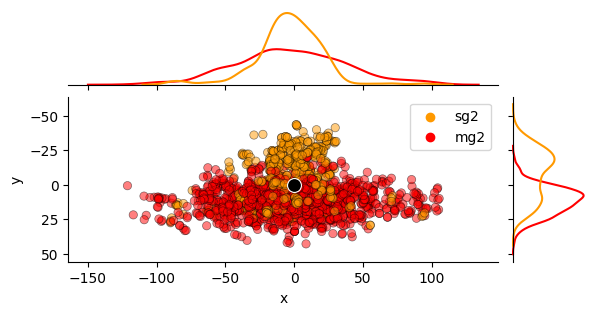

In [29]:
g = sns.jointplot(data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg2','mg2'])], 
                  x="x", y="y", hue="cell_type",
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=False,clip_on=0, fill=False), ratio=5)
sns.scatterplot(x=[0],y=[0],color='black',s=100);

g.ax_joint.invert_yaxis()

g = sns_joint_equal_axes(g)

In [ ]:
g.ax_joint.set_aspect('equal')

this needs to be restricted to data from cells within 150 microns of edge in x (and only analyzed in x) to avoid edge effects


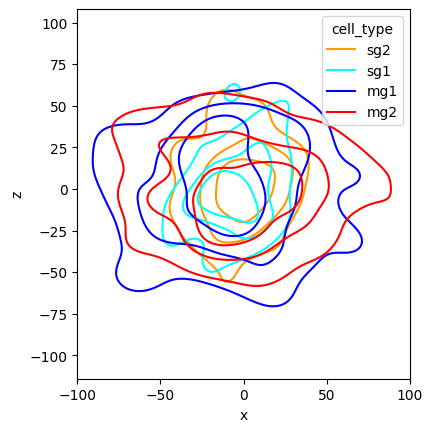

In [31]:
# hfig,ax = plt.subplots(1,figsize=(3,6))
g = sns.kdeplot(data = df_syn_locs,x='x',y='z',hue='cell_type',common_norm=False,palette=syn_colors,levels=4,thresh=0.15)#,fill=True,alpha = 0.25)

ax = plt.gca()
ax.set_xlim(-100,100)
ax.set_aspect('equal')

# hfig,ax = plt.subplots(3,figsize=(6,6))
# sns.kdeplot(ax=ax[0],data = df_syn_locs,x='x',hue='cell_type',common_norm=False,clip_on=0,palette=syn_colors)
# sns.kdeplot(ax=ax[1],data = df_syn_locs,x='y',hue='cell_type',common_norm=False,clip_on=0,palette=syn_colors)
# sns.kdeplot(ax=ax[2],data = df_syn_locs,x='z',hue='cell_type',common_norm=False,clip_on=0,palette=syn_colors)
# plt.tight_layout()

print('this needs to be restricted to data from cells within 150 microns of edge in x (and only analyzed in x) to avoid edge effects')

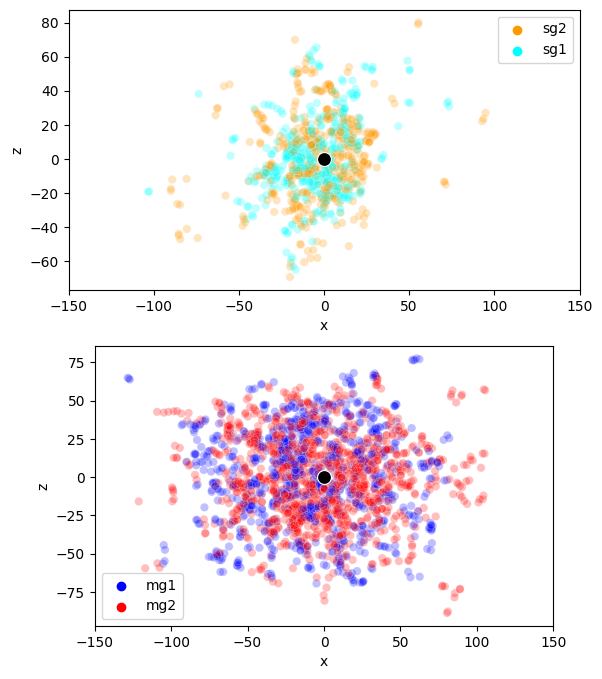

In [32]:
hfig,ax = plt.subplots(2,figsize=(10,8))
sns.scatterplot(ax=ax[0],data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg1','sg2'])],
                x = 'x', y='z',alpha = 0.25,hue='cell_type',palette=syn_colors) #,color='black'
sns.scatterplot(ax=ax[0],x=[0],y=[0],color='black',s=100)
sns.scatterplot(ax=ax[1],data=df_syn_locs[df_syn_locs['cell_type'].isin(['mg1','mg2'])],
                x = 'x', y='z',alpha = 0.25,hue='cell_type',palette=syn_colors) #,color='black'
sns.scatterplot(ax=ax[1],x=[0],y=[0],color='black',s=100)
for a in ax:
    a.set_xlim(-150,150)
    # a.set_ylim(-3000,3000)
    a.set_aspect('equal')

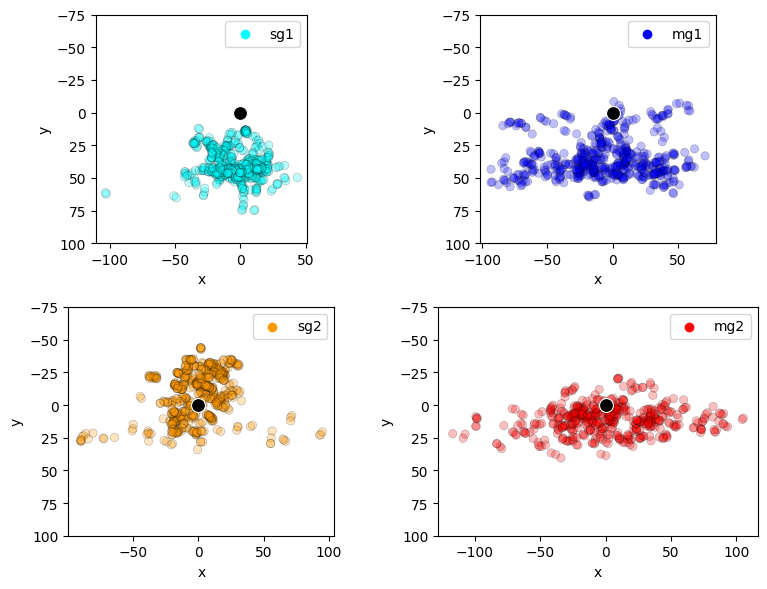

In [1582]:
hfig,ax = plt.subplots(2,2,figsize=(8,6))
sns.scatterplot(ax=ax[0,0],data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg1'])],
                x = 'x', y='y',alpha = 0.25,hue='cell_type',palette=syn_colors,edgecolor="black") #,color='black'
sns.scatterplot(ax=ax[1,0],data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg2'])],
                x = 'x', y='y',alpha = 0.25,hue='cell_type',palette=syn_colors,edgecolor="black") #,color='black'
sns.scatterplot(ax=ax[0,1],data=df_syn_locs[df_syn_locs['cell_type'].isin(['mg1'])],
                x = 'x', y='y',alpha = 0.25,hue='cell_type',palette=syn_colors,edgecolor="black") #,color='black'
sns.scatterplot(ax=ax[1,1],data=df_syn_locs[df_syn_locs['cell_type'].isin(['mg2'])],
                x = 'x', y='y',alpha = 0.25,hue='cell_type',palette=syn_colors,edgecolor="black") #,color='black'
for a in ax:
    for a2 in a:
        sns.scatterplot(ax=a2,x=[0],y=[0],color='black',s=100)

for a in ax:
    for a2 in a:
        # a2.set_xlim(-200,200)
        a2.set_ylim(-75,100)
        a2.set_aspect('equal')
        a2.invert_yaxis()

plt.tight_layout()


# Completeness of synapses



In [421]:
syn = 'post-synaptic'

In [36]:
df_edges['pre_type'].unique()

array(['pf'], dtype=object)

In [422]:
all_types = set(df_edges['pre_type'].unique()) | set(df_edges['post_type'].unique()) #- set(['glia'])
c_type_check = all_types #['mg1','mg2','sg1','sg2','grc']

df_progress = pd.DataFrame(columns = ['id','cell_type','n_syn','done','todo','completed']) #'soma-diam',
for c in df_edges['pre'].unique():
    
    if (df_edges[df_edges['pre'] == c]['pre_type'].unique()[0] in c_type_check):

        c_df = df_edges[df_edges['pre'].isin([c])]
        n_syn_done = c_df['weight'].sum()

        cell = ecrest(settings_dict,filepath = nodefiles[str(c)],launch_viewer=False)
        
        if len(cell.cell_data['end_points'][syn])>0:
            # try:
            cell_dict = {
                'id': cell.cell_data['metadata']['main_seg']['base'],
                'cell_type': df_type[df_type['id']==c]['cell_type'].values[0],#cell_type[c], #cell.get_ctype("manual"),
                # 'soma-diam': soma_diam[c],
                'n_syn': len(cell.cell_data['end_points'][syn]),
                'done': n_syn_done, #len(c_df),
                'todo': len(cell.cell_data['end_points'][syn]) - n_syn_done, #len(c_df),
                'completed': n_syn_done / (len(cell.cell_data['end_points'][syn]))
                }
            # except:
            #     print(f'error on {c}')
            #     continue
        
        if len(cell.cell_data['end_points'][syn])==0:
            cell_dict = {
                'id': cell.cell_data['metadata']['main_seg']['base'],
                'cell_type': df_type[df_type['id']==c]['cell_type'].values[0],#cell_type[c], #cell.get_ctype("manual"),
                # 'soma-diam': soma_diam[c],
                'n_syn': np.NaN,
                'done': n_syn_done, #len(c_df),
                'todo': np.NaN, #len(c_df),
                'completed': np.NaN
                }
            # print(f'error on {c}')
            # continue

        cell_df = pd.DataFrame([cell_dict]).dropna(how='all')
        if not cell_df.empty:
            df_progress = pd.concat([df_progress, cell_df], ignore_index=True)

        # df_progress = pd.concat([df_progress,pd.DataFrame([cell_dict])])

/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_1104/3185662864.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_progress = pd.concat([df_progress, cell_df], ignore_index=True)


In [423]:
df_progress[(df_progress['cell_type'].isin(['pf']))& (df_progress['todo']>0)].sort_values('todo')# & (df_progress['todo']>0) #grc','sgx2','sg2','mg2

id cell_type n_syn done todo  completed
35  273086215        pf    37   36    1   0.972973
57  283375247        pf    14   13    1   0.928571
41  117041378        pf    45   32   13   0.711111

In [181]:
df_progress[(df_progress['cell_type'].isin(['mg1','mg2']))]['todo'].sum()#& (df_progress['todo']>0)]['id'].values

-5

<Axes: xlabel='n_syn', ylabel='Count'>

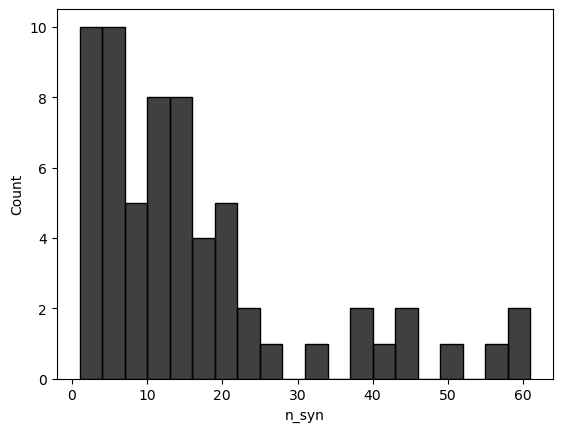

In [425]:
sns.histplot(df_progress[(df_progress['cell_type'].isin(['pf']))&(df_progress['n_syn']>0)]['n_syn'],color='black',bins=20)#['id'].values

In [109]:
df_progress[(df_progress['type'].isin(['smpl','grc','sg1','sg2','mg1','mg2','lg','lf']))]['todo'].sum()

1080

In [168]:
df_progress[(df_progress['type'].isin(['grc','sgx2','sg2','mg2']))]

id  type n_syn done todo  completed
0   394470350  sgx2   275  208   67   0.756364
2   482680782   grc   216  216    0   1.000000
3   389891998   sg2   218  218    0   1.000000
4   483689146   grc   122   60   62   0.491803
7   309774327  sgx2   197  106   91   0.538071
8    50786130   sg2   240   83  157   0.345833
9   214581797   mg2   582  581    1   0.998282
10  393433572   sg2   104   96    8   0.923077
13  306461085   sg2   228  165   63   0.723684
15  222597526   grc    98   96    2   0.979592
16  647514445   sg2   165   87   78   0.527273
17  213605530   mg2   141  141    0   1.000000
19  300226567   sg2   242  165   77   0.681818
21  386392158   mg2   206  205    1   0.995146
22  385434515   sg2   135  102   33   0.755556
23  216129202   mg2    86   64   22   0.744186
25  218095913   sg2   134  125    9   0.932836
26  483610898   grc    62   64   -2   1.032258
30  215492896   mg2   225  204   21   0.906667
31  386426114   mg2   173  173    0   1.000000
37  387850816   mg2   116  116    0   1.000000
41  126649726   mg2   161  161    0   1.000000
42  299404889   mg2   119  118    1   0.991597
43  394423863   sg2    46   46    0   1.000000
44  395461156   grc    79   77    2   0.974684
46  477962738   sg2    57   56    1   0.982456
47  227254070   grc    42   22   20   0.523810
51  395507584   sg2    63   29   34   0.460317
60  473491444   sg2    83   83    0   1.000000
63  313068329   grc    43   24   19   0.558140
69  403522169   grc    33   10   23   0.303030
71  394329802  sgx2    24   11   13   0.458333
73  400210172   grc    28   28    0   1.000000
78  228321391   grc    11    2    9   0.181818

In [161]:
df_progress[(df_progress['type'].isin(['grc']))].sort_values(['n_syn'])#['todo'].sum()

id type n_syn done todo  completed
78  228321391  grc    11    2    9   0.181818
73  400210172  grc    28   28    0   1.000000
69  403522169  grc    33   10   23   0.303030
47  227254070  grc    42   22   20   0.523810
63  313068329  grc    43   24   19   0.558140
26  483610898  grc    62   64   -2   1.032258
44  395461156  grc    79   77    2   0.974684
15  222597526  grc    98   96    2   0.979592
4   483689146  grc   122   60   62   0.491803
2   482680782  grc   216  216    0   1.000000

In [162]:
df_progress[(df_progress['type'].isin(['sgx2']))].sort_values(['n_syn'])#['todo'].sum()

id  type n_syn done todo  completed
71  394329802  sgx2    24   11   13   0.458333
7   309774327  sgx2   197  106   91   0.538071
0   394470350  sgx2   275  208   67   0.756364

In [163]:
df_progress[(df_progress['type'].isin(['sg2']))].sort_values(['n_syn'])#['todo'].sum()

id type n_syn done todo  completed
43  394423863  sg2    46   46    0   1.000000
46  477962738  sg2    57   56    1   0.982456
51  395507584  sg2    63   29   34   0.460317
60  473491444  sg2    83   83    0   1.000000
10  393433572  sg2   104   96    8   0.923077
25  218095913  sg2   134  125    9   0.932836
22  385434515  sg2   135  102   33   0.755556
16  647514445  sg2   165   87   78   0.527273
3   389891998  sg2   218  218    0   1.000000
13  306461085  sg2   228  165   63   0.723684
8    50786130  sg2   240   83  157   0.345833
19  300226567  sg2   242  165   77   0.681818

In [164]:
df_progress[(df_progress['type'].isin(['mg2']))].sort_values(['n_syn'])#['todo'].sum()

id type n_syn done todo  completed
23  216129202  mg2    86   64   22   0.744186
37  387850816  mg2   116  116    0   1.000000
42  299404889  mg2   119  118    1   0.991597
17  213605530  mg2   141  141    0   1.000000
41  126649726  mg2   161  161    0   1.000000
31  386426114  mg2   173  173    0   1.000000
21  386392158  mg2   206  205    1   0.995146
30  215492896  mg2   225  204   21   0.906667
9   214581797  mg2   582  581    1   0.998282

In [311]:
df_edges[(df_edges['pre_type'].isin(['smpl','grc','sg1','sg2','mg1','mg2','lg','lf']))].groupby(['pre_type'])['pre'].nunique()

Series([], Name: pre, dtype: int64)

In [16]:
df_progress[df_progress['completed']>0.9][['id','type','completed']].groupby('type').describe()

completed                                                              \
          count      mean       std       min       25%       50%       75%   
type                                                                          
dml         3.0  0.975370  0.031409  0.940000  0.963056  0.986111  0.993056   
grc-d      12.0  0.998428  0.005447  0.981132  1.000000  1.000000  1.000000   
grc-s      10.0  0.995663  0.010413  0.967742  1.000000  1.000000  1.000000   
mg1        51.0  1.000000  0.000000  1.000000  1.000000  1.000000  1.000000   
mg2        50.0  0.999770  0.001626  0.988506  1.000000  1.000000  1.000000   
mli         2.0  0.996212  0.005357  0.992424  0.994318  0.996212  0.998106   
pe          4.0  1.000000  0.000000  1.000000  1.000000  1.000000  1.000000   
pf         35.0  1.000000  0.000000  1.000000  1.000000  1.000000  1.000000   
sg1        19.0  0.993493  0.022294  0.903226  1.000000  1.000000  1.000000   
sg2        24.0  0.971696  0.035563  0.902439  0.942204  0.997191  1.000000   
sgx1        1.0  1.000000       NaN  1.000000  1.000000  1.000000  1.000000   
sgx2        1.0  1.000000       NaN  1.000000  1.000000  1.000000  1.000000   
tsd         1.0  1.000000       NaN  1.000000  1.000000  1.000000  1.000000   

            
       max  
type        
dml    1.0  
grc-d  1.0  
grc-s  1.0  
mg1    1.0  
mg2    1.0  
mli    1.0  
pe     1.0  
pf     1.0  
sg1    1.0  
sg2    1.0  
sgx1   1.0  
sgx2   1.0  
tsd    1.0

# Filtered df_edges

In [580]:
# Filter by pre and/or post cell type

network_types = ['mg1','mg2','sg1','sg2','lg','lf','grc-d','grc-s']#,'lg','lf','glia']#(set(df_edges['pre_type'].unique()) | set(df_edges['post_type'].unique())) #- set(['glia'])

# df_edges = df_edges[(df_edges['pre_type'].isin(network_types - set(['sgx1','sgx2'])))&(df_edges['post_type'].isin(network_types))]# - set(['lg','lf'])

# df_edges = df_edges[(df_edges['pre_type'].isin(network_types))&(df_edges['post_type'].isin(network_types))]# - set(['lg','lf'])

df_edges = df_edges[(df_edges['pre_type'].isin(['mg1','mg2'])) & (df_edges['post_type'].isin(['mg1','mg2','lg','lf']))] # ['mg1','mg2','sg1','sg2','sgx1','sgx2','aff','grc-d','grc-s']

In [246]:
canonical_sgs = [386455093, 387554847, 301693439, 387493257, 387677355, 300596446,
       302654853, 302668963, 215712894, 386565412,389891998, 220336851, 308471538, 309743149, 392055938, 476801247,
       393433572, 477962738, 473491444, 394423863] # from min 10 kdist kmeans on sg cluster with ['soma_diam','bdstd_x','axstd_x','axstd_z','bdstd_z','soma_x','soma_z']
        # see where others done are in that distrubution: 218095913, 385434515
mask = (df_edges['pre_type'].isin(['sg1','sg2'])) & ~(df_edges['pre'].isin(canonical_sgs))
df_edges.drop(df_edges[mask].index, inplace=True)

In [359]:
df_edges = df_edges[df_edges['pre'].isin([int(id_) for id_ in df_progress[(df_progress['type'].isin(['mli'])) & (df_progress['n_syn']>1)]['id'].values])]

In [19]:
# Filter by completeness of synaptic reconstructions
df_edges_completed = df_edges[df_edges['pre'].isin([int(id_) for id_ in df_progress[df_progress['completed']>0.9]['id'].values])]

In [20]:
# add afferent back in for postsynaptic even though not complete
df_edges = pd.concat([df_edges_completed,df_edges[df_edges['pre_type'].isin(['aff'])]])
   

In [204]:
# if syn=='post-synaptic':
#     df_syn_completed = df_syn[df_syn['pre'].isin([int(id_) for id_ in df_progress[df_progress['completed']>0.9]['id'].values])]
#     df_syn = pd.concat([df_syn_completed,df_syn[df_syn['pre_type'].isin(['aff'])]])
    
    
# if syn=='pre-synaptic':
#     df_syn = df_syn[df_syn['pre'].isin([int(id_) for id_ in df_progress[df_progress['completed']>0.3]['id'].values])]

In [745]:
df_progress[(df_progress['type'].isin(['grc']))].sort_values('todo').head(100) #  ['id'].values# & (df_progress['todo']<12)]['id'].values #  #& (df_progress['todo']>0)

id type n_syn done todo  completed
2   482680782  grc   216  216    0   1.000000
5   223881844  grc    96   96    0   1.000000
8   226019332  grc    86   86    0   1.000000
10  222597526  grc    98   96    2   0.979592
53  228321391  grc    11    2    9   0.181818
51  400210172  grc    21    5   16   0.238095
46  313068329  grc    43   23   20   0.534884
47  403522169  grc    33   10   23   0.303030
43  228366816  grc    96   49   47   0.510417
4   483689146  grc   121   59   62   0.487603
1   481412554  grc   168   99   69   0.589286

In [754]:
df_edges[(df_edges['pre'].isin([223881844]))].groupby(['post_type'])['weight'].sum()#['post'].nunique()

post_type
aff     25
fov     30
h        7
sg1      1
sgx1     1
smpl     1
uk      31
Name: weight, dtype: int64

## cells to target for connection

In [146]:
# syn_to_lg = df_edges[(df_edges['post'].isin([214503199]))&df_edges['pre_type'].isin(['mg2'])]['pre'].values
syn_to_lg = df_edges[(df_edges['post_type'].isin(['lg']))&df_edges['pre_type'].isin(['mg2'])]['pre'].values
mask = (df_edges['post'].isin(syn_to_lg)) & (df_edges['pre_type'].isin(['mg1']))
df_edges[mask].groupby('post')['pre'].nunique()

post
40448913      2
40665046      1
41825714      2
128536704     4
129030308     4
129512755     4
129619070     6
213605530    12
214581797     9
216129202     5
216177846     2
216192012     1
217396339     2
218575005     5
299249397     3
299404889    11
300316308     3
300689181     3
301308616     4
301339154     3
303212610     6
303287910     3
303877666     1
386117124     3
386300356     1
386392158     1
386426114     1
387091598     2
387338914    11
387850816     5
390294014     3
472051969     1
472284925     3
472517114     3
473631846     7
474839189     2
477300082     4
558300217     5
644823522     2
644824766     1
646634295     1
647809492     1
Name: pre, dtype: int64

In [147]:
# syn_to_lg = df_edges[(df_edges['post'].isin([393464000]))&df_edges['pre_type'].isin(['mg1'])]['pre'].values
syn_to_lg = df_edges[(df_edges['post_type'].isin(['lf']))&df_edges['pre_type'].isin(['mg1'])]['pre'].values
mask = (df_edges['post'].isin(syn_to_lg)) & (df_edges['pre_type'].isin(['mg2']))
df_edges[mask].groupby('post')['pre'].nunique()

post
42632020      5
43622486      2
44548558      3
126618353     5
127870654     6
128737253     8
131585534     3
213590737     3
213669553     9
213760634     2
214411806     8
214550811     2
215030183     4
215480645     5
299392199     1
299439953     6
299496636    11
299530386     4
300131090     1
300210608     9
300459385     2
302143252     5
303244291     1
386114963     7
386224676     8
386612701     1
386643184     5
387909811    10
389085521     4
472114046     4
472175645     2
472282894     2
473723476     4
474111084     6
474236060     5
474373577     2
476167179     5
558360429     7
560744270     6
560819551     7
642905044     1
643848637     3
644005141     2
644143297     2
Name: pre, dtype: int64

In [144]:

df_edges[(df_edges['post'].isin([299496636])) &df_edges['pre_type'].isin(['mg2'])]['pre'].values

array([386392158, 472361842, 472284925, 472517114,  40665046, 558300217,
       646634295, 472051969, 129030308, 300689181, 300503092])

# Connectivity relative to other cells


### soma loc df

In [503]:
dirpath = Path(settings_dict['save_dir'])
nodefiles = get_cell_filepaths(dirpath)

### distance for connected versus unconnected

In [219]:
df_soma.head()


id  soma_diam cell_type  soma_x  soma_y  soma_z       y_adj
0  109461049        NaN       fov     NaN     NaN     NaN         NaN
1  109502641        5.8       mli  334.54  145.68   15.26 -106.323605
2  110418632        NaN        uk     NaN     NaN     NaN         NaN
3  110611085        NaN       fov     NaN     NaN     NaN         NaN
4  110620163        NaN       fov     NaN     NaN     NaN         NaN

In [289]:
df_sub = df_syn[(df_syn['pre_type'].isin(['mg1','mg2'])) & (df_syn['post_type'].isin(['mg1','mg2']))] #'lg','lf'

distances_connected = []
for pre in df_sub['pre'].unique():
    source_ids = ('id',[pre])
    target_ids = ('id',df_sub[(df_sub['pre'].isin([pre]))]['post'].unique())
    d = pairwise_distances(df_soma, target_ids = target_ids, source_ids = source_ids)
    distances_connected.extend(d)
    
distances_unconnected = []
for pre in df_sub['pre'].unique():
    source_ids = ('id',[pre])
    
    # post ids not connected to this pre
    post_not_targets = list(set(df_sub['post'].unique()) - set(df_sub[(df_sub['pre'].isin([pre]))]['post'].unique()))
    
    target_ids = ('id',post_not_targets)
    d = pairwise_distances(df_soma, target_ids = target_ids, source_ids = source_ids)
    distances_unconnected.extend(d) 
distances_unconnected = [d for d in distances_unconnected if d>0]

data = {'connected' : distances_connected, 'unconnected' : distances_unconnected}
data = pd.DataFrame.from_dict(data, orient='index').transpose()

data = data.melt(var_name = 'pairwise', value_name='distance')
data['distance']=data['distance']#/1000

# plt.figure(figsize=(3,5))

# # sns.stripplot(data = data, y = 'distance',x = 'pairwise',jitter = 0.3,alpha = 0.3,color = 'black')#datadistances_connected)
# sns.boxplot(data = data, y = 'distance',x = 'pairwise',color='gray',zorder=3)
# # sns.scatterplot(distances_unconnected)
# plt.ylim(-1,500)

# plt.figure(figsize=(6,2))
# sns.kdeplot(data = data, x = 'distance',hue = 'pairwise',common_norm=True,cut=0)

# data.groupby(['pairwise']).describe()

# Define the number of bins and bin width
num_bins = 100
bin_width = (data['distance'].max() - data['distance'].min()) / num_bins

# Create bins
bins = np.arange(data['distance'].min(), data['distance'].max() + bin_width, bin_width)

# Bin the distance column
data['distance_bin'] = pd.cut(data['distance'], bins=bins, include_lowest=True)


# Group by distance bins and calculate the probability of connection
prob_connected = data.groupby('distance_bin')['pairwise'].apply(lambda x: (x == 'connected').mean()).reset_index() # for example, np.mean([True,False]) = 0.5 so it accomplishes what the following would: data.groupby('distance_bin')['pairwise'].apply(lambda x: (x == 'connected').sum() / len(x)).reset_index()

prob_connected['distance_mid']=pd.to_numeric(prob_connected['distance_bin'].apply(lambda x: x.mid))

/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_41492/917640650.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_connected = data.groupby('distance_bin')['pairwise'].apply(lambda x: (x == 'connected').mean()).reset_index() # for example, np.mean([True,False]) = 0.5 so it accomplishes what the following would: data.groupby('distance_bin')['pairwise'].apply(lambda x: (x == 'connected').sum() / len(x)).reset_index()


In [290]:
prob_connected_mg = prob_connected

In [288]:
prob_connected_output = prob_connected

In [292]:
# Add 'target' column with 'mg' value for prob_connected_mg dataframe
prob_connected_mg['target'] = 'mg'

# Add 'target' column with 'output' value for prob_connected_output dataframe
prob_connected_output['target'] = 'output'

# Append the dataframes together
prob_connected = pd.concat([prob_connected_mg, prob_connected_output], ignore_index=True)


In [269]:
from scipy.optimize import curve_fit

def func(x, a, b):#, c):
    return a*x + b #a * np.exp(-b * x) + c

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[None]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


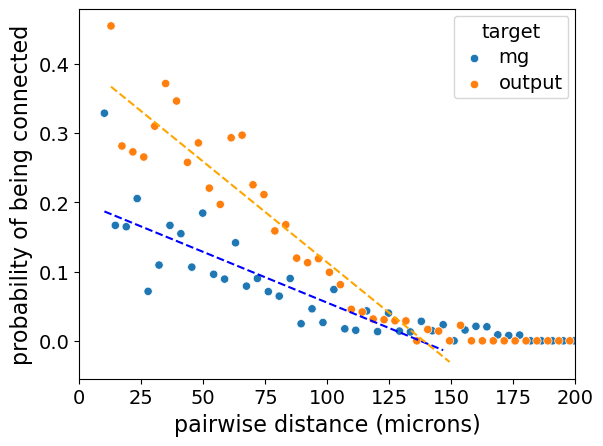

In [316]:
# Plot the relationship
ax = sns.scatterplot(data=prob_connected,x='distance_mid',y='pairwise',hue='target')
ax.set_xlim(0,200)


mask = (prob_connected_mg['distance_mid'] <150)
x = prob_connected_mg[mask]['distance_mid']
y = prob_connected_mg[mask]['pairwise'].values
popt, pcov = curve_fit(func, x, y)
ax.plot(x, func(x, *popt), color = 'blue', linestyle = '--')


mask = (prob_connected_output['distance_mid'] <150)
x = prob_connected_output[mask]['distance_mid']
y = prob_connected_output[mask]['pairwise'].values
popt, pcov = curve_fit(func, x, y)
ax.plot(x, func(x, *popt), color = 'orange', linestyle = '--')

ax.set_xlabel('pairwise distance (microns)', fontsize=16)
ax.set_ylabel('probability of being connected', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
# ax.tick_params(axis='both', which='minor', labelsize=8)

plt.setp(ax.get_legend().get_texts(), fontsize='14') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### connection weight as a function of distance

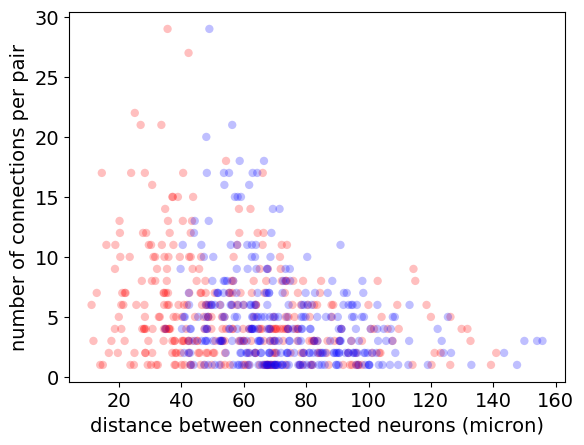

In [280]:
hfig,ax = plt.subplots(1)

df_sub = df_edges[(df_edges['pre_type'].isin(['mg2'])) & (df_edges['post_type'].isin(['lg']))]

d = []
w = []
for i,r in df_sub.iterrows():
    try:
        # print('done')
        d.append(pairwise_distances(df_soma, target_ids = ['id',[r['post']]], dimensions = ['x','y','z'], source_ids = ['id',[r['pre']]]))
        w.append(r['weight'])
    except KeyError as msg:
        print(msg)
        continue
# needs_soma.unique()

ax.scatter(array(d)/1000,w,alpha = 0.25,color='red',edgecolors='none')#color = {'mg1':'blue', 'mg2':'red'})


df_sub = df_edges[(df_edges['pre_type'].isin(['mg1'])) & (df_edges['post_type'].isin(['lf']))]

d = []
w = []
for i,r in df_sub.iterrows():
    try:
        # print('done')
        d.append(pairwise_distances(df_soma, target_ids = ['id',[r['post']]], dimensions = ['x','y','z'], source_ids = ['id',[r['pre']]]))
        w.append(r['weight'])
    except KeyError as msg:
        print(msg)
        continue
# needs_soma.unique()

ax.scatter(array(d)/1000,w,alpha = 0.25,color='blue',edgecolors='none')#color = {'mg1':'blue', 'mg2':'red'})


plt.ylabel('number of connections per pair')
plt.xlabel('distance between connected neurons (micron)')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.savefig('/Users/kperks/Downloads/connection-distance-mg-out-scatter.svg') 

### scatter of connected versus unconnected for example cells

In [77]:

df_sub = df_syn[(df_syn['pre_type'].isin(['mg1'])) & (df_syn['post_type'].isin(['lf']))]

## when need connected inputs
# connected_ids = []
# for pre in df_sub['pre'].unique():
#     connected_ids.append(df_sub[(df_sub['pre'].isin([pre]))]['post'].unique())

# unconnected_ids = []
# for pre in df_sub['pre'].unique():
#     unconnected_ids.append(list(set(df_sub['post'].unique()) - set(df_sub[(df_sub['pre'].isin([pre]))]['post'].unique())))

# when need connected targets
connected_ids = []
for source in df_sub['pre'].unique():
    connected_ids.append(df_sub[(df_sub['pre'].isin([source]))]['post'].unique())

unconnected_ids = []
for source in df_sub['pre'].unique():
    unconnected_ids.append(list(set(df_sub['post'].unique()) - set(df_sub[(df_sub['pre'].isin([source]))]['post'].unique())))

In [78]:
df = pd.DataFrame({'pre':df_sub['pre'].unique(),'connected':connected_ids,'unconnected':unconnected_ids}).set_index('pre')

In [80]:
source = 299530386#128536704 #129512755 #
l = df_soma.loc[df_soma['id'].isin([source]),['x','z']].values[0]

l_t = df_soma.loc[df_soma['id'].isin(df.loc[source,'connected']),['x','z']].values

l_not = df_soma.loc[df_soma['id'].isin(df.loc[source,'unconnected']),['x','z']].values

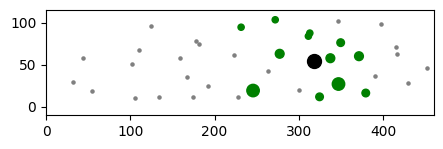

In [84]:
# plt.scatter(l[0],l[1],color = 'black',s = 100)

hfig,ax = plt.subplots(1,figsize=(5,5))

ax.scatter(x = l[0]/1000, y = l[1]/1000, s = 100, color = 'black')


s = df_edges[df_edges['pre'].isin([source]) & df_edges['post_type'].isin(['lf'])]['weight']
ax.scatter(x=[l[0]/1000 for l in l_t],
           y=[l[1]/1000 for l in l_t],
           s=s * 10,color = 'green')

ax.scatter(x=[l[0]/1000 for l in l_not],
           y=[l[1]/1000 for l in l_not],
           s=5,color = 'gray')

ax = plt.gca()
ax.set_xlim(0,460)
ax.set_ylim(-10,115)
ax.set_aspect('equal')

### example cells closest to a certain location or with most syn partners

In [694]:

# target_ids
target_ids = ['id',df_soma[df_soma['cell_type'].isin(['lg'])]['id'].values]

np.argmin(pairwise_distances(df_soma, target_ids = target_ids, dimensions = ['x','z'], source_coords = [250000,50000]))

# df_sub.iloc[np.argmin(abs(df_sub[['x','z']]-[250000,50000]))]

13

In [695]:
target_ids[1][13]

303969144

In [62]:
# look for postsynaptic target with largest number of inputs
df_edges[df_edges['post_type'].isin(['lg'])& df_edges['pre_type'].isin(['mg2'])].groupby('post')['pre'].nunique()

post
43065865      4
44933647      6
44995670      5
45540439      8
45633163      4
45955972      7
128770984     8
129838223     8
131737545     1
132205966     5
214503199    18
215403551     8
215526370    14
300474334     9
301727988    10
301787806    12
301863996     8
302637877    12
303086200     7
303969144     3
304388296     9
305332461    13
388406692    17
390542812    13
472392041    11
474898913    11
558020412     8
559041561     8
560046380     3
560681683     7
561826647     5
563096031    10
644112836     6
645162652     4
645210795     2
647112371     7
647640784     3
650161520     3
651198621     2
652529320     4
Name: pre, dtype: int64

In [23]:
c_id = 393325331
df_edges[df_edges['post'].isin([c_id])& df_edges['pre_type'].isin(['mg1'])]['pre'].values


array([126618353, 127870654, 128737253, 128813171, 213501262, 213590737,
       213669553, 213760634, 299439953, 299496636, 299530386, 472175645,
       472409584, 473647416, 557092670, 558360429, 642905044, 644005141,
       644143297])

In [64]:
# look for postsynaptic target with largest number of inputs
df_edges[df_edges['pre_type'].isin(['mg1'])& df_edges['post_type'].isin(['lf'])].groupby('pre')['post'].nunique()

pre
41579854      5
41843700      8
42201085      3
42632020      5
43622486      2
44517560      2
44548558      2
126618353     5
127870654    10
128737253     8
128813171     6
213501262     7
213590737     5
213669553     7
213760634     7
214411806     8
214550811     3
215030183     4
215480645     4
216081986     6
299392199     4
299439953     9
299496636     7
299530386    12
300131090     5
300210608    10
300380579     4
300459385     7
302143252     4
386114963     4
386224676     8
386643184     7
387909811     9
389085521     4
472114046     6
472175645     9
472282894     4
472409584     9
473723476     5
474111084     2
474236060     8
474373577     5
476167179     5
559551706     8
560744270     9
560819551     6
642905044     8
643848637    11
644005141     8
644143297     7
Name: post, dtype: int64

In [66]:
# df_edges[df_edges['post'].isin([393464000]) & df_edges['pre_type'].isin(['mg1']) ]['pre'].values

df_edges[df_edges['pre'].isin([299530386]) & df_edges['post_type'].isin(['lf'])]['post'].values

array([564038367, 393464000, 134492570, 393325331, 563840037, 565183253,
       394686712,  48807023, 485096532,  48929295, 135870940, 650953193])

In [780]:
# targets with most inputs
target = 214503199 # lg # 393464000 # lf # 
pre_type = 'mg2' # mg2 for lg; mg1 for lf
# df_edges[df_edges['post'].isin([target])]

l = df_soma.loc[df_soma['id'].isin([target]),['x','z']].values[0]

connected = df_edges[df_edges['post'].isin([target])]['pre']
l_t = df_soma.loc[df_soma['id'].isin(connected),['x','z']].values

unconnected = set(df_edges[df_edges['pre_type'].isin([pre_type])]['pre'].unique()) - set(connected)
l_not = df_soma.loc[df_soma['id'].isin(unconnected),['x','z']].values

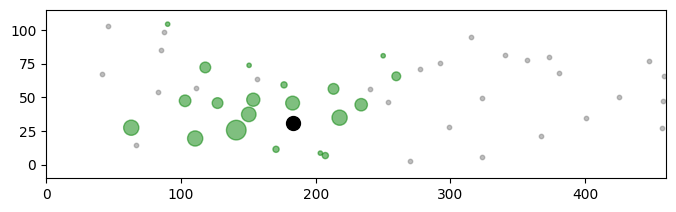

In [781]:
# plt.scatter(l[0],l[1],color = 'black',s = 100)

hfig,ax = plt.subplots(1,figsize=(8,8))

ax.scatter(x = l[0]/1000, y = l[1]/1000, s = 100, color = 'black')

s = df_edges[df_edges['post'].isin([target])]['weight']
ax.scatter(x=[l[0]/1000 for l in l_t],
           y=[l[1]/1000 for l in l_t],
           s=s*10,color = 'green',alpha = 0.5)

ax.scatter(x=[l[0]/1000 for l in l_not],
           y=[l[1]/1000 for l in l_not],
           s=10,color = 'gray',alpha = 0.5)

ax = plt.gca()
ax.set_xlim(0,460)
ax.set_ylim(-10,115)
ax.set_aspect('equal')

### df_syn pre or post

In [570]:
dirpath = Path(settings_dict['save_dir'])
nodefiles = get_cell_filepaths(dirpath)

In [269]:
df_syn = pd.read_csv(dirpath / 'graphs/df_postsyn.csv')
syn = 'post-synaptic'

In [270]:
df_syn.loc[df_syn['post_type'].isin(['dml']),'post_type']='mli'

df_syn.loc[df_syn['pre_type'].isin(['dml']),'pre_type']='mli'

In [195]:
'''do not convert if soma annotations not converted'''

# for v in ['x','y','z']:
#     df_syn[v] = df_syn[v]/1000
    

'do not convert if soma annotations not converted'

In [196]:
# df_syn['y'] = df_syn['y']*-1

### plot

In [60]:
syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#737373' 
}

In [61]:
df_soma

id  soma_diam cell_type         x         y        z
0     109461049        NaN       fov       NaN       NaN      NaN
1     109502641     5799.0       mli  334544.0  145676.0  15255.0
2     110418632        NaN        uk       NaN       NaN      NaN
3     110611085        NaN       fov       NaN       NaN      NaN
4     110620163        NaN       fov       NaN       NaN      NaN
...         ...        ...       ...       ...       ...      ...
3550  667942902        NaN       aff       NaN       NaN      NaN
3551  668081112        NaN       aff       NaN       NaN      NaN
3552  668343333        NaN       aff       NaN       NaN      NaN
3553  669119245        NaN       aff       NaN       NaN      NaN
3554  669195832        NaN       aff       NaN       NaN      NaN

[3555 rows x 6 columns]

In [62]:
pre_types_subset = ['mg1']
post_types_subset = ['lf']

for c in df_loc.index:
    df_loc.loc[c,'type'] = cell_types[c]

# df_to_plot = df_loc[(df_loc.index.isin(df_progress[df_progress['completed']>0.9]['id'].values))&df_loc['type'].isin(['mg1','mg2','sg1','sg2'])].dropna()
df_to_plot = df_soma[df_soma['type'].isin(['mg1','mg2','lf','lg'])].dropna()

# Initialize an empty DataFrame
df_syn_locs = pd.DataFrame(columns=['x', 'y', 'z', 'cell_type'])

# Loop through cell types and extend the DataFrame
for i,r in df_to_plot.iterrows():
    # print(i,r)
    
    x,y,z = r['soma loc']
    cell = df_syn[(df_syn['pre'].isin([int(i)])) & (df_syn['post_type'].isin(post_types_subset))]
    # cell = ecrest(settings_dict,filepath = nodefiles[i],launch_viewer=False)
    positions = [(s[0]/1000-x,s[1]/1000-y,s[2]/1000-z) for s in list(cell[['x','y','z']].to_records(index=False))]#cell.cell_data['end_points']['post-synaptic']]
   
    # break
    cell_df = pd.DataFrame(positions, columns=['x', 'y', 'z'])  # Create DataFrame for the current cell type
    cell_df['cell_type'] = r['type']  # Add cell type column
    df_syn_locs = pd.concat([df_syn_locs, cell_df], ignore_index=True)  # Concatenate the current cell DataFrame to the main DataFrame

KeyError: '109461049'

In [667]:
g.ax_joint

<AxesSubplot:xlabel='x', ylabel='z'>

/Users/kperks/opt/anaconda3/envs/ell-cv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kperks/opt/anaconda3/envs/ell-cv/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/kperks/opt/anaconda3/envs/ell-cv/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/kperks/opt/anaconda3/en

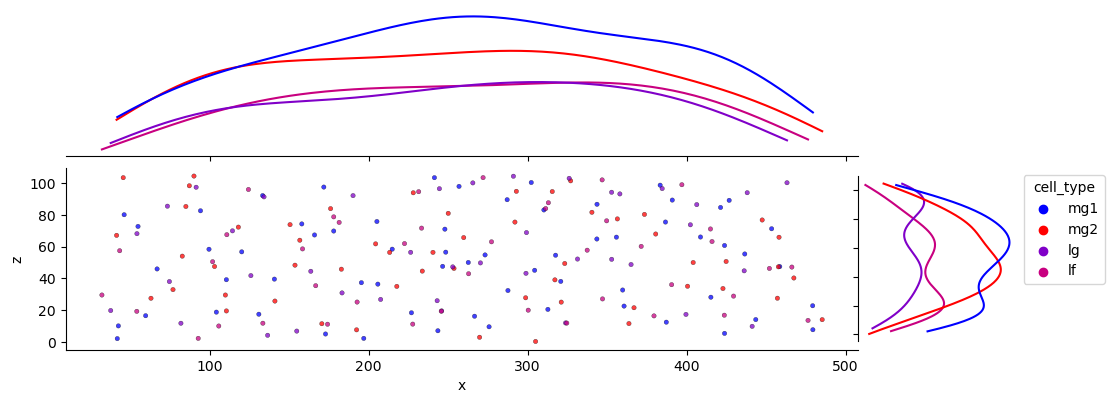

In [63]:
df_scaled = deepcopy(df_soma)
df_scaled['x']= df_scaled['x']/1000
df_scaled['y']= df_scaled['y']/1000 *-1
df_scaled['z']= df_scaled['z']/1000
g = sns.jointplot(data=df_scaled[df_scaled['cell_type'].isin(['mg2','mg1','lg','lf'])], 
                  x="x", y="z", hue="cell_type",s=10,
                  alpha = 0.75, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=True,cut=0, fill=False), space=0)
# sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);
sns.move_legend(g.ax_joint, "upper left", bbox_to_anchor=(1.2, 1))
g.fig.set_size_inches((11, 10))

/Users/kperks/opt/anaconda3/envs/ell-cv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kperks/opt/anaconda3/envs/ell-cv/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/kperks/opt/anaconda3/envs/ell-cv/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/kperks/opt/anaconda3/en

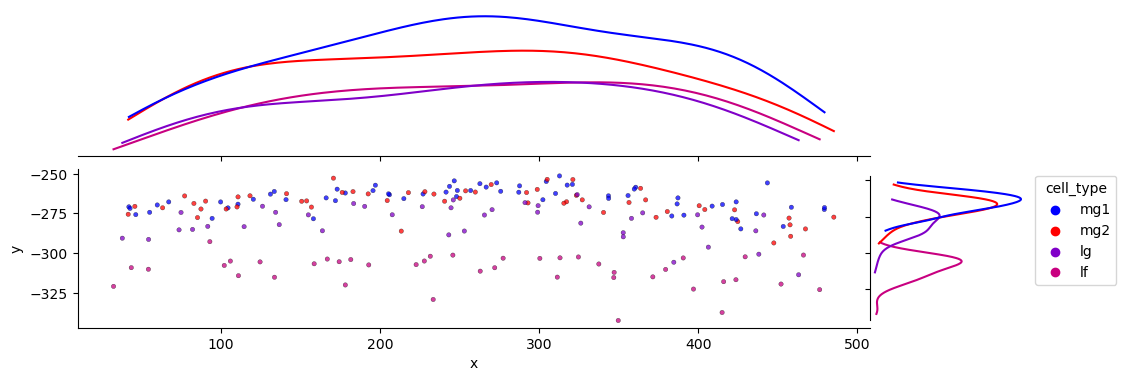

In [64]:

g = sns.jointplot(data=df_scaled[df_scaled['cell_type'].isin(['mg2','mg1','lg','lf'])], 
                  x="x", y="y", hue="cell_type",s=10,
                  alpha = 0.75, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=True,cut=0, fill=False), space=0)
# sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);
sns.move_legend(g.ax_joint, "upper left", bbox_to_anchor=(1.2, 1))
g.fig.set_size_inches((11, 10))

# Connectivity Matrix quantifications

Most appropriately used when focusing on df_edges from either df_syn pre or post, but not the combined df_edges

In [640]:
gto1=df_edges[(df_edges['pre_type'].isin(['grc']))&(df_edges['post_type'].isin(['lg']))]['pre'].values
df_edges[(df_edges['pre'].isin(gto1)) & (df_edges['post_type'].isin(['mg1']))]['pre'].unique()

array([142617839, 397842806, 226019332, 568432342, 483689146, 484864533,
       228366816, 311102279, 312018359, 310887446])

In [641]:
gto1

array([310887446, 311102279, 142617839, 226019332, 311102279, 397842806,
       310435608, 228366816, 310887446, 226019332, 483689146, 312018359,
       312018359, 233289657, 228366816, 312018359, 312018359, 484864533,
       233289657, 228383295, 568432342, 223881844, 228366816, 397842806,
       484864533, 483689146, 233289657, 228366816, 223881844, 142617839,
       310435608, 313068329, 310591127, 310435608])

In [503]:
mask = df_edges['pre'].isin([299496636,214581797,301787806,393325331]) #& df_edges['post_type'].isin(['mg1','mg2'])


In [153]:
canonical_sgs = [386455093, 387554847, 301693439, 387493257, 387677355, 300596446,
       302654853, 302668963, 215712894, 386565412,389891998, 220336851, 308471538, 309743149, 392055938, 476801247,
       393433572, 477962738, 473491444, 394423863] # from min 10 kdist kmeans on sg cluster with ['soma_diam','bdstd_x','axstd_x','axstd_z','bdstd_z','soma_x','soma_z']
        # see where others done are in that distrubution: 218095913, 385434515

mask = (df_edges['pre_type'].isin(['mg1','mg2','sg1','sg2'])) & (df_edges['post_type'].isin(['lg','lf','mg1','mg2','sg1','sg2'])) & (df_edges['pre'].isin(canonical_sgs))



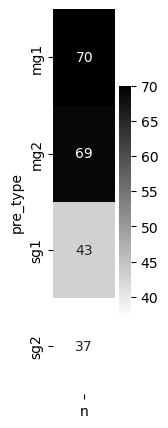

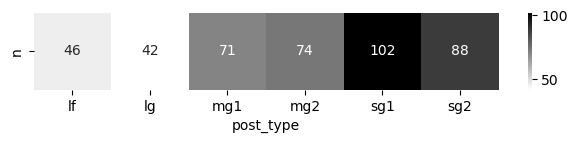

In [154]:
# Calculate the total number of 'pre' nodes for each 'pre_type'
total_pre_nodes = df_edges[mask].groupby('pre_type')['pre'].nunique().reset_index()
total_pre_nodes.loc[:,'number labeled']='n'
total_pre_nodes = total_pre_nodes.pivot(index='pre_type', columns='number labeled', values='pre')

hfig,ax = plt.subplots(1,figsize=(1,5))
sns.heatmap(total_pre_nodes, annot=True, cmap="gray_r", fmt=".0f")
ax.set_xlabel('')

###
# Calculate the total number of 'post' nodes for each 'post_type'
total_post_nodes = df_edges[mask].groupby('post_type')['post'].nunique().reset_index()
total_post_nodes.loc[:,'number reconstructed']='n'
total_post_nodes = total_post_nodes.pivot(index='number reconstructed', columns='post_type', values='post')

hfig,ax = plt.subplots(1,figsize=(7.5,1))
sns.heatmap(total_post_nodes, annot=True, cmap="gray_r", fmt=".0f");
ax.set_ylabel('');
plt.show()

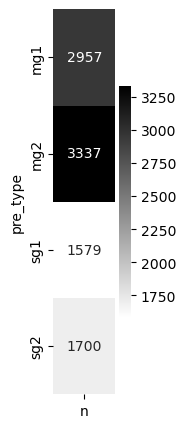

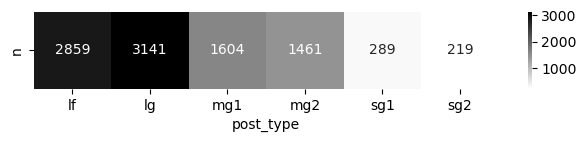

In [155]:
grouped = df_edges.groupby(['pre_type', 'post_type'])['weight'].sum().reset_index()
matrix = grouped.pivot(index='pre_type', columns='post_type', values='weight')#.fillna(0)

### pre
df_pivot = df_edges[mask].groupby('pre_type')['weight'].sum().reset_index()
df_pivot.loc[:,'n']='n'
total_pre_syn = df_pivot.pivot(index='pre_type', columns='n',values='weight')

hfig,ax = plt.subplots(1,figsize=(1,5))
sns.heatmap(total_pre_syn, annot=True, cmap="gray_r", fmt=".0f")
ax.set_xlabel('')

### post
df_pivot = df_edges[mask].groupby('post_type')['weight'].sum().reset_index()
df_pivot.loc[:,'n']='n'
total_post_syn = df_pivot.pivot(index='n', columns='post_type',values='weight')

hfig,ax = plt.subplots(1,figsize=(7.5,1))
sns.heatmap(total_post_syn,annot=True, cmap="gray_r", fmt=".0f");
ax.set_ylabel('');

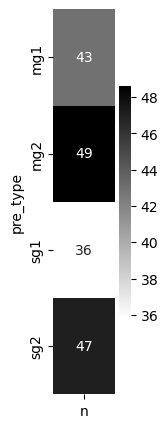

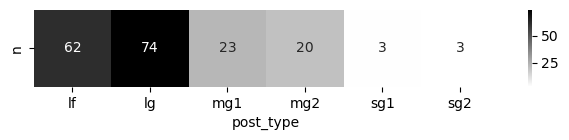

In [203]:
'''mean synapses per cell'''

hfig,ax = plt.subplots(1,figsize=(1,5))
sns.heatmap(total_pre_syn / total_pre_nodes, annot=True, cmap="gray_r", fmt=".0f")
ax.set_xlabel('')

hfig,ax = plt.subplots(1,figsize=(7.5,1))
sns.heatmap(total_post_syn / total_post_nodes,annot=True, cmap="gray_r", fmt=".0f");
ax.set_ylabel('');

In [204]:
df_edges[df_edges['pre_type']=='mg1'].sort_values(['post_type','weight'])

pre       post         y_adj pre_type post_type  weight
261    387909811  636239856  49870.317699      mg1       fov       1
320    387909811   48972165  52368.632532      mg1       fov       1
321    387909811   50210161  45962.931206      mg1       fov       1
322    387909811   50210161  46154.479005      mg1       fov       1
323    387909811   51293106  17272.284882      mg1       fov       1
...          ...        ...           ...      ...       ...     ...
17767  298228381  479170507  50351.664504      mg1        uk       1
17769  298228381  128817684   8222.718051      mg1        uk       1
17785  298228381  128817684   8431.369987      mg1        uk       1
17814  298228381   43992677  55641.515833      mg1        uk       1
33     299496636  131182561  28483.120392      mg1        uk       2

[3857 rows x 6 columns]

<Axes: xlabel='weight', ylabel='Density'>

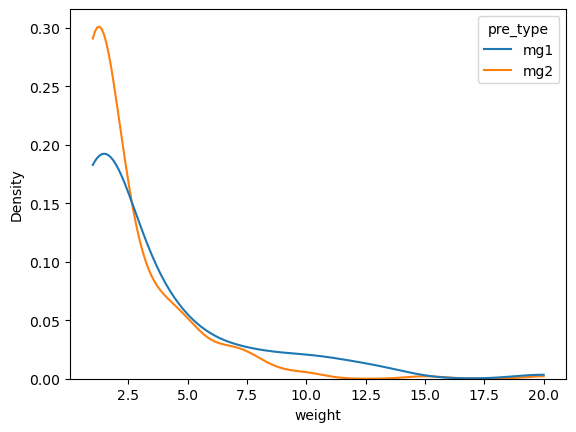

In [88]:
sns.kdeplot(data = df_edges[(df_edges['post_type'].isin(['mg2','mg1'])&df_edges['pre_type'].isin(['mg1','mg2']))], x = 'weight', 
            alpha = 1, hue='pre_type',common_norm=False,cut=0,legend=True)

In [175]:
df_edges[]

pre       post pre_type post_type  weight
2     473631846  305332461      mg2        lg      29
3      41579854  393078033      mg1        lf      29
4     300131090  392814322      mg1        lf      29
5     390294014  652529320      mg2        lf      27
6     213669553  393464000      mg1        lf      21
...         ...        ...      ...       ...     ...
5136  215572949  300459385      mg2       mg1       1
5144  215572949  128737253      mg2       mg1       1
5367  217396339  306738390      mg2        lf       1
5370  217396339  213669553      mg2       mg1       1
5560  217396339  558360429      mg2       mg1       1

[1083 rows x 5 columns]

In [63]:
mask = (df_edges['pre_type'].isin(['aff','grc','smpl','sgx1','sgx2','sg1','sg2'])) & (df_edges['post_type'].isin(['grc','smpl','sgx1','sgx2','sg1','sg2','mg1','mg2','lf','lg']))

<Axes: xlabel='post_type', ylabel='pre_type'>

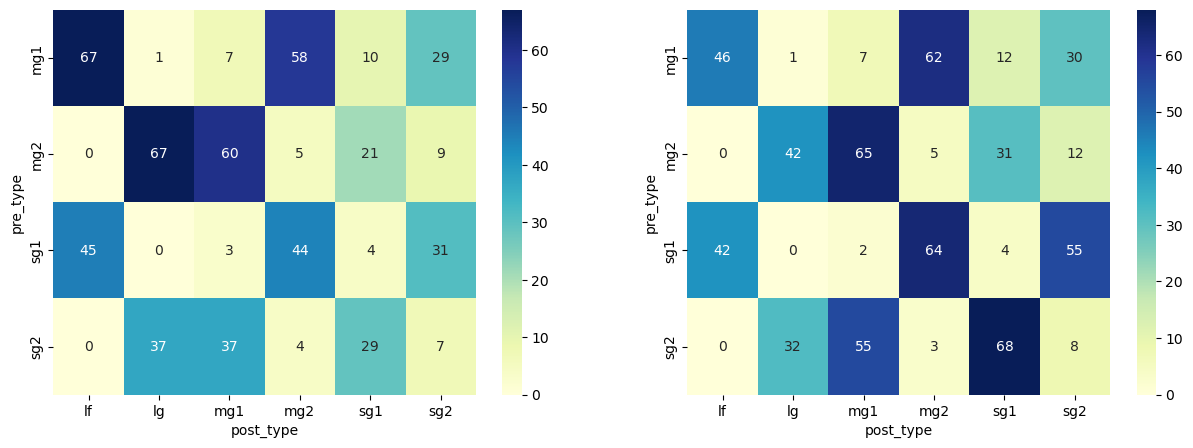

In [205]:
'''
This code does not repeat counting a post cell if more than one pre cell synapses on it
'''
# Calculate the number of 'pre' nodes of each 'pre_type' for each 'post_type'
pre_type_contributions = df_edges[mask].groupby(['pre_type', 'post_type'])['pre'].nunique().unstack(fill_value=0)

# Calculate the number of 'post' nodes of each 'post_type' for each 'pre_type'
post_type_contributions = df_edges[mask].groupby(['pre_type', 'post_type'])['post'].nunique().unstack(fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(pre_type_contributions, annot=True, fmt=".0f", cmap="YlGnBu", ax=axes[0])
sns.heatmap(post_type_contributions, annot=True, fmt=".0f", cmap="YlGnBu", ax=axes[1])

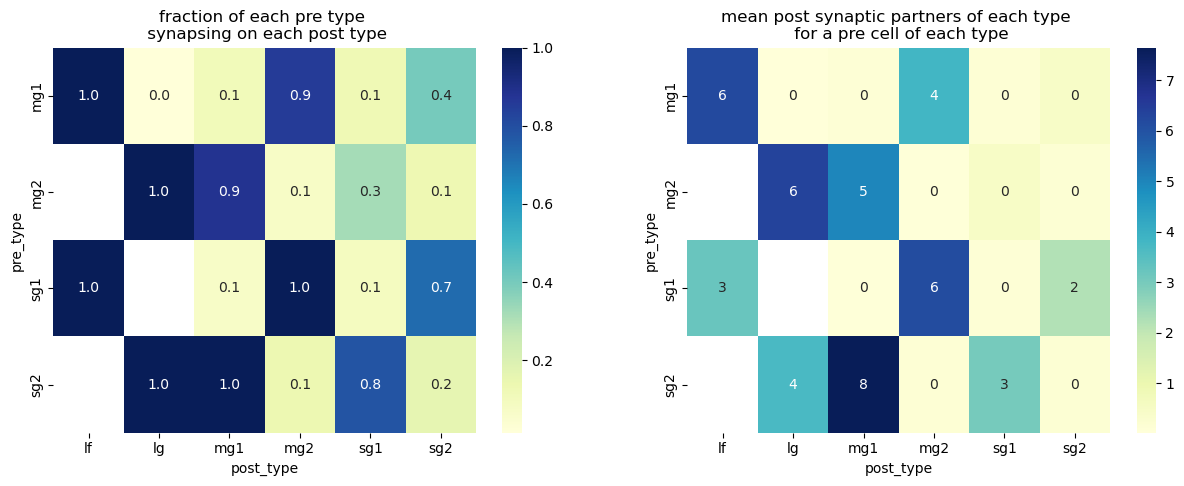

In [156]:
# Calculate the number of edges for each pre-post pair (unique_counts['n_post'])
# Different from the number of unique post nodes
edge_counts = df_edges[mask].groupby(['pre_type', 'post_type','pre'])[['post']].nunique().reset_index().groupby(['pre_type', 'post_type'])['post'].sum().reset_index().rename(columns={'post': 'n_post'})
# The following gives the same as "pre_type_contributions" but with more code: unique_counts['n_pre'] = df_edges.groupby(['pre_type', 'post_type'])[['pre','post']].nunique().reset_index().groupby(['pre_type', 'post_type'])['pre'].sum().reset_index().rename(columns={'pre': 'n_pre'})['n_pre']
pre_counts = df_edges[mask].groupby(['pre_type', 'post_type'])['pre'].nunique().reset_index().rename(columns={'pre': 'n_pre'})
edge_counts['n_pre'] = pre_counts['n_pre']

n_pre_all = [df_edges[mask].groupby(['pre_type'])['pre'].nunique()[p_] for p_ in edge_counts['pre_type']]# unique_counts['pre_type']]

edge_counts['percent_pre'] = edge_counts['n_pre'].div(n_pre_all)
edge_counts['mean_post_count'] = edge_counts['n_post'].div(n_pre_all)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

result_pivot = edge_counts.pivot(index='pre_type', columns='post_type', values='percent_pre')
sns.heatmap(result_pivot, annot=True, fmt=".1f", cmap="YlGnBu", ax = axes[0])

result_pivot = edge_counts.pivot(index='pre_type', columns='post_type', values='mean_post_count')#.fillna(0)
sns.heatmap(result_pivot, annot=True, fmt=".0f", cmap="YlGnBu", ax = axes[1])#,vmax=10)

axes[0].set_title('fraction of each pre type \n synapsing on each post type')
axes[1].set_title('mean post synaptic partners of each type \n for a pre cell of each type');

In [27]:
res.reset_index().pivot(index='pre_type', columns='post_type', values='weight_norm')

post_type   aff   fov  glia  grc-d  grc-s   lg   mg1  mg2  mli    pe   pf  \
pre_type                                                                    
grc-d      46.0  11.0   NaN    NaN    2.0  NaN   NaN  NaN  NaN   NaN  NaN   
grc-s       NaN   3.0   NaN   64.0    1.0  NaN   NaN  1.0  0.0   1.0  NaN   
lf          5.0  32.0   NaN    0.0    7.0  NaN  14.0  NaN  NaN   NaN  NaN   
lg          NaN  17.0   NaN   37.0    0.0  0.0   NaN  8.0  1.0   0.0  0.0   
mg1         NaN  14.0   NaN   23.0    1.0  0.0   NaN  6.0  9.0   8.0  4.0   
mg2         1.0  19.0   NaN    0.0   13.0  NaN   4.0  0.0  8.0   5.0  4.0   
mli         NaN   NaN   NaN    3.0    NaN  NaN   NaN  NaN  6.0  31.0  NaN   
sg1         NaN   2.0   0.0   70.0    NaN  NaN   NaN  NaN  1.0   1.0  NaN   
sg2        11.0   9.0   NaN    NaN   15.0  NaN   NaN  NaN  5.0   5.0  3.0   
sgx2       35.0  19.0   NaN    NaN   16.0  NaN   NaN  NaN  NaN   NaN  NaN   

post_type   sg1   sg2  sgx1  sgx2  tsd    uk  
pre_type                                      
grc-d       1.0   NaN   0.0   NaN  0.0  41.0  
grc-s       5.0   1.0   0.0   0.0  0.0  23.0  
lf         30.0   0.0   8.0   NaN  NaN   4.0  
lg          NaN  30.0   NaN   3.0  NaN   3.0  
mg1         NaN  29.0   NaN   4.0  NaN   2.0  
mg2        33.0   NaN   3.0   0.0  0.0   6.0  
mli         NaN   NaN   NaN   3.0  NaN  56.0  
sg1         NaN   3.0   NaN  14.0  NaN   8.0  
sg2        23.0   NaN  19.0   NaN  NaN  11.0  
sgx2        4.0   NaN   5.0   NaN  NaN  21.0

In [158]:
# row_order = ['grc-d', 'grc-s', 'sg1', 'sg2', 'mg1', 'mg2', 'lg', 'lf']
# col_order = ['aff', 'grc-d', 'grc-s', 'sg1', 'sg2', 'mg1', 'mg2']
# mask_id = df_edges['pre'].isin([387554847,389891998,299496636,214581797])

# mask = df_edges['pre_type'].isin(df_type['type'].unique())#(df_edges['pre_type'].isin(['aff','grc','smpl','sgx1','sgx2','sg1','sg2'])) & 

row_order = ['sg1','mg1','sg2','mg2']#['sg1', 'mg1','lg', 'grc',  'sg2', 'mg2', 'lf']
col_order = ['sg1','mg1','lg','sg2','mg2','lf']#['aff', 'sg1', 'mg1', 'grc','sg2', 'mg2'] #]#
# mask = mask_id & (df_edges['pre_type'].isin(row_order) & df_edges['post_type'].isin(col_order))

res = df_edges[mask].groupby(['pre_type','post_type'])[['weight']].sum(numeric_only=True)#.reset_index()
syn_total = res.groupby('pre_type')['weight'].sum()
n_pre = df_edges[mask].groupby(['pre_type'])['pre'].nunique()#.reset_index()['pre']
n_post = df_edges[mask].groupby(['pre_type'])['post'].nunique()#.reset_index()['pre']

res.loc[:,'weight_norm'] = np.round(res.weight / syn_total *100)
res.loc[:,'weight_per_cell'] = res.weight / n_pre
# res.loc[:,'weight_per_pair'] = res.weight / n_post #* does not work because this is div by all npost, not those in that pairing

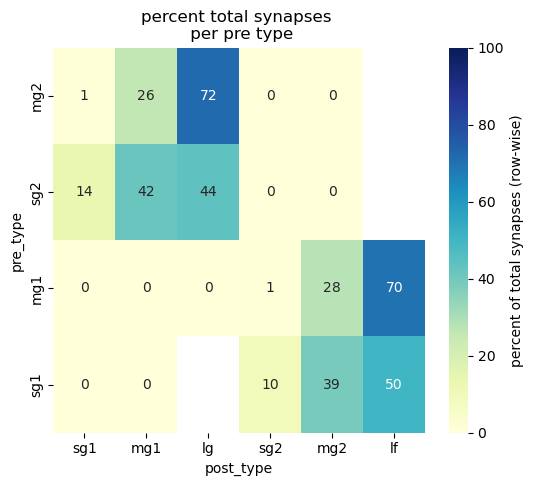

In [159]:
# sns.set(font_scale=1.4)
res_weightnorm = res.reset_index().pivot(index='pre_type', columns='post_type', values='weight_norm')#.columns
res_weightnorm = res_weightnorm.reindex(index=row_order[::-1], columns=col_order)

fig, axes = plt.subplots(1,figsize=(6,5))

sns.heatmap(res_weightnorm,#.fillna(0),
            annot=True,cmap="YlGnBu",vmin=0,vmax=100, ax = axes,
           cbar_kws={'label': 'percent of total synapses (row-wise)'})

# axes[0].set_title('mean synapses per pre cell \n on each post type')
# axes[1].set_title('percent total synapses \n per pre cell');

axes.set_title('percent total synapses \n per pre type');
plt.show()

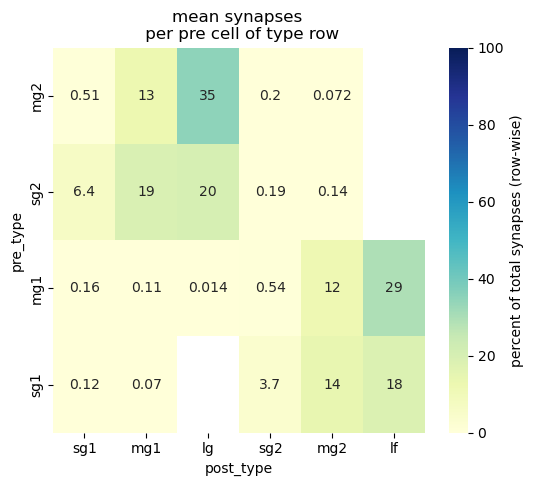

In [160]:
# sns.set(font_scale=1.4)
res_weightnorm = res.reset_index().pivot(index='pre_type', columns='post_type', values='weight_per_cell')#.columns
res_weightnorm = res_weightnorm.reindex(index=row_order[::-1], columns=col_order)

fig, axes = plt.subplots(1,figsize=(6,5))

sns.heatmap(res_weightnorm,#.fillna(0),
            annot=True,cmap="YlGnBu",vmin=0,vmax=100, ax = axes,
           cbar_kws={'label': 'percent of total synapses (row-wise)'})

# axes[0].set_title('mean synapses per pre cell \n on each post type')
# axes[1].set_title('percent total synapses \n per pre cell');

axes.set_title('mean synapses \n per pre cell of type row');
plt.show()

In [210]:
res_weightnorm

post_type   sg1   mg1    lg   sg2   mg2    lf
pre_type                                     
mg2         1.0  26.0  72.0   0.0   0.0   NaN
sg2        14.0  42.0  44.0   0.0   0.0   NaN
mg1         0.0   0.0   0.0   1.0  28.0  70.0
sg1         0.0   0.0   NaN  10.0  39.0  51.0

In [ ]:
# hfig,ax = plt.subplots(1,figsize=(5,2))
fig, axes = plt.subplots(1,2, figsize=(15, 5))
sns.heatmap(res.reset_index().pivot(index='pre_type', columns='post_type', values='weight_per_cell'),#.fillna(0),
            annot=True,cmap="YlGnBu",vmin=0,ax=axes[0], fmt=".0f", #,vmax=100
           cbar_kws={'label': 'mean synapses per target cell'})

res_weightnorm = res.reset_index().pivot(index='pre_type', columns='post_type', values='weight_norm')#.columns


res_weightnorm.reindex(index=row_order, columns=col_order)


sns.heatmap(res_weightnorm,#.fillna(0),
            annot=True,cmap="YlGnBu",vmin=0,vmax=100,ax=axes[1], #
           cbar_kws={'label': 'percent of total synapses (row-wise)'})

# axes[0].set_title('mean synapses per pre cell \n on each post type')
# axes[1].set_title('percent total synapses \n per pre cell');

axes[0].set_title('mean synapses per post cell \n from each pre type')
axes[1].set_title('percent total synapses \n per post cell');


edge_counts = df_edges.groupby(['pre_type', 'post_type','pre'])[['post']].nunique().reset_index().groupby(['pre_type', 'post_type'])['post'].sum().reset_index().rename(columns={'post': 'n_post'})
res.loc[:,'n_edges']=edge_counts['n_post'].values
res.loc[:,'u_edges']=res['weight']/res['n_edges']
fig, axes = plt.subplots(1, figsize=(7, 5))
sns.heatmap(res.reset_index().pivot(index='pre_type', columns='post_type', values='u_edges').fillna(0),
            annot=True,cmap="YlGnBu",vmin=0,ax=axes, fmt=".0f",
           cbar_kws={'label': 'mean synapses per pre-post pair'});
axes.set_title('mean non-zero synapses \n per pre-post connection');

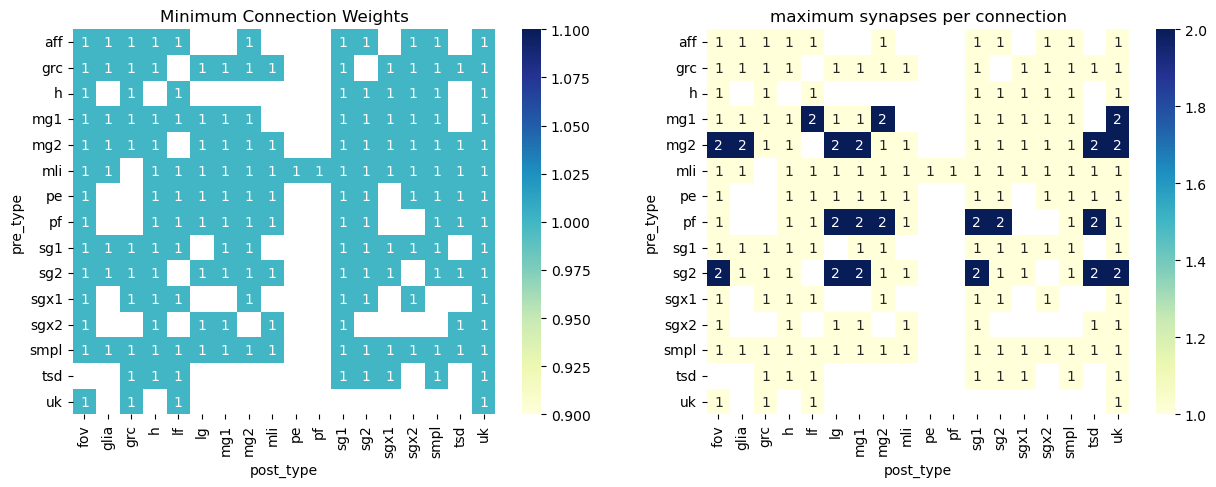

In [161]:

grouped = df_edges.groupby(['pre_type', 'post_type'])['weight'].agg(['mean', 'min', 'max']).reset_index()

# Pivot the DataFrame to get matrices for median, min, and max weights
mean_matrix = grouped.pivot(index='pre_type', columns='post_type', values='mean')
min_matrix = grouped.pivot(index='pre_type', columns='post_type', values='min')
max_matrix = grouped.pivot(index='pre_type', columns='post_type', values='max')

# Create subplots for median, min, and max matrices
fig, axes = plt.subplots(1,2, figsize=(15, 5))

# Set titles for subplots
# axes[2].set_title('mean non-zero synapses \n per pre-post connection');
axes[0].set_title('Minimum Connection Weights')
axes[1].set_title('maximum synapses per connection')

# Plot the heatmaps for median, min, and max matrices
# sns.heatmap(mean_matrix, annot=True, fmt=".0f", cmap="YlGnBu", ax=axes[2])
sns.heatmap(min_matrix, annot=True, fmt=".0f", cmap="YlGnBu", ax=axes[0])
sns.heatmap(max_matrix, annot=True, fmt=".0f", cmap="YlGnBu", ax=axes[1])

# plt.tight_layout()
plt.show();

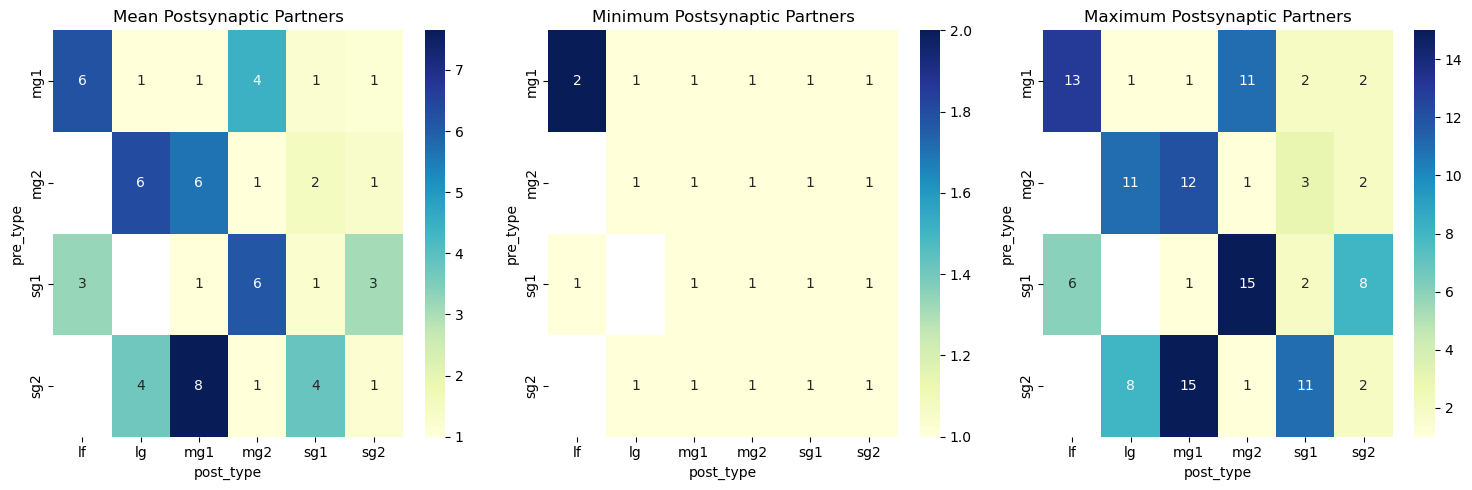

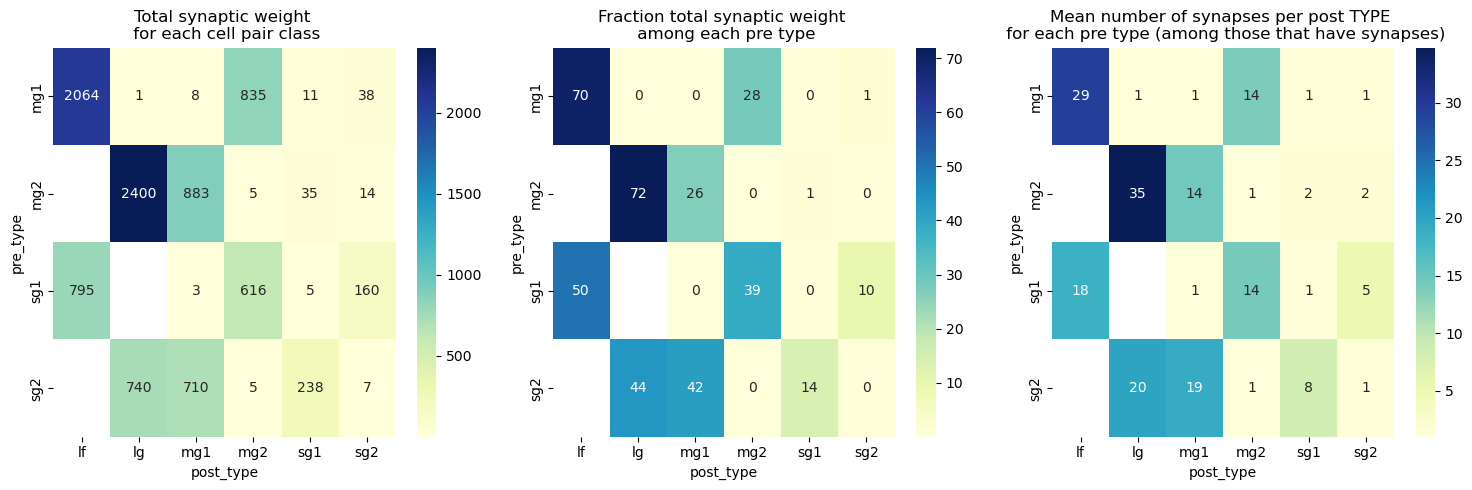

In [163]:
'''
connection partners only among pre cells that synapse on that type
'''

# Calculate the average number of unique 'post' cells for each 'pre_type'
average_counts = df_edges[mask].groupby(['pre_type', 'post_type', 'pre'])['post'].nunique().groupby(['pre_type', 'post_type']).mean().unstack() # average_counts = average_counts.applymap(lambda x: f'{x:.1f}').astype(float)
min_counts = df_edges[mask].groupby(['pre_type', 'post_type', 'pre'])['post'].nunique().groupby(['pre_type', 'post_type']).min().unstack() # min_counts = min_counts.applymap(lambda x: f'{x:.1f}').astype(float)
max_counts = df_edges[mask].groupby(['pre_type', 'post_type', 'pre'])['post'].nunique().groupby(['pre_type', 'post_type']).max().unstack() # max_counts = max_counts.applymap(lambda x: f'{x:.1f}').astype(float)

# Create subplots for median, min, and max matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Set titles for subplots
axes[0].set_title('Mean Postsynaptic Partners')
axes[1].set_title('Minimum Postsynaptic Partners')
axes[2].set_title('Maximum Postsynaptic Partners')

# Plot the heatmaps for median, min, and max matrices
sns.heatmap(average_counts, annot=True, cmap="YlGnBu", ax=axes[0], fmt=".0f")
sns.heatmap(min_counts, annot=True, cmap="YlGnBu", ax=axes[1], fmt=".0f")
sns.heatmap(max_counts, annot=True, cmap="YlGnBu", ax=axes[2], fmt=".0f")

plt.tight_layout()
# plt.show();

grouped = df_edges[mask].groupby(['pre_type', 'post_type'])['weight'].sum().reset_index()

# Pivot the DataFrame to get the desired matrix
matrix = grouped.pivot(index='pre_type', columns='post_type', values='weight')#.fillna(0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.heatmap(matrix, annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[0])

matrix_normalized = matrix.div(matrix.sum(axis=1), axis=0).div(0.01)
sns.heatmap(matrix_normalized, annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[1])

average_weight = df_edges[mask].groupby(['pre_type', 'post_type', 'pre'])['weight'].sum().groupby(['pre_type', 'post_type']).mean().unstack() # average_counts = average_counts.applymap(lambda x: f'{x:.1f}').astype(float)
sns.heatmap(average_weight, annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[2])

# Set titles for subplots
axes[0].set_title('Total synaptic weight \n for each cell pair class')
axes[1].set_title('Fraction total synaptic weight \n among each pre type')
axes[2].set_title('Mean number of synapses per post TYPE \n for each pre type (among those that have synapses)')

plt.tight_layout();

## As stacked bar

In [71]:
syn_colors = {
    'sgx1':'#00b2b2', #'#996633',
    'sgx2':'#b27300',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc':'#ffc0cb',
    'smpl':'#e6e600',
    'mli':'#e6e6e6',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#BB00FF',
    'lf':'#FF00BC',
    'aff':'#00ff00',
    'tsd':'#ccccff',
    'uk':'#999999',
    'fov':'#000000',
    'focal types':'#33cc33',
    'pf':'#880088',
    'pe':'#550055',
    'glia':'#666666',
    'h':'#888888'
}
  

syn_hatch = {
    'sgx1':'', #'#996633',
    'sgx2':'',
    'sg1':'',
    'sg2':'',
    'grc-d':'',
    'grc-s':'',
    'mli':'',
    'mg1':'',
    'mg2':'',
    'lg':'',
    'lf':'',
    'aff':'/',
    'tsd':'',
    'uk':'',
    'fov':'',
    'focal types':'',
    'pf':'x',
    'pe':'0',
    'glia':'*'
}

In [554]:
df_edges.groupby(['post_type'])[['post']].nunique() #sum(numeric_only=True)

post
post_type      
fov         586
glia        108
grc         231
h             5
lf           43
lg           40
mg1          59
mg2          56
mli         187
pe            1
pf            2
sg1         201
sg2         131
sgx1         45
sgx2         30
smpl         59
tsd          67
uk          378

In [102]:
matrix_normalized

post_type        fov      glia        grc         h         lf         lg  \
pre_type                                                                    
aff         4.276316  0.986842  66.776316  0.000000   5.921053   0.000000   
grc         9.452202  0.107411   0.107411  0.000000   0.000000   9.989259   
h           0.961538  0.000000  60.576923  0.000000   5.769231   0.000000   
mg1        11.487384  1.261620   0.166003  0.066401  53.054449   0.033201   
mg2        14.922813  2.315609   0.200114  0.000000   0.000000  53.173242   
mli         9.248555  0.144509   0.000000  0.144509   7.803468   8.236994   
pe          9.821429  0.000000   0.000000  0.000000   5.059524   0.595238   
pf         22.016807  0.000000   0.000000  0.168067   5.210084   6.218487   
sg1        19.512195  0.000000   0.000000  0.609756  34.146341   0.000000   
sg2        12.471655  0.907029   0.453515  0.000000   0.000000  25.850340   
sgx1        2.487562  0.000000   0.497512  0.000000  29.850746   0.000000   
sgx2        6.040268  0.000000   0.000000  0.000000   0.000000  16.778523   
smpl        1.167883  0.291971   0.583942  0.145985  19.416058   0.145985   
tsd         0.000000  0.000000  47.058824  0.000000   7.843137   0.000000   
uk          0.000000  0.000000  75.000000  0.000000  17.857143   0.000000   

post_type        mg1        mg2        mli        pe        pf        sg1  \
pre_type                                                                    
aff         0.000000   2.302632   0.000000  0.000000  0.000000   0.000000   
grc         2.148228   0.107411   0.537057  0.000000  0.000000  37.916219   
h           0.000000   0.000000   0.000000  0.000000  0.000000   9.615385   
mg1         0.166003  21.513944   0.000000  0.000000  0.000000   0.332005   
mg2        16.609491   0.114351   0.028588  0.000000  0.000000   1.086335   
mli         8.815029  11.994220  12.283237  0.144509  0.289017  14.884393   
pe          4.166667  17.559524  17.559524  0.000000  0.000000   4.464286   
pf         13.781513  11.428571  21.512605  0.000000  0.000000   6.554622   
sg1         0.000000  27.439024   0.000000  0.000000  0.000000   0.000000   
sg2        32.653061   0.000000   0.000000  0.000000  0.000000  14.965986   
sgx1        0.000000   8.457711   0.000000  0.000000  0.000000   0.995025   
sgx2       10.738255   0.000000   0.671141  0.000000  0.000000  36.912752   
smpl        0.729927  17.664234  10.656934  0.000000  0.000000   1.021898   
tsd         0.000000   0.000000   0.000000  0.000000  0.000000   7.843137   
uk          0.000000   0.000000   0.000000  0.000000  0.000000   0.000000   

post_type        sg2      sgx1       sgx2      smpl        tsd         uk  
pre_type                                                                   
aff         5.592105  0.000000   2.960526  0.328947   0.000000  10.855263  
grc         0.000000  9.667025   0.107411  6.444683  15.789474   7.626208  
h           6.730769  2.884615  10.576923  0.000000   0.000000   2.884615  
mg1         1.593625  0.132802   0.265604  0.166003   0.033201   9.727756  
mg2         0.400229  0.085763   0.085763  0.057176   5.688965   5.231561  
mli         6.936416  0.289017   0.000000  0.722543   2.745665  15.317919  
pe         21.428571  0.297619   0.000000  2.083333   9.226190   7.738095  
pf          2.352941  0.000000   0.000000  0.336134   4.033613   6.386555  
sg1        10.975610  0.000000   0.609756  3.353659   0.000000   3.353659  
sg2         0.680272  0.453515   0.000000  0.453515   9.070295   2.040816  
sgx1       40.796020  0.000000   3.980100  0.000000   0.000000  12.935323  
sgx2        0.000000  0.000000   0.000000  0.000000  24.161074   4.697987  
smpl       30.364964  0.583942   3.065693  0.145985   0.291971  13.722628  
tsd         9.803922  5.882353   0.000000  9.803922   0.000000  11.764706  
uk          0.000000  0.000000   0.000000  0.000000   0.000000   7.142857

In [123]:
df_type['type'].unique()

array(['fov', 'mli', 'uk', 'pe', 'pf', 'tsd', 'mg1', 'mg2', 'glia', 'sg2',
       'sg1', 'sgx2', 'lg', 'smpl', 'sgx1', 'lf', 'grc', 'aff', 'pfm',
       'h', 'UK'], dtype=object)

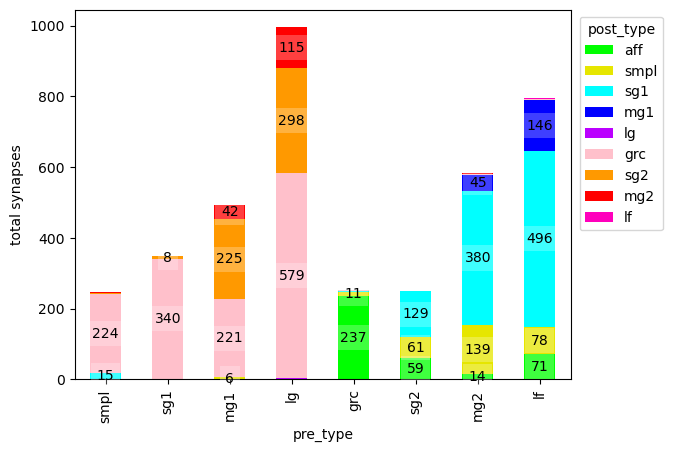

In [75]:
dsource = 'pre_type'
dtarget = 'post_type'

source_order = ['smpl','sg1','mg1', 'lg','grc','sg2', 'mg2', 'lf']#['aff','sg1', 'grc', 'sg2'] 
target_order = [ 'aff','smpl','sg1','mg1', 'lg','grc','sg2', 'mg2', 'lf']# ['sg1', 'mg1', 'lg','grc', 'sg2', 'mg2', 'lf'] #['aff','sg1', 'mg1',  'grc', 'sg2', 'mg2']

mask = df_edges[dsource].isin(df_type['type'].unique())#(df_edges['pre_type'].isin(['aff','grc','smpl','sgx1','sgx2','sg1','sg2'])) & (df_edges['post_type'].isin(['grc','smpl','sgx1','sgx2','sg1','sg2','mg1','mg2','lf','lg']))

res = df_edges[mask].groupby([dsource,dtarget])[['weight']].sum(numeric_only=True)#.reset_index()
syn_total = res.groupby(dsource)['weight'].sum()
n_pre = df_edges[mask].groupby([dsource])[dtarget.split('_')[0]].nunique()#.reset_index()['pre']
n_post = df_edges[mask].groupby([dsource])[dsource.split('_')[0]].nunique()#.reset_index()['pre']

res.loc[:,'weight_norm'] = res.weight / syn_total *100
matrix_normalized = res.reset_index().pivot(index=dsource, columns=dtarget, values='weight').fillna(0) #weight_norm


ax = matrix_normalized.loc[source_order,target_order].plot.bar(stacked=True,color = syn_colors)#, hatch=[syn_hatch[v] for v in order_post])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height >= 5:
        t = ax.text(x+width/2, 
                y+height/2, 
                f'{height:.0f}', 
                horizontalalignment='center', 
                verticalalignment='center')
        t.set_bbox(dict(facecolor='white', alpha=0.25, edgecolor = 'None'))
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.2, 1))

ax.set_ylabel('total synapses')

plt.show()

In [35]:
matrix_normalized

post_type        aff        fov      grc-d      grc-s        mg1       mg2  \
pre_type                                                                     
grc-d      39.534884   5.813953   0.000000   0.000000   0.000000  0.000000   
grc-s       0.000000   1.968504  63.779528   0.393701   0.000000  0.000000   
lf          5.281690  24.471831   0.352113   7.042254  15.140845  0.000000   
mg1         0.000000  17.782427  23.430962   0.000000   0.000000  8.158996   
mg2         1.030928  20.446735   0.343643   6.872852   8.591065  0.171821   
sg2         7.239819   6.334842   0.000000  21.719457   0.000000  0.000000   

post_type       mli        pe        pf        sg1        sg2       sgx1  \
pre_type                                                                   
grc-d      0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
grc-s      0.393701  1.181102  0.000000   5.511811   0.000000   0.393701   
lf         0.000000  0.000000  0.000000  28.521127   0.000000   6.866197   
mg1        9.414226  7.322176  4.811715   0.000000  20.502092   0.000000   
mg2        5.326460  2.061856  0.343643  34.020619   0.000000   0.859107   
sg2        9.502262  8.597285  5.429864  14.027149   0.000000  10.859729   

post_type      sgx2       tsd         uk  
pre_type                                  
grc-d      0.000000  0.000000  54.651163  
grc-s      0.000000  0.000000  26.377953  
lf         0.000000  0.000000  12.323944  
mg1        2.719665  0.000000   5.857741  
mg2        0.000000  0.171821  19.759450  
sg2        0.000000  0.000000  16.289593

In [76]:
columns_to_combine=['mg1','mg2','lg','lf','smpl','grc', 'sg1', 'sg2','aff']#['aff''lf', 'lg'] #
df_combined_col = deepcopy(matrix_normalized)
df_combined_col['focal types'] = df_combined_col[columns_to_combine].sum(axis=1)

# Drop the specified columns
df_combined_col.drop(columns=columns_to_combine,inplace=True)

In [77]:
df_combined_col

post_type    fov     h    mli    pe    pf   sgx1  sgx2  tsd     uk  \
pre_type                                                             
grc        122.0   9.0    0.0   0.0   0.0   13.0   0.0  1.0  233.0   
h            4.0   0.0    0.0   0.0   0.0    0.0   0.0  0.0    1.0   
lf         428.0  23.0    0.0   0.0   0.0  101.0   0.0  1.0   80.0   
lg         197.0   0.0   39.0   3.0   2.0    0.0  53.0  0.0   27.0   
mg1        136.0   0.0   75.0  65.0  30.0    0.0  29.0  0.0   24.0   
mg2        216.0   2.0  114.0  61.0  50.0   32.0   1.0  1.0   61.0   
mli          0.0   0.0    2.0  11.0   0.0    0.0   1.0  0.0   17.0   
sg1         19.0   1.0   19.0  14.0  18.0    0.0  39.0  0.0   35.0   
sg2         34.0   3.0    4.0  14.0   3.0   50.0   0.0  1.0   20.0   
sgx2        47.0   3.0    1.0   0.0   0.0    7.0   0.0  2.0   31.0   
smpl        13.0   0.0    1.0   3.0   0.0    1.0   1.0  1.0   72.0   

post_type  focal types  
pre_type                
grc              252.0  
h                 24.0  
lf               794.0  
lg               995.0  
mg1              494.0  
mg2              582.0  
mli                1.0  
sg1              349.0  
sg2              249.0  
sgx2              78.0  
smpl             247.0

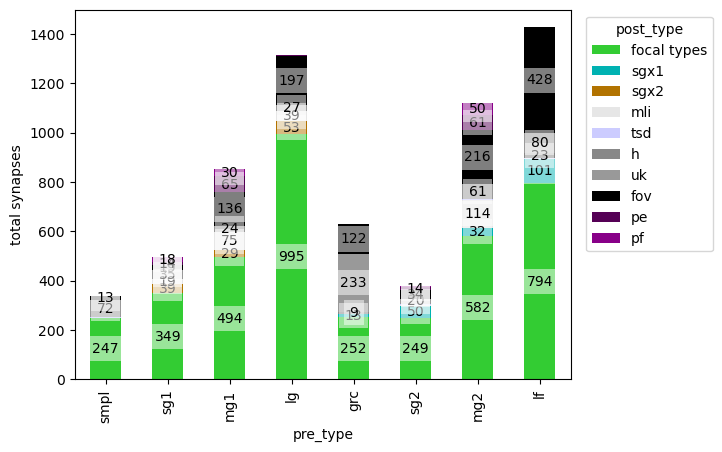

In [79]:
order_pre = ['smpl','sg1','mg1','lg', 'grc', 'sg2','mg2','lf']#['aff','grc','sg1','sg2'] #['mg1','mg2']#
order_post = ['focal types', 'sgx1', 'sgx2', 'mli','tsd','h','uk','fov','pe','pf']#,'glia']

ax = df_combined_col.loc[order_pre,order_post].plot.bar(stacked=True,color = syn_colors)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height >= 5:
        t = ax.text(x+width/2, 
                y+height/2, 
                f'{height:.0f}', 
                horizontalalignment='center', 
                verticalalignment='center')
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor = 'None'))
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
ax.set_ylabel('total synapses');
plt.show()

In [197]:
matrix_normalized.index

Index(['grc-d', 'grc-s', 'lf', 'lg', 'mg1', 'mg2', 'mli', 'sg1', 'sg2',
       'sgx2'],
      dtype='object', name='pre_type')

# divergence and convergence

## post synaptic

In [22]:
cell_color = {'aff':'#568D00',
             'lg':'#BB00FF',
              'lf':'#FF00BC',
              'mg1':'#0000FF',
              'mg2':'#FF0000',
              'pf':'#3F3F3F'
             }

In [23]:
desired_combinations = [
    ('mg1', 'mg2'),
    ('mg1', 'lf'),
    ('mg2', 'mg1'),
    ('mg2', 'lg')
]
# filtered_df = df_edges[df_edges[['pre_type', 'post_type']].apply(tuple, axis=1).isin(desired_combinations)]


In [26]:
# list(filtered_df.groupby(['pre_type','pre']))

# Initialize an empty DataFrame to store the results
divergence_counts = pd.DataFrame(columns=['pre_type', 'post_type', 'pre', 'divergence_count'])

# Iterate over each desired combination
for pre_type, post_type in desired_combinations:
    # Filter the DataFrame for the current combination
    subset_df = df_edges[(df_edges['pre_type'] == pre_type) & (df_edges['post_type'] == post_type)]
    
    # Group by pre and count unique post cells for each pre cell
    # subset_divergence_counts = subset_df.groupby(['pre_type', 'pre'])['post'].nunique().reset_index()
    # subset_divergence_counts.rename(columns={'post': 'divergence_count'}, inplace=True)

    # Group by pre and count synapse total for each pre cell
    subset_divergence_counts = subset_df.groupby(['pre_type', 'pre'])['weight'].sum().reset_index()
    subset_divergence_counts.rename(columns={'weight': 'divergence_count'}, inplace=True)
    
    # Add pre_type and post_type columns
    subset_divergence_counts['post_type'] = post_type
    
    # Append the subset DataFrame to the results DataFrame
    divergence_counts = pd.concat([divergence_counts, subset_divergence_counts])

# Display the resulting DataFrame
divergence_counts.head()
divergence_counts[divergence_counts['divergence_count'] != 0]

pre_type post_type        pre divergence_count
0       mg1       mg2   42632020               29
1       mg1       mg2   44548558                4
2       mg1       mg2  126618353               18
3       mg1       mg2  127870654               29
4       mg1       mg2  128737253                1
..      ...       ...        ...              ...
45      mg2        lg  642458763               27
46      mg2        lg  644823522               20
47      mg2        lg  644824766               30
48      mg2        lg  646634295               50
49      mg2        lg  647809492               64

[193 rows x 4 columns]

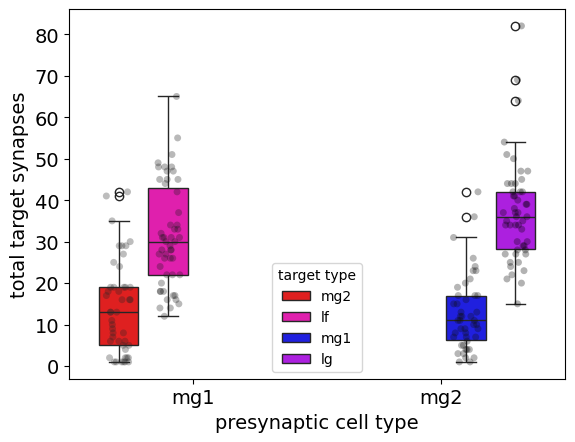

In [32]:

ax = sns.boxplot(data=divergence_counts,x = 'pre_type',y='divergence_count',hue='post_type',palette=cell_color,dodge=True,gap=0.2)#,k_depth='full')
sns.stripplot(ax = ax, data=divergence_counts,x = 'pre_type',y='divergence_count',hue='post_type',dodge=True,jitter=0.2,alpha=0.3,legend=False,palette='dark:black')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

leg = ax.axes.get_legend()
leg.set_title('target type')

# ax.set_ylabel('number of target cells')
ax.set_ylabel('total target synapses')
ax.set_xlabel('presynaptic cell type')

plt.savefig('/Users/kperks/Downloads/divergence_weight.svg') 

In [292]:
df_edges

pre       post pre_type post_type  weight
0     306461085  301863996      sg2        lg      32
1     130781211  215526370      sg2        lg      32
2     300131090  392814322      mg1        lf      29
3      41579854  393078033      sg1        lf      29
4     473631846  305332461      mg2        lg      29
...         ...        ...      ...       ...     ...
6419  299589324   45356019      sg1       sg2       1
6420  299530386  654448841      mg1        uk       1
6421  299530386  652159066      mg1       fov       1
6422  299530386  652128578      mg1       fov       1
6423  649572893  649510440      sg2       fov       1

[6424 rows x 5 columns]

In [29]:
# list(filtered_df.groupby(['pre_type','pre']))

# Initialize an empty DataFrame to store the results
convergence_counts = pd.DataFrame(columns=['pre_type', 'post_type', 'post', 'convergence_count'])

# Iterate over each desired combination
for pre_type, post_type in desired_combinations:
    # Filter the DataFrame for the current combination
    subset_df = df_edges[(df_edges['pre_type'] == pre_type) & (df_edges['post_type'] == post_type)]
    
    # # Group by pre and count unique post cells for each pre cell
    # subset_convergence_counts = subset_df.groupby(['pre_type', 'post'])['pre'].nunique().reset_index()
    # subset_convergence_counts.rename(columns={'pre': 'convergence_count'}, inplace=True)

    # Group by pre and count synapse total for each pre cell
    subset_convergence_counts = subset_df.groupby(['pre_type', 'post'])['weight'].sum().reset_index()
    subset_convergence_counts.rename(columns={'weight': 'convergence_count'}, inplace=True)
    
    # Add pre_type and post_type columns
    subset_convergence_counts['post_type'] = post_type
    
    # Append the subset DataFrame to the results DataFrame
    convergence_counts = pd.concat([convergence_counts, subset_convergence_counts])

# Display the resulting DataFrame
convergence_counts.head()
convergence_counts[convergence_counts['convergence_count'] != 0]

pre_type post_type       post convergence_count
0       mg1       mg2   40448913                 5
1       mg1       mg2   40665046                 3
2       mg1       mg2   41825714                 7
3       mg1       mg2   42769344                 7
4       mg1       mg2   45727047                 7
..      ...       ...        ...               ...
35      mg2        lg  645210795                 9
36      mg2        lg  647112371                29
37      mg2        lg  647640784                11
38      mg2        lg  650161520                42
39      mg2        lg  652529320                60

[183 rows x 4 columns]

In [30]:
convergence_counts[(convergence_counts['pre_type'].isin(['mg1','mg2'])) & (convergence_counts['post_type'].isin(['lg','lf']))].sort_values('convergence_count')

pre_type post_type       post convergence_count
29      mg1        lf  397396859                 1
8       mg2        lg  131737545                 1
33      mg1        lf  485096532                 3
6       mg1        lf   50677331                 3
29      mg2        lg  560046380                 3
..      ...       ...        ...               ...
10      mg2        lg  214503199               101
24      mg1        lf  393325331               112
26      mg2        lg  476044282               112
21      mg2        lg  305332461               113
12      mg2        lg  215526370               121

[82 rows x 4 columns]

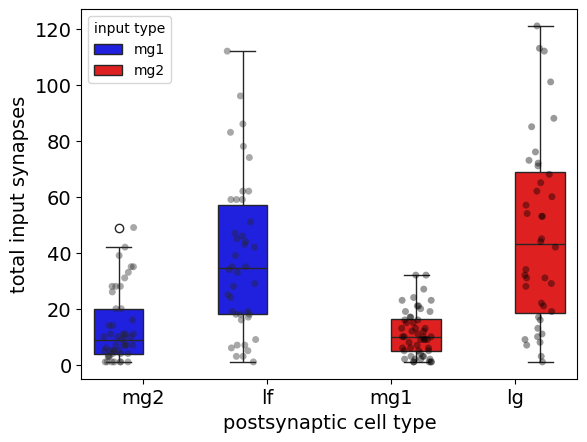

In [33]:

ax = sns.boxplot(data=convergence_counts,x = 'post_type',y='convergence_count',hue='pre_type',palette=cell_color,dodge=0.5)
sns.stripplot(ax = ax, data=convergence_counts,x = 'post_type',y='convergence_count',hue='pre_type',dodge=True,jitter=0.25,alpha=0.4,legend=False,palette='dark:black')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

leg = ax.axes.get_legend()
leg.set_title('input type')

# ax.set_ylabel('number of input cells')
ax.set_ylabel('total input synapses')
ax.set_xlabel('postsynaptic cell type')

plt.savefig('/Users/kperks/Downloads/convergence_weight.svg') 

## pre synaptic

In [834]:

syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc':'#33cc33',
    'smpl':'#e6e600',
    'dml':'#cccccc',
    'mli':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#737373',
    'pe':'#550055',
    'pf':'#880088'
}

In [465]:
df_progress[(df_progress['type'].isin(['lg']))].sort_values('todo').head(100) 

id   type n_syn done todo  completed
0  565013265  grc-s    70   70    0   1.000000
0  389812730  grc-s    80   80    0   1.000000
0  392042360  grc-s    57   57    0   1.000000
0  305051491  grc-s    51   47    4   0.921569
0  306242528  grc-s    47   29   18   0.617021
0   45120720  grc-s    25    3   22   0.120000
0  307621813  grc-s    48    5   43   0.104167
0  219161561  grc-s    90   25   65   0.277778

In [105]:
pre_list = ['mg1','mg2','sg1','sg2','grc-d','grc-s','lg','lf']
post_list = ['aff','grc-s','sg1','mg1','grc-d','sg2','mg2']
desired_combinations = [(pre, post) for pre in pre_list for post in post_list]

# filtered_df = df_edges[df_edges[['pre_type', 'post_type']].apply(tuple, axis=1).isin(desired_combinations)]
example_mask = (df_edges['pre'].isin([214581797,299496636,218095913,385434515,306461085,128832297,387554847,393325331,301787806,226019332,223881844,482680782,565013265,389812730,392042360])) #214581797

In [106]:
divergence_counts = pd.DataFrame(columns=['pre_type', 'post_type', 'pre', 'divergence_count'])
# Iterate over each desired combination
for pre_type, post_type in desired_combinations:
    # Filter the DataFrame for the current combination
    subset_df = df_edges[example_mask&(df_edges['pre_type'] == pre_type) & (df_edges['post_type'] == post_type)]
    if len(subset_df)==0:
        subset_divergence_counts = pd.DataFrame({'pre_type':pre_type,
                                                 'post_type':post_type,
                                                 'pre':df_edges[example_mask&(df_edges['pre_type'] == pre_type)]['pre'].unique(),
                                                 'divergence_count':0})    
    # Group by pre and count unique post cells for each pre cell

    else:
        subset_divergence_counts = subset_df.groupby(['pre_type', 'pre'])['post'].nunique().reset_index()
        subset_divergence_counts.rename(columns={'post': 'divergence_count'}, inplace=True)
        
        # Group by pre and count synapse total for each pre cell
        subset_divergence_counts = subset_df.groupby(['pre_type', 'pre'])['weight'].sum().reset_index()
        subset_divergence_counts.rename(columns={'weight': 'divergence_count'}, inplace=True)
        
        # Add pre_type and post_type columns
        subset_divergence_counts['post_type'] = post_type

    # Append the subset DataFrame to the results DataFrame
    divergence_counts = pd.concat([divergence_counts, subset_divergence_counts])

# Display the resulting DataFrame
divergence_counts.head()
# divergence_counts[divergence_counts['divergence_count'] != 0]

pre_type post_type        pre divergence_count
0      mg1       aff  299496636                0
0      mg1     grc-s  299496636                0
0      mg1       sg1  299496636                0
0      mg1       mg1  299496636                0
0      mg1     grc-d  299496636              111

In [107]:
divergence_counts['post_type_cat'] = pd.Categorical(divergence_counts['post_type'], categories=post_list, ordered=True)

# Sort the DataFrame based on the categorical 'x' column
sorted_data = divergence_counts.sort_values(by='post_type_cat')

In [111]:
sorted_data[sorted_data['pre_type'].isin(['grc-s'])]#['pre'].unique()

pre_type post_type        pre divergence_count post_type_cat
2    grc-s       aff  392042360                0           aff
1    grc-s       aff  389812730                0           aff
0    grc-s       aff  565013265                0           aff
0    grc-s     grc-s  565013265                1         grc-s
0    grc-s       sg1  389812730                2           sg1
1    grc-s       sg1  565013265                2           sg1
0    grc-s       mg1  565013265                0           mg1
1    grc-s       mg1  389812730                0           mg1
2    grc-s       mg1  392042360                0           mg1
0    grc-s     grc-d  389812730               57         grc-d
1    grc-s     grc-d  392042360               49         grc-d
2    grc-s     grc-d  565013265               41         grc-d
0    grc-s       sg2  565013265                0           sg2
1    grc-s       sg2  389812730                0           sg2
2    grc-s       sg2  392042360                0           sg2
2    grc-s       mg2  392042360                0           mg2
1    grc-s       mg2  389812730                0           mg2
0    grc-s       mg2  565013265                0           mg2

Text(0, 0.5, 'total synapses per postsynaptic cell')

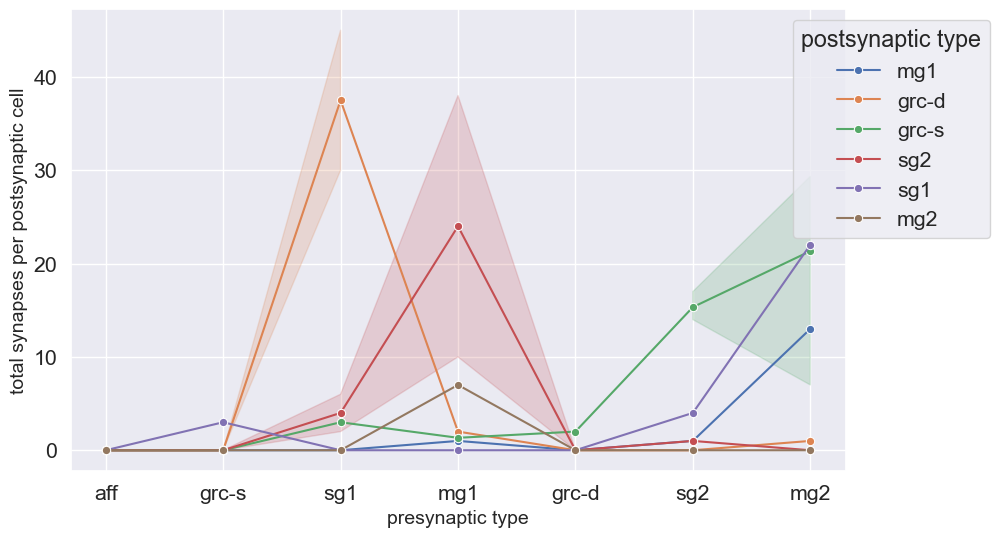

In [672]:
hfig,ax = plt.subplots(figsize=(10,6))
# Convert 'x' column to categorical with desired order
# divergence_counts['post_type_cat'] = pd.Categorical(divergence_counts['post_type'], categories=post_list, ordered=True)

# # Sort the DataFrame based on the categorical 'x' column
# sorted_data = divergence_counts.sort_values(by='post_type_cat')

g = sns.lineplot(ax=ax,data = sorted_data, x='post_type',y='divergence_count',hue='pre_type', marker='o')
# g = sns.stripplot(ax=ax,data=divergence_counts, x='post_type',y='divergence_count',jitter=0.15,
#               hue='pre_type',size=10,alpha=1,linewidth=1,order = post_list,palette = syn_colors)
ax.get_legend().set_title('postsynaptic type')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.2, 1))
ax.set_xlabel('presynaptic type',fontsize=14)
ax.set_ylabel('total synapses per postsynaptic cell',fontsize=14)
# g.set_yticklabels(g.get_yticks(), size = 14);
# g.set_xticklabels(fontsize = 14);

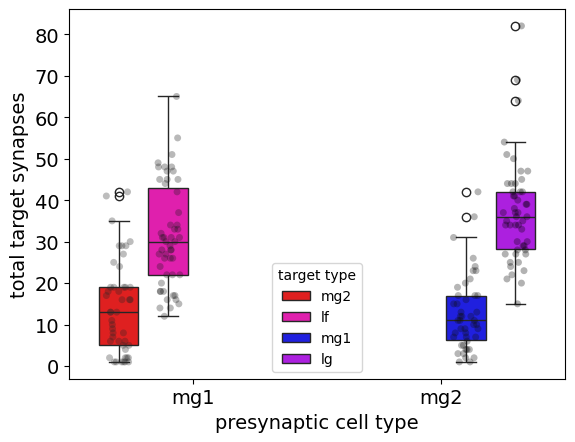

In [32]:

ax = sns.boxplot(data=divergence_counts,x = 'pre_type',y='divergence_count',hue='post_type',palette=cell_color,dodge=True,gap=0.2)#,k_depth='full')
sns.stripplot(ax = ax, data=divergence_counts,x = 'pre_type',y='divergence_count',hue='post_type',dodge=True,jitter=0.2,alpha=0.3,legend=False,palette='dark:black')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

leg = ax.axes.get_legend()
leg.set_title('target type')

# ax.set_ylabel('number of target cells')
ax.set_ylabel('total target synapses')
ax.set_xlabel('presynaptic cell type')

plt.savefig('/Users/kperks/Downloads/divergence_weight.svg') 

# shared input

In [314]:
# Initialize an empty DataFrame to store the results
# shared_input_df = pd.DataFrame(columns=['post1', 'post2', 'shared_input', 'distance', 'post_type'])
shared_input_results = []

desired_combinations = [
    ('mg1', 'mg2'),
    ('mg1', 'lf'),
    ('mg2', 'mg1'),
    ('mg2', 'lg')
]
for pre_type, post_type in desired_combinations:
    # Group the DataFrame by 'post_type'
    subset_df = df_edges[(df_edges['pre_type'] == pre_type) & (df_edges['post_type'] == post_type)]
    grouped = subset_df.groupby('post_type')

    # Iterate over each group
    for post_type, group in grouped:
        # Get all unique combinations of 'post' cells
        post_combinations = combinations(group['post'].unique(), 2)
        
        # Iterate over each pair of 'post' cells
        for post1, post2 in post_combinations:
            # Find the common 'pre' cells for the current pair
            shared_input = len(set(group[group['post'] == post1]['pre']).intersection(group[group['post'] == post2]['pre']))
            distance = pairwise_distances(df_soma, target_ids = ['id',[post2]], dimensions = ['x','y','z'], source_ids = ['id',[post1]])
            
            # Append the result to the DataFrame
            # shared_input_df = shared_input_df.append({'post1': post1, 'post2': post2, 'shared_input': shared_input, 'distance': distance, 'post_type': post_type}, ignore_index=True)
            shared_input_results.append({'post1': post1, 'post2': post2, 'shared_input': shared_input, 'distance': distance[0]/1000, 'post_type': post_type})

# Create the DataFrame from the list
shared_input_df = pd.DataFrame(shared_input_results)    
# Display the resulting DataFrame
shared_input_df.head()

post1      post2  shared_input    distance post_type
0  216129202  301339154             0  297.717008       mg2
1  216129202  213605530             4  102.594803       mg2
2  216129202  558254086             1  123.103077       mg2
3  216129202  299404889             2  147.606389       mg2
4  216129202  214581797             0  183.018886       mg2

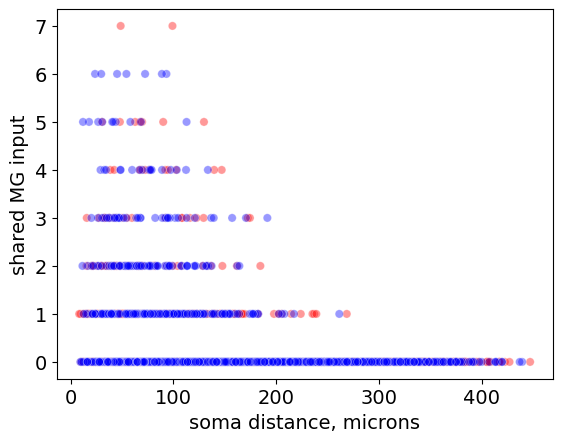

In [327]:
ax = sns.scatterplot(data = shared_input_df[shared_input_df['post_type'].isin(['mg1','mg2'])],x='distance',y='shared_input',alpha = 0.4,hue='post_type',palette=cell_color,legend=False)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

ax.set_ylabel('shared MG input')
ax.set_xlabel('soma distance, microns')

plt.savefig('/Users/kperks/Downloads/shared_input_mg.svg') 

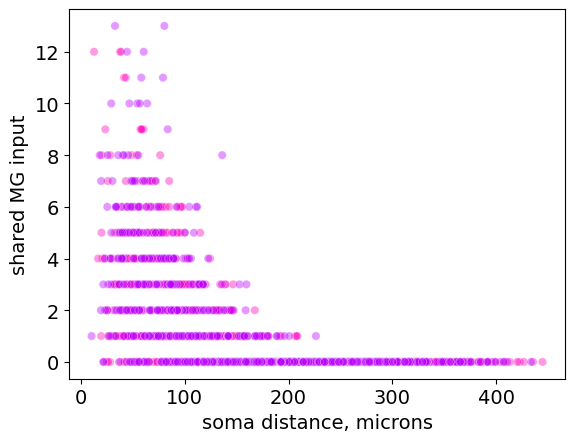

In [328]:
ax = sns.scatterplot(data = shared_input_df[shared_input_df['post_type'].isin(['lg','lf'])],x='distance',y='shared_input',alpha = 0.4,hue='post_type',palette=cell_color,legend=False)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

ax.set_ylabel('shared MG input')
ax.set_xlabel('soma distance, microns')


plt.savefig('/Users/kperks/Downloads/shared_input_out.svg') 

# cell variability among most completed

In [40]:

def typed_progress_df(df_edges,pre_type):

    res = df_edges[df_edges['pre_type'].isin(pre_type)].groupby(
        ['pre','post_type'])[['weight']].sum(numeric_only=True)#.reset_index()
    denom = res.groupby('pre')['weight'].sum()

    # res.weight = np.round(res.weight / denom *100)

    data = res.reset_index(level=[0,1]).fillna(0)
    
    return data

## stacked bar

In [223]:
res = df_edges.groupby(['pre_type','post_type'])[['weight']].sum(numeric_only=True)#.reset_index()
syn_total = res.groupby('pre_type')['weight'].sum()
n_pre = df_edges.groupby(['pre_type'])['pre'].nunique()#.reset_index()['pre']
n_post = df_edges.groupby(['pre_type'])['post'].nunique()#.reset_index()['pre']

res.loc[:,'weight_norm'] = res.weight / syn_total *100

matrix_normalized = res.reset_index().pivot(index='pre_type', columns='post_type', values='weight_norm').fillna(0)

In [224]:
matrix_normalized

post_type        fov      glia        grc         h         lf         lg  \
pre_type                                                                    
aff         4.578313  0.361446  55.783133  2.891566   4.698795   0.000000   
grc         8.224756  0.081433   0.081433  0.895765   0.000000  10.586319   
h           0.746269  0.000000  64.925373  0.000000   6.716418   0.000000   
mg1        14.174858  1.008795   0.155199  0.905329  51.939990   0.025867   
mg2        16.359743  1.755889   0.149893  0.149893   0.000000  50.364026   
mli         9.256662  0.140252   0.000000  3.786816   7.994390   7.994390   
pe          9.217877  0.000000   0.000000  0.558659   4.748603   1.675978   
pf         21.189024  0.000000   0.000000  2.134146   5.335366   5.792683   
sg1        19.512195  0.044346   0.133038  0.842572  36.452328   0.000000   
sg2        18.864178  0.317712   0.158856  0.158856   0.000000  30.222399   
sgx1        3.404255  0.000000   1.276596  5.957447  27.234043   0.000000   
sgx2        9.633028  0.000000   0.000000  0.458716   0.000000  18.807339   
smpl        1.018100  0.226244   5.656109  4.411765  19.796380   0.113122   
tsd         0.000000  0.000000  59.090909  3.030303   6.060606   0.000000   
uk          2.083333  0.000000  83.333333  0.000000  10.416667   0.000000   

post_type        mg1        mg2        mli        pe        pf        sg1  \
pre_type                                                                    
aff         0.000000   7.228916   0.000000  0.000000  0.000000   0.361446   
grc         3.664495   0.081433   0.407166  0.000000  0.000000  37.540717   
h           0.000000   0.000000   0.000000  0.000000  0.000000   8.208955   
mg1         0.181066  20.874289   0.000000  0.000000  0.000000   0.310398   
mg2        18.286938   0.107066   0.021413  0.000000  0.000000   0.728051   
mli        10.238429  15.568022  12.061711  0.140252  0.280505  12.762973   
pe          5.027933  23.184358  17.318436  0.000000  0.000000   5.307263   
pf         15.243902  12.500000  20.579268  0.000000  0.000000   5.792683   
sg1         0.133038  27.538803   0.000000  0.000000  0.000000   0.221729   
sg2        29.070691   0.158856   0.039714  0.000000  0.000000   9.412232   
sgx1        0.000000  11.914894   0.000000  0.000000  0.000000   0.851064   
sgx2       12.385321   0.000000   0.458716  0.000000  0.000000  30.733945   
smpl        0.904977  18.325792   9.162896  0.000000  0.000000   0.678733   
tsd         0.000000   0.000000   0.000000  0.000000  0.000000   6.060606   
uk          0.000000   0.000000   0.000000  0.000000  0.000000   0.000000   

post_type        sg2      sgx1      sgx2      smpl        tsd         uk  
pre_type                                                                  
aff        13.975904  0.000000  3.734940  0.120482   0.000000   6.265060  
grc         0.000000  7.899023  0.081433  6.026059  16.693811   7.736156  
h           5.223881  2.985075  8.208955  0.746269   0.000000   2.238806  
mg1         1.112261  0.129333  0.284532  0.284532   0.000000   8.613554  
mg2         0.299786  0.085653  0.064240  0.042827   6.252677   5.331906  
mli         4.488079  0.280505  0.701262  0.701262   2.244039  11.360449  
pe         13.966480  0.000000  0.279330  2.513966   8.659218   7.541899  
pf          1.829268  0.000000  0.000000  0.304878   4.115854   5.182927  
sg1         7.139690  0.088692  0.399113  2.305987   0.000000   5.188470  
sg2         0.317712  0.158856  0.000000  0.238284   8.339952   2.541700  
sgx1       34.468085  0.000000  4.255319  0.000000   0.000000  10.638298  
sgx2        0.000000  0.000000  0.000000  0.000000  22.477064   5.045872  
smpl       27.262443  0.452489  2.262443  0.226244   0.226244   9.276018  
tsd         7.575758  4.545455  0.000000  7.575758   0.000000   6.060606  
uk          0.000000  0.000000  0.000000  0.000000   0.000000   4.166667

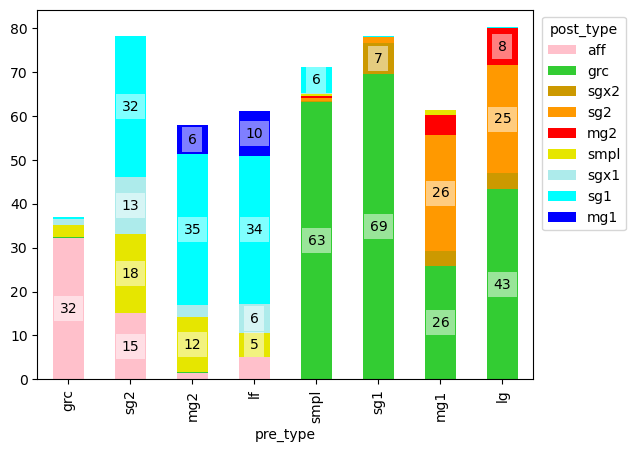

In [835]:
if syn == 'post-synaptic':
    order_pre = ['grc','sg2','mg2','aff','smpl','sg1','mg1']#,'dml']#,'dml'] #['grc-d','sg2','mg2','lf','grc-s','sg1','mg1','lg','dml']
    order_post = ['grc','sgx2','sg2','mg2','lf','smpl','sgx1','sg1','mg1','lg']#,'dml','tsd','uk','fov']
if syn == 'pre-synaptic':
    order_pre = ['grc','sg2','mg2','lf','smpl','sg1','mg1','lg']#,'dml'] #['grc-d','sg2','mg2','lf','grc-s','sg1','mg1','lg','dml']
    order_post = ['aff','grc','sgx2','sg2','mg2','smpl','sgx1','sg1','mg1']

ax = matrix_normalized.loc[order_pre,order_post].plot.bar(stacked=True,color = syn_colors)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height >= 5:
        t = ax.text(x+width/2, 
                y+height/2, 
                f'{height:.0f}', 
                horizontalalignment='center', 
                verticalalignment='center')
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor = 'None'))
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.2, 1))

## bar

In [27]:
def typed_progress_df(df_edges,pre_type):

    res = df_edges[df_edges['pre_type'].isin(pre_type)].groupby(
        ['pre','post_type'])[['weight']].sum(numeric_only=True)#.reset_index()
    denom = res.groupby('pre')['weight'].sum()

    # res.weight = np.round(res.weight / denom *100)

    data = res.reset_index(level=[0,1]).fillna(0)
    
    return data

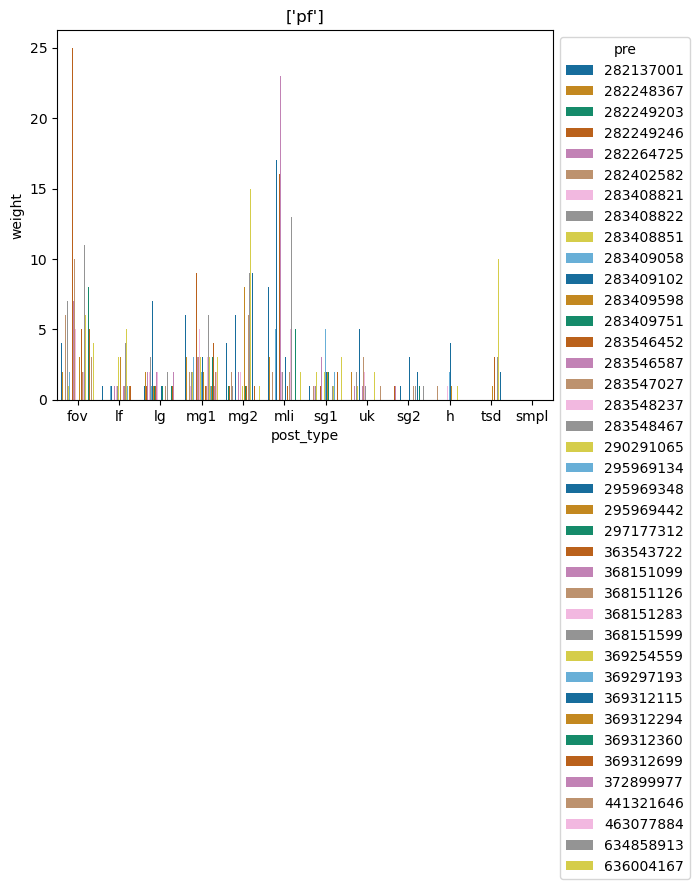

In [226]:
pre_type = ['pf']
data = typed_progress_df(df_edges,pre_type)
ax = sns.barplot(data = data, y = 'weight', x = 'post_type', hue = 'pre',dodge=True,palette = 'colorblind')
# ax = sns.barplot(data = df_edges[df_edges['pre_type'].isin(pre_type)], y = 'weight', x = 'post_type', hue = 'pre',dodge=True)
plt.title(pre_type)
# plt.ylim(0,100);
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [221]:
data['pre'].unique()

array([290291065, 297177312, 372899977, 441321646, 463077884, 634858913,
       636004167])

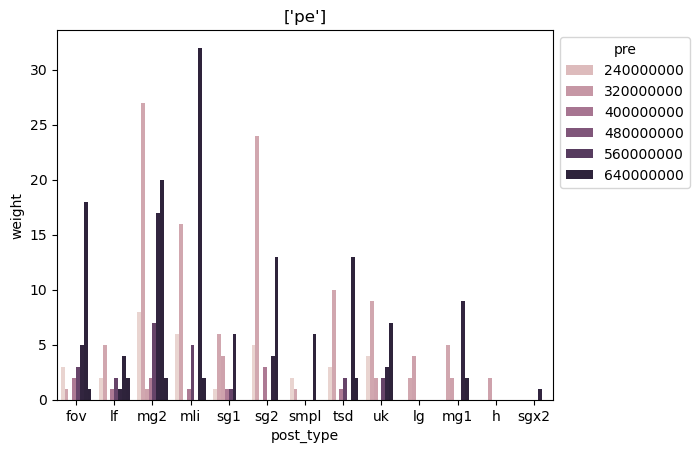

In [164]:
pre_type = ['pe']
data = typed_progress_df(df_edges,pre_type)
ax=sns.barplot(data = data, y = 'weight', x = 'post_type', hue = 'pre',dodge=True)
plt.title(pre_type)
# plt.ylim(0,100);
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));

## heatmaps

In [42]:
t = 'pf'
display(df_edges[(df_edges['pre_type']==t) ].groupby(
        ['pre','pre_type','post_type']).count().drop(columns=['post','y_adj']).rename(columns={'weight':'ncells'})) #& (df_edges['pre'].isin([283546452]))

display(df_edges[(df_edges['pre_type']==t) ].groupby(
        ['pre','pre_type','post_type']).sum().drop(columns=['post','y_adj'])) #& (df_edges['pre'].isin([283546452]))

ncells
pre       pre_type post_type        
268614383 pf       mg2             2
                   sg2             1
268614458 pf       mg1             1
                   mg2             1
                   tsd             1
...                              ...
636004167 pf       fov             4
                   mg1             3
                   mg2             1
                   mli             2
                   sg1             3

[247 rows x 1 columns]

weight
pre       pre_type post_type        
268614383 pf       mg2             2
                   sg2             1
268614458 pf       mg1             1
                   mg2             1
                   tsd             1
...                              ...
636004167 pf       fov             4
                   mg1             3
                   mg2             1
                   mli             2
                   sg1             3

[247 rows x 1 columns]

In [439]:
count_type = 'nsyn' # 'ncells' #
mask = (df_edges['post_type'].isin(['sg1','sg2','mg1','mg2','lg','lf']))#,'mli','tsd','dml'])) # df_edges['pre'].isin([290552453,27220895,31694533,102463116,188296613,15401313,17877032,187151336,117041378,122039969,36165549]) & 
#[295969348,295969442,295969134,295969355,295968777,282228761,283375247, 283391297,283390956,282230475,268614458,268614383,273086215,187230424]
## ## (df_edges['pre_type'].isin(['sg1','sg2','mg1','mg2'])) 
#df_edges['post_type'].isin(['aff','grc','smpl','sgx1','sgx2','sg1','sg2','mg1','mg2','lg','lf','fov','tsd','h','uk']) # ['mg1','mg2','lg','lf'])#
#df_edges['pre'].isin([299392199,299405462,299439953,299496636]) &

types_ = ['pf']# ['sg1','sg2','mg1','mg2']#['mg1','mg2'] ##df_edges['pre_type'].unique() # ['mg1','mg2','lg','lf','sg1','sg2','sgx1','sgx2','grc-d','grc-s','aff','dml']#
df_map = pd.DataFrame()
for t in types_:
    if count_type == 'nsyn':
        df_grouped = df_edges[(df_edges['pre_type']==t) & mask].groupby(
            ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
            index='pre', columns='post_type', values='weight').fillna(0).reset_index()
    
    if count_type == 'ncells':
        df_grouped = df_edges[(df_edges['pre_type']==t) & mask].groupby(
            ['pre','pre_type','post_type']).count().reset_index().pivot(
            index='pre', columns='post_type', values='post').fillna(0).reset_index()
    
    df_grouped['pre_type']=t
    df_map = pd.concat([df_map,df_grouped])
    
df_map = df_map.fillna(0)
df_map = df_map.set_index('pre')
df_map = df_map.drop(['pre_type'],axis=1)

In [434]:
df_map

post_type   lf   lg  mg1  mg2  mli  sg1  sg2  tsd
pre                                              
15401313   0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
17877032   0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
27220895   0.0  0.0  1.0  3.0  2.0  1.0  0.0  1.0
31694533   2.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
36165549   0.0  1.0  1.0  0.0  0.0  9.0  0.0  0.0
...        ...  ...  ...  ...  ...  ...  ...  ...
372899977  0.0  2.0  1.0  0.0  0.0  0.0  0.0  0.0
441321646  0.0  1.0  2.0  0.0  8.0  0.0  0.0  0.0
463077884  0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0
634858913  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0
636004167  0.0  0.0  3.0  1.0  2.0  3.0  0.0  0.0

[62 rows x 8 columns]

Text(0.5, 1.0, 'total syn per pre cell')

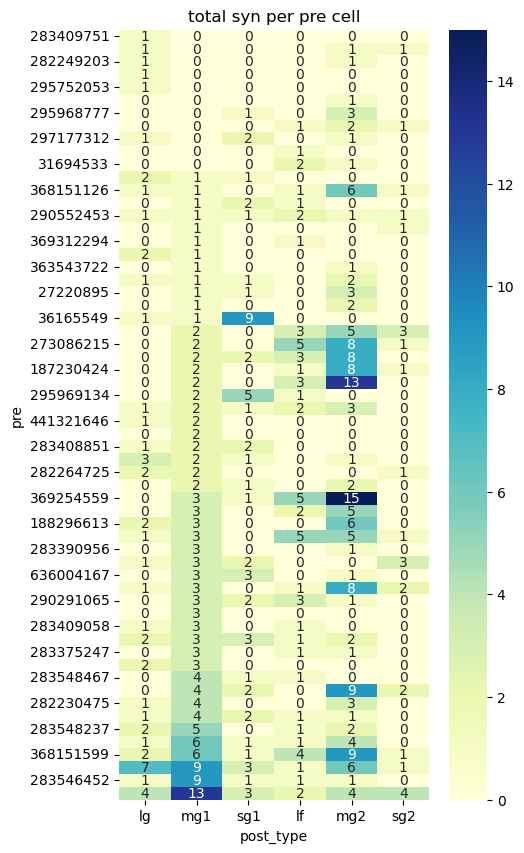

In [440]:
target_order = ['lg','mg1','sg1','lf','mg2','sg2','mli','dml','tsd']#['aff','smpl','sgx1','sg1','mg1','lg','grc','sgx2','sg2','mg2','lf','fov','tsd','h','uk'] #
df_map = df_map.loc[:,[t for t in target_order if t in df_map.columns.values]]

fig, axes = plt.subplots(1, figsize=(5,10))
sns.heatmap(data=df_map.sort_values(['mg1']), annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes)#  .sort_index()
# sns.heatmap(data=df_map.div(df_map.sum(axis=1),axis=0).mul(100).round(0), annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[1])
axes.set_title('total syn per pre cell')

In [436]:
df_map.sum()

post_type
lg      51.0
mg1    144.0
sg1     55.0
lf      58.0
mg2    157.0
sg2     25.0
mli    188.0
tsd     43.0
dtype: float64

In [219]:
df_map.sort_values(['mg1'])

post_type  aff    fov  grc    h   mg1  mg2    sg1  sgx1  sgx2  smpl  tsd    uk
pre                                                                           
299404889  0.0    0.0  0.0  0.0   0.0  0.0    3.0   0.0   0.0   0.0  0.0   0.0
126649726  0.0   30.0  1.0  0.0   1.0  0.0   67.0   3.0   0.0  20.0  0.0   6.0
386392158  7.0    7.0  0.0  2.0   1.0  0.0   48.0  15.0   1.0  50.0  0.0  41.0
386426114  2.0   25.0  0.0  0.0   1.0  0.0   64.0   9.0   0.0  29.0  0.0   5.0
213605530  1.0   37.0  0.0  0.0  21.0  0.0   61.0   3.0   0.0  12.0  0.0   5.0
214581797  5.0  154.0  2.0  0.0  42.0  1.0  201.0   5.0   0.0  40.0  1.0   9.0

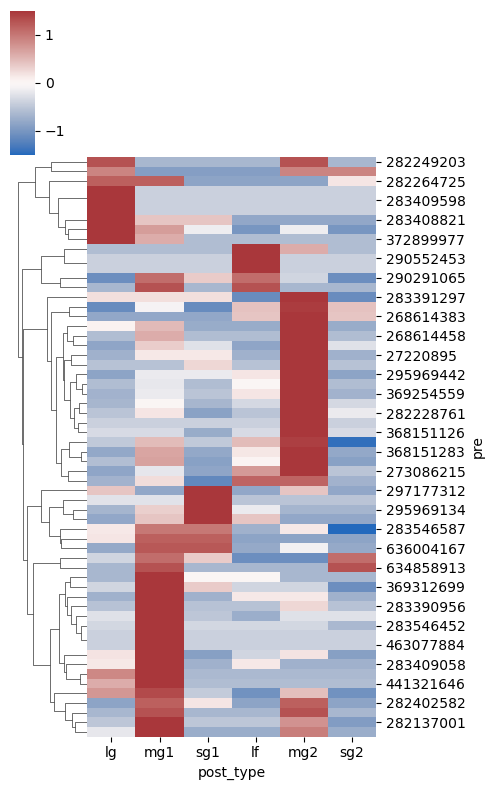

In [441]:

# sns.set(font_scale=1.4)
sns.clustermap(data=df_map,z_score=0,cmap='vlag',col_cluster=False, vmin=-1.5, vmax=1.5,figsize=(5,8))

<Axes: xlabel='lf', ylabel='mg2'>

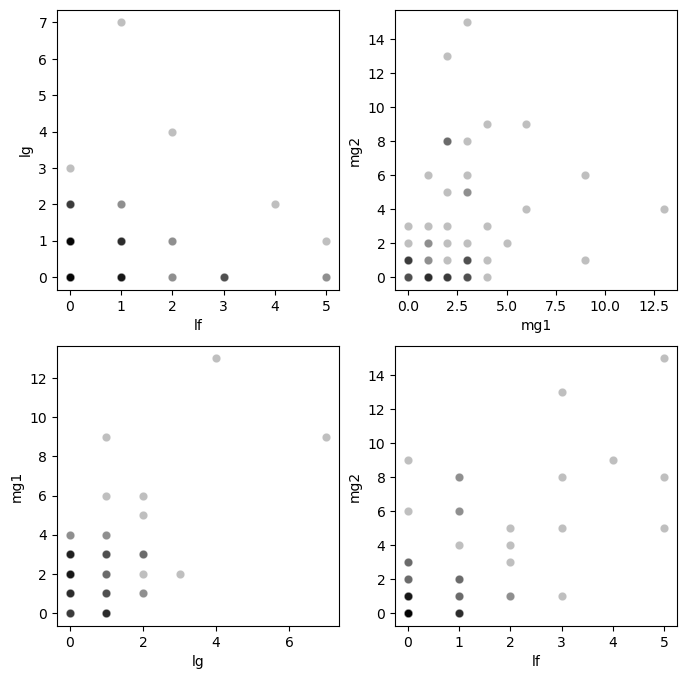

In [442]:
hfig,ax = plt.subplots(2,2,figsize=(8,8))
sns.scatterplot(df_map, x = 'lf', y = 'lg', ax = ax[0][0],alpha = 0.25,color = 'black')
sns.scatterplot(df_map, x = 'mg1', y = 'mg2', ax = ax[0][1],alpha = 0.25,color = 'black')
sns.scatterplot(df_map, x = 'lg', y = 'mg1', ax = ax[1][0],alpha = 0.25,color = 'black')
sns.scatterplot(df_map, x = 'lf', y = 'mg2', ax = ax[1][1],alpha = 0.25,color = 'black')

<Axes: xlabel='post_type', ylabel='pre'>

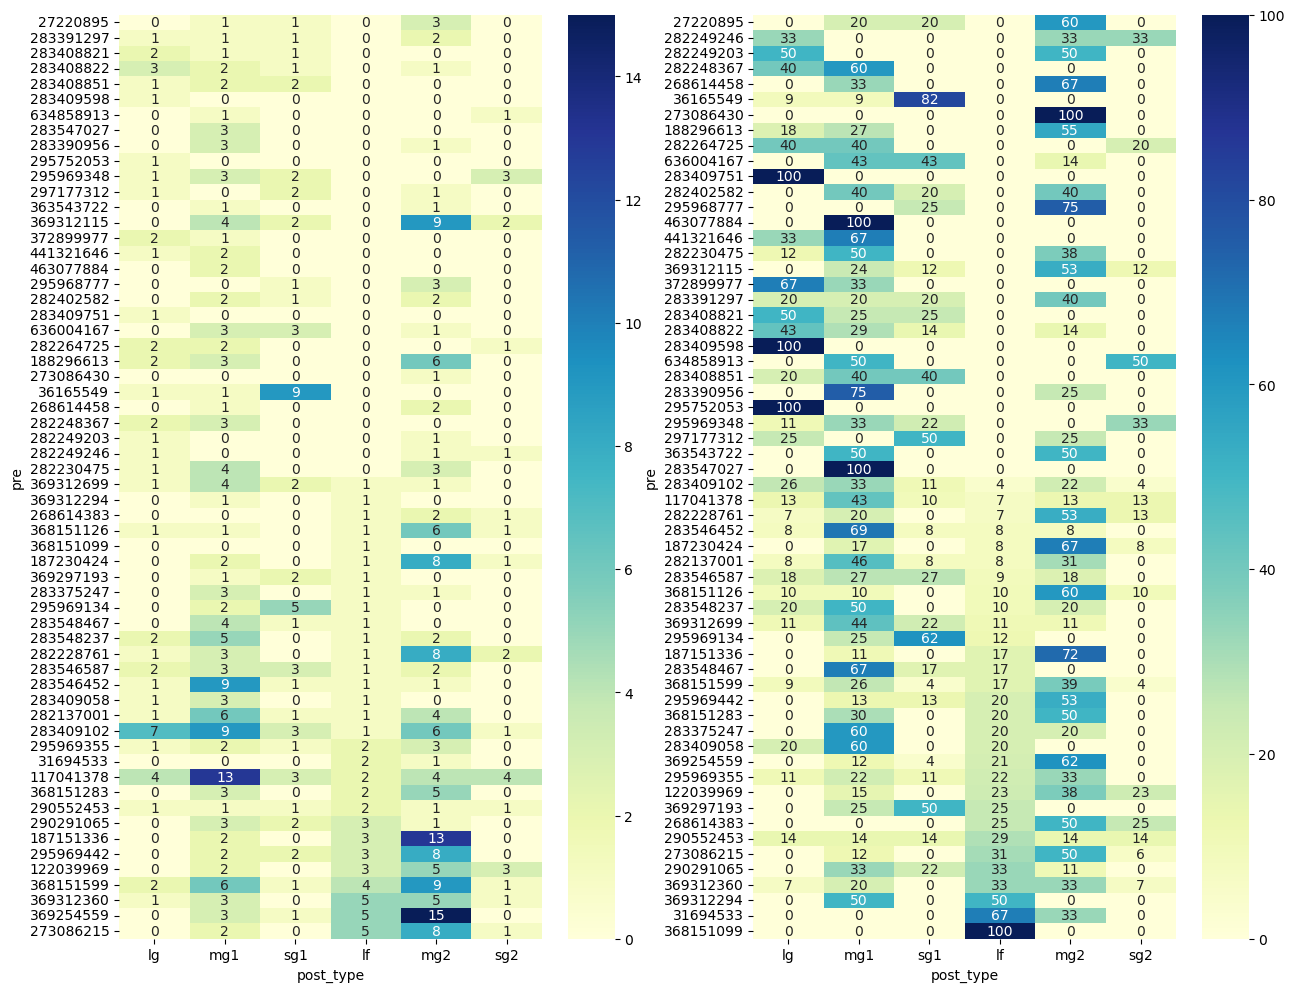

In [444]:
fig, axes = plt.subplots(1, 2, figsize=(15, 12))
df_sorted = df_map.sort_values('lf')
sns.heatmap(data=df_sorted, annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[0])
df_norm = df_sorted.div(df_sorted.sum(axis=1),axis=0).mul(100).round(0)
sns.heatmap(data=df_norm.sort_values('lf'), annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[1])

In [411]:
syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'mli':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#ccccff',
    'uk':'#86592d',
    'fov':'#000000',
    'focal types':'#33cc33',
    'pf':'#ffcce6'
}

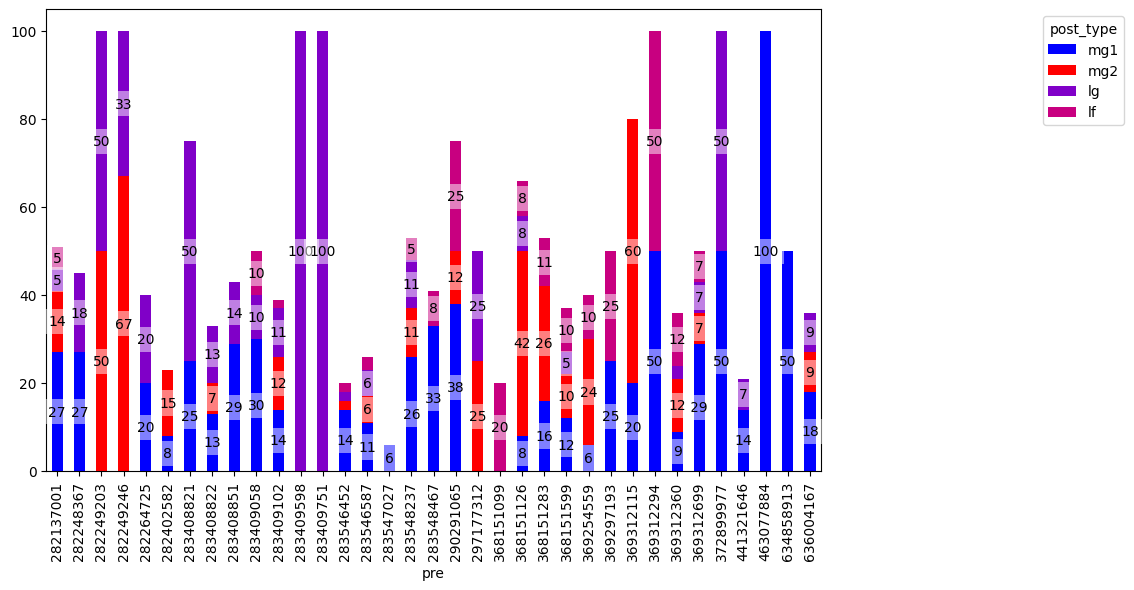

In [109]:
df_norm = df_map.div(df_map.sum(axis=1),axis=0).mul(100).round(0)

# order_pre = [383050900,457217192,290280494,385234105,559257305,473274862]
order_post = ['mg1','mg2','lg','lf']

# ax = pd.DataFrame(df_norm.loc[order_pre,order_post]).plot(kind='bar', stacked=True, figsize=(5, 6),color = syn_colors)
ax = pd.DataFrame(df_norm.loc[:,order_post]).plot(kind='bar', stacked=True, figsize=(10, 6),color = syn_colors)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height >= 5:
        t = ax.text(x+width/2, 
                y+height/2, 
                f'{height:.0f}', 
                horizontalalignment='center', 
                verticalalignment='center')
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor = 'None'))
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.4, 1))

### mean/total/proportion cells per type (collapse across rows within columns)

In [118]:
count_type = 'ncells' #'nsyn' #

types_ =  ['pf'] #df_edges['pre_type'].unique() # ['mg1','mg2','lg','lf','sg1','sg2','sgx1','sgx2','grc-d','grc-s','aff','dml']#
df_map = pd.DataFrame()
for t in types_:
    if count_type == 'nsyn':
        df_grouped = df_edges[df_edges['pre_type']==t].groupby(
            ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
            index='pre', columns='post_type', values='weight').fillna(0).reset_index()
    
    if count_type == 'ncells':
        df_grouped = df_edges[df_edges['pre_type']==t].groupby(
            ['pre','pre_type','post_type']).count().reset_index().pivot(
            index='pre', columns='post_type', values='post').fillna(0).reset_index()
    
    df_grouped['pre_type']=t
    df_map = pd.concat([df_map,df_grouped])
    
df_map = df_map.fillna(0)
df_map = df_map.set_index('pre')
df_map = df_map.drop(['pre_type'],axis=1)

In [119]:
df_map['output'] = df_map[['lf', 'lg']].sum(axis=1)
df_map['mg'] = df_map[['mg1', 'mg2']].sum(axis=1)
df_map['sg'] = df_map[['sg1', 'sg2']].sum(axis=1)

# Drop the original columns
df_map = df_map.drop(['lf', 'lg', 'mg1', 'mg2', 'sg1', 'sg2'], axis=1)

df_sum = df_map.sum()

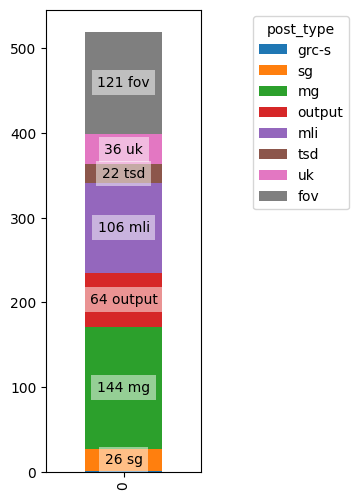

In [120]:
order_post = ['grc-s','sg','mg','output','mli','tsd','uk','fov']
df_sum_ordered = df_sum.loc[order_post]



ax = pd.DataFrame(df_sum_ordered).T.plot(kind='bar', stacked=True, figsize=(2, 6))#,color = syn_colors)

for p,cell_type in zip(ax.patches, order_post):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height >= 5:
        t = ax.text(x+width/2, 
                y+height/2, 
                f'{height:.0f} {cell_type}', 
                horizontalalignment='center', 
                verticalalignment='center')
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor = 'None'))
sns.move_legend(ax, "upper right", bbox_to_anchor=(2, 1))

***Do this plot seperately for the set of pf originating from each example cell***

In [160]:
df_sum_ordered

post_type
grc-s       1.0
sg         26.0
mg        166.0
output     61.0
mli       115.0
tsd        24.0
pf          1.0
uk         42.0
fov       127.0
dtype: float64

In [126]:
df_map.sum() / df_map.sum().sum() * 100

post_type
fov       23.935091
grc-s      0.202840
mli       19.472617
pf         0.202840
tsd        4.462475
uk         7.707911
output    11.359026
mg        27.586207
sg         5.070994
dtype: float64

# Connectivity Similarity

In [185]:
df_edges = df_edges.rename(columns={'pre':'post','post':'pre','pre_type':'post_type','post_type':'pre_type'})
df_edges

pre       post          y_adj pre_type post_type  weight
0      306461085  392135367   23565.348751      sg2       tsd       2
1       50786130   47378956   27208.563968      sg2       fov       2
2       50786130  126370492   23089.023957      sg2       tsd       2
3       50786130  129807416   29944.498587      sg2       sg1       2
4       50786130  129835941   35068.607025      sg2       sg1       2
...          ...        ...            ...      ...       ...     ...
18460  283547027   42102097  -94024.520011       pf       fov       1
18461  283547027   52320040 -101079.509037       pf        uk       1
18462  283547027  117519746  -96924.741600       pf       mli       1
18463  283547027  138130976 -101235.850734       pf        uk       1
18464  669119245  653242015  104369.819555      aff        uk       1

[18465 rows x 6 columns]

## correlation

In [185]:
# Desired source and order
source_types_order = ['mg1','mg2']#['aff','smpl','sgx1','sg1','mg1','grc','sgx2','sg2','mg2']#['smpl','sg1','mg1','grc','sg2','mg2']#

# Desired targets order
target_types_order = ['grc', 'smpl', 'sgx2','sgx1','sg2', 'sg1', 'mg2', 'mg1', 'lf', 'lg']  #['aff', 'smpl','sgx1','sg1', 'grc', 'sgx2', 'sg2']#

In [186]:
# dsource = 'post_type'
# idsource = 'post'
# dtarget = 'pre_type'

# post-synaptic labeling
dsource = 'pre_type'
idsource = 'pre'
dtarget = 'post_type'

# Filter out rows with post_type not in post_types_order
df_edges_filtered = df_edges[df_edges[dsource].isin(source_types_order)]

# Pivot table to get sum of weights per post and pre_type
pivot_df = df_edges_filtered.pivot_table(values='weight', index=[idsource, dsource], columns=dtarget, aggfunc='sum', fill_value=0)

# Reindex columns to include only the specified pre_types in the desired order
pivot_df = pivot_df.reindex(columns=target_types_order, fill_value=0)

# Reset index to turn 'post' and 'post_type' from index to columns
pivot_df.reset_index(inplace=True)

# Sort the dataframe based on post_type
pivot_df[dsource] = pd.Categorical(pivot_df[dsource], categories=source_types_order, ordered=True)
pivot_df.sort_values(dsource, inplace=True)
pivot_df.set_index(idsource, inplace=True)

In [187]:
pivot_df.head()

post_type pre_type  grc  smpl  sgx2  sgx1  sg2  sg1  mg2  mg1  lf  lg
pre                                                                  
303244291      mg1    0     0     0     0    0    0    1    0  37   0
474373577      mg1    0     0     1     0    1    0   26    1  30   0
300459385      mg1    0     0     0     0    0    0   30    0  42   0
300380579      mg1    0     2     0     0    0    0   16    0  27   0
476167179      mg1    0     0     0     0    0    0    6    0  26   0

## cosine similarity

In [180]:
def cosine_similarity(A, B):
    # The time-series data sets should be normalized.
    A_norm = (A - np.mean(A)) / np.std(A)
    B_norm = (B - np.mean(B)) / np.std(B)
 
    # Determining the dot product of the normalized time series data sets.
    dot_product = np.dot(A_norm, B_norm)
 
    # Determining the Euclidean norm for each normalized time-series data collection.
    norm_A = np.linalg.norm(A_norm)
    norm_B = np.linalg.norm(B_norm)
 
    # Calculate the cosine similarity of the normalized time series data 
    # using the dot product and Euclidean norms. setse-series data set
    cosine_sim = dot_product / (norm_A * norm_B)
 
    return cosine_sim
    
# from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from numpy.linalg import norm


In [181]:
pivot_df.head()

post_type pre_type  grc  smpl  sgx2  sgx1  sg2  sg1  mg2  mg1  lf  lg
pre                                                                  
474836942      sg1    0     0     0     0    2    0    8    0   4   0
213699579      sg1    0     0     0     0    0    0    7    0  34   0
214613070      sg1    0     1     0     0    3    0   45    1  17   0
214627855      sg1    0     0     0     0    2    0    7    0  19   0
214951406      sg1    0     0     0     0    2    0   17    0  12   0

In [188]:
# Normalize each row to unit length (L2 norm)
pivot_df_corr = pivot_df.drop(columns=[dsource])
# pivot_df_corr=pivot_df_corr.apply(zscore, axis=1) # DO NOT Z-SCORE: it will then just be correlation coefficient 
# (https://stats.stackexchange.com/questions/235673/is-there-any-relationship-among-cosine-similarity-pearson-correlation-and-z-sc)
normalized_df = pivot_df_corr.div(norm(pivot_df_corr, axis=1), axis=0)
normalized_df.dropna(inplace=True)#.replace(np.NaN,0)

In [189]:
cosine_sim_matrix = pairwise_distances(normalized_df, metric='cosine')
cosine_sim_matrix = 1-cosine_sim_matrix
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=normalized_df.index, columns=normalized_df.index)

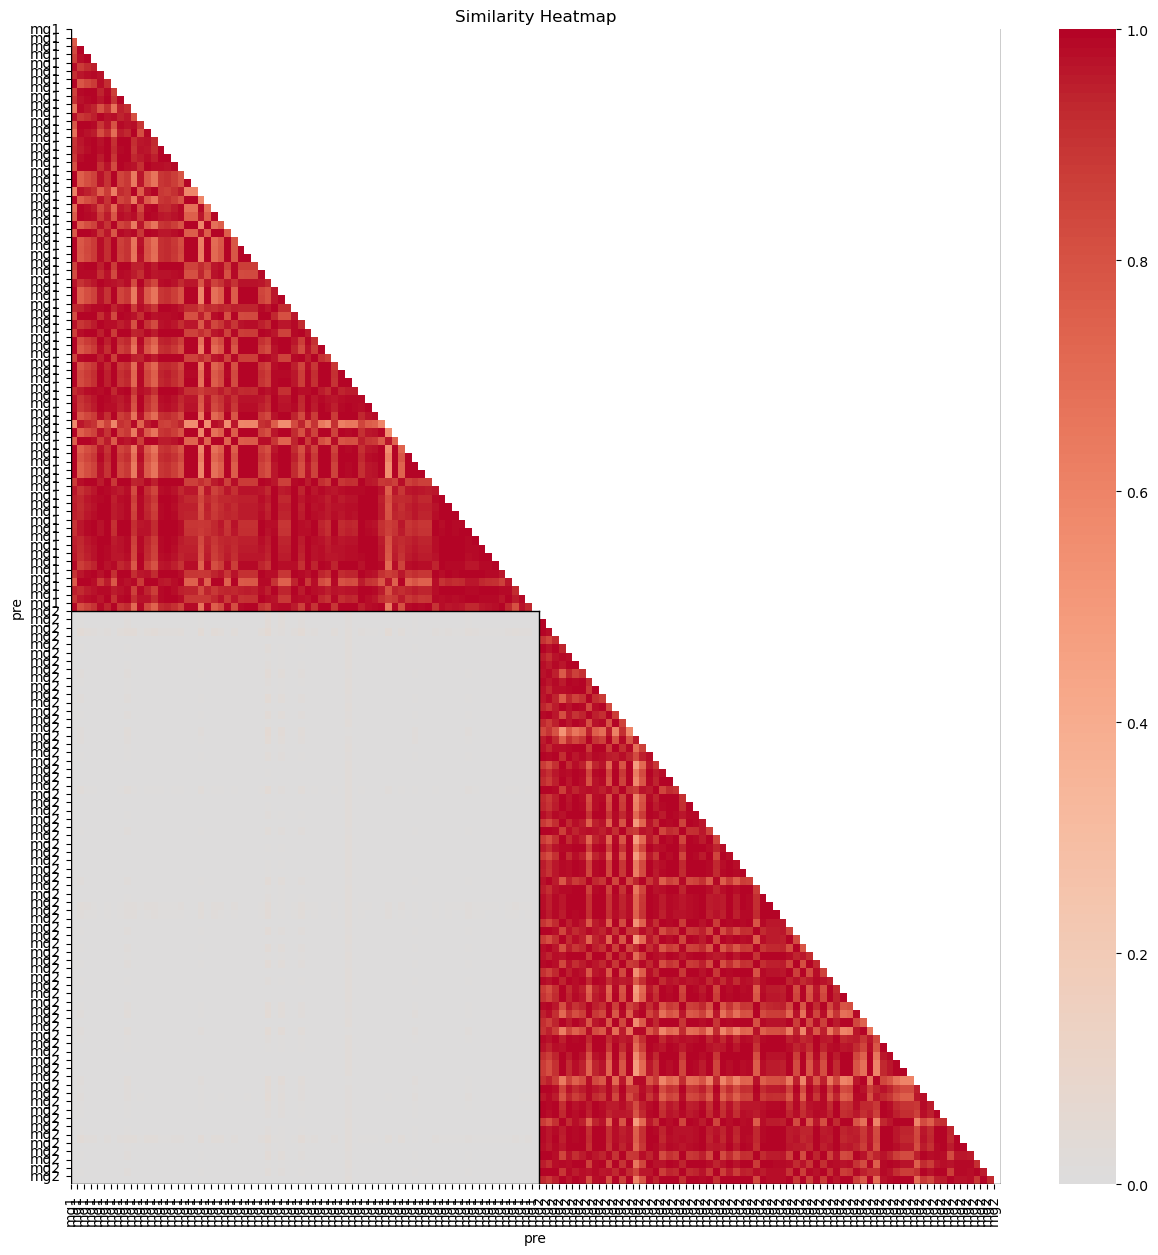

In [190]:
# Create the heatmap
plt.figure(figsize=(15, 15))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cosine_sim_df, dtype=bool))

heatmap = sns.heatmap(cosine_sim_df, mask=mask,cmap='coolwarm', annot=False, fmt='.2f', cbar=True,center=0) #

# Add post_type labels and lines
current_position = 0
total_position=len(pivot_df)
for dtype in source_types_order:
    n = (pivot_df[dsource] == dtype).sum()
    if n > 0:
        # heatmap.axhline(current_position,current_position/len(pivot_df), total_position, color='black', linewidth=1)
        # heatmap.axvline(current_position,1-(current_position/len(pivot_df)), total_position, color='black', linewidth=1)
        heatmap.axhline(current_position,0, current_position/len(pivot_df), color='black', linewidth=1)
        heatmap.axvline(current_position,0, 1-(current_position/len(pivot_df)), color='black', linewidth=1)
        current_position += n
heatmap.axhline(current_position, color='black', linewidth=1)
heatmap.axvline(current_position, color='black', linewidth=1)

# Set labels
heatmap.set_xticks(range(0,len(pivot_df)))
heatmap.set_yticks(range(0,len(pivot_df)))
heatmap.set_xticklabels(pivot_df[dsource].values, rotation=90)
heatmap.set_yticklabels(pivot_df[dsource].values, rotation=0)

plt.title('Similarity Heatmap')
plt.show()

## correlation

In [290]:

# Drop the 'post' and 'post_type' column for correlation calculation
pivot_df_corr = pivot_df.drop(columns=[dsource])
# pivot_df_corr=pivot_df_corr.apply(zscore, axis=1)

# Calculate the pairwise correlation matrix
correlation_matrix = pivot_df_corr.T.corr()

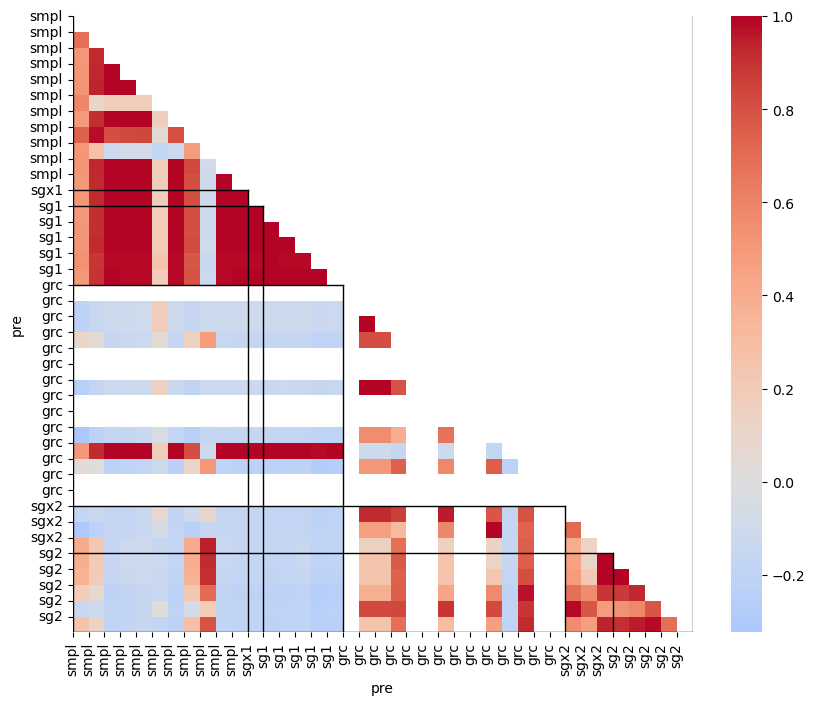

In [291]:
# Create the heatmap
hfig,ax = plt.subplots(1,figsize=(10, 8))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

heatmap = sns.heatmap(correlation_matrix, mask=mask,cmap='coolwarm', annot=False, fmt='.2f', cbar=True,center=0, ax=ax) #

# Set labels
heatmap.set_xticks(range(0,len(pivot_df),1))
heatmap.set_yticks(range(0,len(pivot_df),1))
heatmap.set_xticklabels(list(pivot_df[dsource].values)[::1], rotation=90)
heatmap.set_yticklabels(list(pivot_df[dsource].values)[::1], rotation=0)

# Add post_type labels and lines
current_position = 0
for dtype in source_types_order:
    n = (pivot_df[dsource] == dtype).sum()
    if n > 0:
        heatmap.axhline(current_position,0, current_position/len(pivot_df), color='black', linewidth=1)
        heatmap.axvline(current_position,0, 1-(current_position/len(pivot_df)), color='black', linewidth=1)
        current_position += n
heatmap.axhline(current_position, color='black', linewidth=1)
heatmap.axvline(current_position, color='black', linewidth=1)

ax.spines["right"].set_visible(False)
# ax.set_title('Pairwise Correlation Matrix Heatmap')
plt.show()

## Patterns of connectivity (PCA)

In [618]:
color_dict = {
    'sgx1':'#00b2b2',
    'sgx2':'#b27300',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc':'#FFC0CB',
    'smpl':'#666666',#'#e6e600',
    'dml':'#a6a6a6',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#BB00FF',
    'lf':'#FF00BC',
    'aff':'#33cc33',
    'pe':'#550055',
    'pf':'#880088'
}

def calculate_percent_total(row):
    total = row.sum()
    return row / total 

In [626]:
# Desired pre_types and order
source_types_order = ['smpl', 'sg1', 'mg1', 'lg', 'grc', 'sg2', 'mg2', 'lf']#['aff',  'sg1', 'grc', 'sg2']
# Desired post_types order
target_types_order =  ['aff','smpl','sgx1','sg1', 'mg1','grc', 'sgx2','sg2','mg2'] #['aff',  'sg1','mg1', 'grc', 'sg2','mg2']
#

# Filter out rows with post_type not in post_types_order
df_edges_filtered = df_edges[df_edges[dsource].isin(source_types_order)]

# Pivot table to get sum of weights per post and pre_type
pivot_df = df_edges_filtered.pivot_table(values='weight', index=[idsource, dsource], columns=dtarget, aggfunc='sum', fill_value=0)

# Reindex columns to include only the specified pre_types in the desired order
pivot_df = pivot_df.reindex(columns=target_types_order, fill_value=0)

# Reset index to turn 'post' and 'post_type' from index to columns
pivot_df.reset_index(inplace=True)

# Sort the dataframe based on post_type
pivot_df[dsource] = pd.Categorical(pivot_df[dsource], categories=source_types_order, ordered=True)
pivot_df.sort_values(dsource, inplace=True)
pivot_df.set_index(idsource, inplace=True)

# # Drop the 'post' and 'post_type' column for correlation calculation
# pivot_df_corr = pivot_df.drop(columns=[dsource])

# # Calculate the pairwise correlation matrix
# correlation_matrix = pivot_df_corr.T.corr()

In [627]:
# Apply the function to each row
norm_df = pivot_df.drop(columns=dsource).apply(calculate_percent_total, axis=1)
numerical_columns = pivot_df.select_dtypes(include=np.number).columns

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(norm_df)

In [628]:
numerical_columns

Index(['aff', 'smpl', 'sgx1', 'sg1', 'mg1', 'grc', 'sgx2', 'sg2', 'mg2'], dtype='object', name='pre_type')

In [629]:
# Perform PCA
npc = 7
pca = PCA(n_components=npc)  # You can change the number of components as needed
pca_result = pca.fit_transform(scaled_data)

# get loadings of dimensions onto each principal component
loadings = pca.components_.T

In [630]:
# Add PCA results to the DataFrame
for i in range(npc):
    pivot_df[str(i)] = pca_result[:, i]

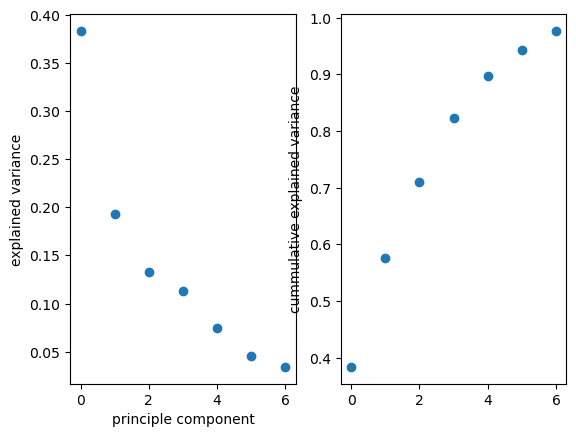

In [631]:
hfig,ax = plt.subplots(1,2)
ax[0].scatter(range(0,npc),pca.explained_variance_ratio_)
ax[0].set_ylabel('explained variance')
ax[0].set_xlabel('principle component')
ax[1].scatter(range(0,npc),np.cumsum(pca.explained_variance_ratio_))
ax[1].set_ylabel('cummulative explained variance')
plt.show()

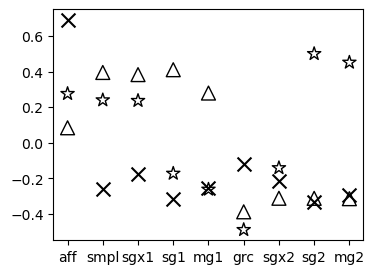

In [632]:
hfig,ax = plt.subplots(1,figsize=(4,3))
ax.scatter(numerical_columns,[l[0] for l in loadings],color='black',s=100,marker='^', facecolors='none')
ax.scatter(numerical_columns,[l[1] for l in loadings],color='black',s=100,marker='x')#
ax.scatter(numerical_columns,[l[2] for l in loadings],color='black',s=100,marker='*', facecolors='none')
plt.show()

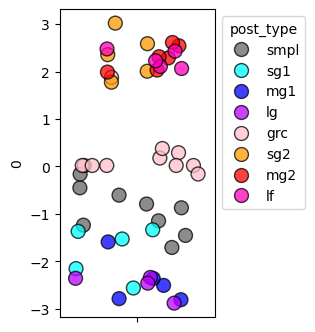

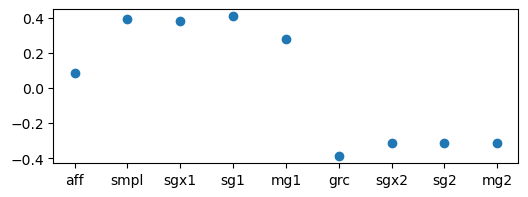

In [633]:
pc_dim = 0

hfig,ax = plt.subplots(1,figsize=(2,4))
sns.stripplot(ax=ax,data=pivot_df,hue=dsource,y=str(pc_dim),palette=color_dict,linewidth=1,edgecolor='black',s=10,jitter=0.4,alpha = 0.75)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

hfig,ax = plt.subplots(1,figsize=(6,2))
ax.scatter(numerical_columns,[l[pc_dim] for l in loadings])
plt.show()

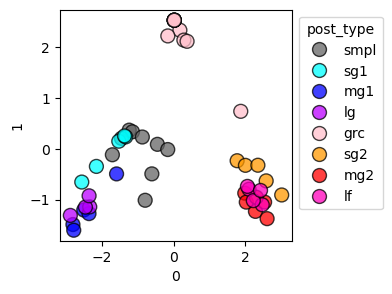

In [635]:
hfig,ax = plt.subplots(1,figsize=(3,3))
sns.scatterplot(ax=ax,data=pivot_df,hue=dsource,x='0',y='1',palette=color_dict,linewidth=1,edgecolor='black',s=100,alpha = 0.75)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

# Density and Proximity of connected cells

In [121]:
df_loc = pd.DataFrame.from_dict(soma_loc, orient='index', columns=['x', 'y', 'z']).dropna()
for c in df_loc.index:
    df_loc.loc[c,'type'] = cell_types[c]

NameError: name 'soma_loc' is not defined

In [229]:
df_loc.loc[df_loc['type'].isin(['mg1','mg2']),'type']='mg'
df_loc.loc[df_loc['type'].isin(['mg1','mg2']),'type']='output'

In [230]:
df_loc

x           y          z type
128614407  176.752031  264.280258  23.776078  sg1
480346174  273.944563  313.730172  75.376117   uk
301973569  387.064000  272.800000  47.760000   mg
43622486    59.805104  269.666914  16.534804   mg
386392158  240.488000  267.312000  56.355000   mg
...               ...         ...        ...  ...
127672247  262.412719  254.396906  25.799978  sg2
306585534  393.857312  295.699187  47.734711  sg1
214736845  281.279437  266.214844  35.405213  sg1
47194079   120.784000  290.564000   4.500000  sg2
128737253  226.952000  262.768000  18.375000   mg

[606 rows x 4 columns]

In [249]:
def euclidean_distance(df, cell_id1, cell_id2):
    if cell_id1 not in df.index or cell_id2 not in df.index:
        raise ValueError("Cell IDs not found in the DataFrame.")

    # Extract the coordinates for the two cell IDs
    coordinates1 = df.loc[cell_id1, ['x', 'y', 'z']]
    coordinates2 = df.loc[cell_id2, ['x', 'y', 'z']]

    # Check for NaN values in the coordinates
    if any(coordinates1.isna()) or any(coordinates2.isna()):
        raise ValueError("Coordinates contain NaN values.")

    # Calculate the Euclidean distance
    distance = np.linalg.norm(coordinates1 - coordinates2)

    return distance

In [256]:
# Example usage
# Assuming df is your DataFrame
distance = euclidean_distance(df_loc, 301973569, 43622486)
print("Euclidean distance:", distance)

Euclidean distance: 328.76011685595546


In [257]:
result_list = []

for i,r in df_edges.iterrows():
    
    
    try:
        df_edges.loc[i,'distance'] = euclidean_distance(df_loc, r['pre'], r['post'])
    except ValueError:
        df_edges.loc[i,'distance'] = np.NaN
# df_edges

In [261]:
df_edges[(df_edges['pre_type'].isin(['mg1','mg2'])) & (df_edges['post_type'].isin(['lg','lf']))].dropna()['pre']

pre       post post_type pre_type  weight   distance
20     41579854   49625293        lf      mg1       7  45.539296
42     41579854  393078033        lf      mg1      29  63.896908
48     41579854  479001172        lf      mg1      13  75.552030
51     41579854  481274292        lf      mg1       1  87.726946
74     42632020   49453764        lf      mg1       6  49.618838
...         ...        ...       ...      ...     ...        ...
5682  558300217  301787806        lg      mg2       3  54.309460
5686  558300217  474898913        lg      mg2       3  90.814376
5687  558300217  560681683        lg      mg2       9  43.582935
5688  558360429  393325331        lf      mg1       2  79.829452
5702  558932805  388406692        lg      mg2      21  33.550537

[204 rows x 6 columns]

array([[<AxesSubplot:title={'center':'pre'}>,
        <AxesSubplot:title={'center':'post'}>],
       [<AxesSubplot:title={'center':'weight'}>,
        <AxesSubplot:title={'center':'distance'}>]], dtype=object)

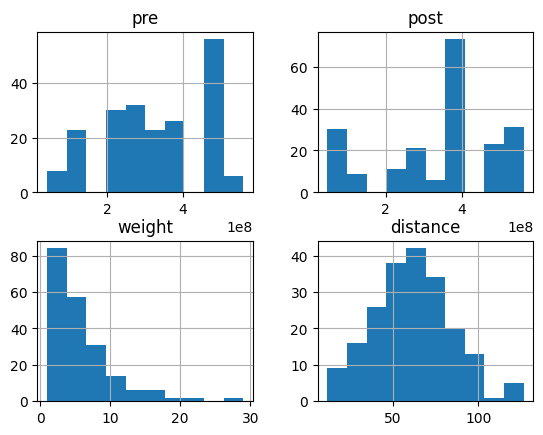

In [262]:
df_edges[(df_edges['pre_type'].isin(['mg1','mg2'])) & (df_edges['post_type'].isin(['lg','lf']))].dropna().hist()

In [299]:
sub_df = df_edges[(df_edges['pre_type'].isin(['mg1','mg2'])) & (df_edges['post_type'].isin(['lg','lf']))].dropna()

<AxesSubplot:xlabel='distance', ylabel='weight'>

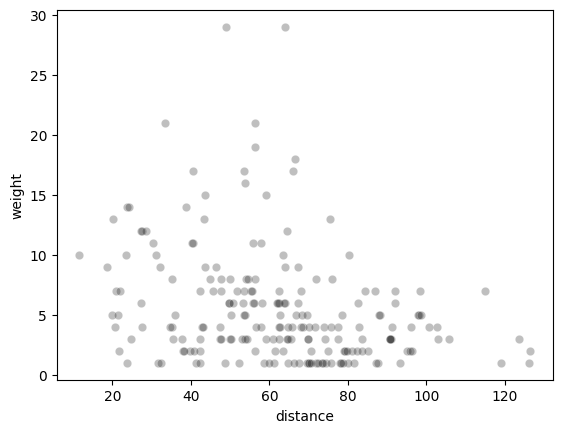

In [302]:
sns.scatterplot(sub_df, x='distance',y='weight',color='black',alpha = 0.25)

In [284]:
def combine_neurons(df_edges, combine='post'):
    if combine not in ['pre', 'post']:
        raise ValueError("Combine must be either 'pre' or 'post'.")

    # Select columns based on combine parameter
    group_cols = ['pre'] if combine == 'post' else ['post']
    value_cols = ['weight', 'distance']

    # Group by the selected columns and calculate mean and standard deviation
    result_df = df_edges.groupby(group_cols)[value_cols].agg(['mean', 'std']).reset_index()

    # Rename columns for better readability
    result_df.columns = ['_'.join(col).strip() for col in result_df.columns.values]

    return result_df

In [296]:
# do the analysis on the subset of the df for which 
# the pre is an mg, the post is an output, and the location of both somas is known
sub_df = df_edges[(df_edges['pre_type'].isin(['mg1','mg2'])) & (df_edges['post_type'].isin(['lg','lf']))].dropna()

result_df = combine_neurons(sub_df, combine='post')

result_df.head(5)

pre_  weight_mean  weight_std  distance_mean  distance_std
0   41579854    12.500000   12.041595      68.178795     17.957137
1   42632020     3.333333    2.516611      61.656555     12.418550
2   43622486    15.000000         NaN      59.086083           NaN
3  126618353     1.500000    0.707107      85.424238     13.661970
4  127870654     6.000000    2.121320      76.540455     19.984571

<AxesSubplot:ylabel='distance_mean'>

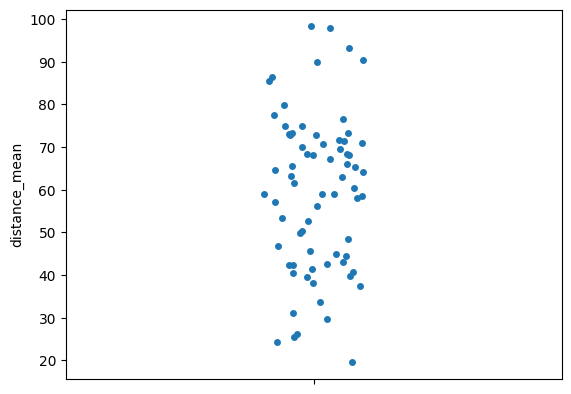

In [297]:
sns.stripplot(result_df,y='distance_mean')

Text(0, 0.5, 'n mg cells')

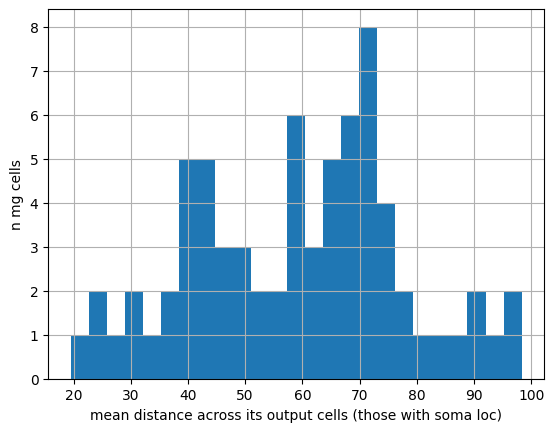

In [311]:
ax = result_df['distance_mean'].hist(bins=25)

ax.set_xlabel('mean distance across its output cells (those with soma loc)')
ax.set_ylabel('n mg cells')


<AxesSubplot:xlabel='distance_mean', ylabel='weight_mean'>

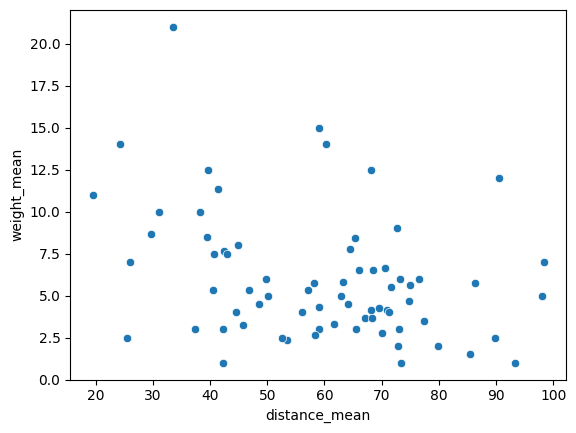

In [298]:
sns.scatterplot(result_df,x='distance_mean',y='weight_mean')

In [312]:
# do the analysis on the subset of the df for which 
# the pre is an mg, the post is an output, and the location of both somas is known
sub_df = df_edges[(df_edges['pre_type'].isin(['mg1','mg2'])) & (df_edges['post_type'].isin(['lg','lf']))].dropna()

result_df = combine_neurons(sub_df, combine='pre')

result_df.head(5)

post_  weight_mean  weight_std  distance_mean  distance_std
0  45633163    14.000000         NaN      23.847896           NaN
1  48573302     5.200000    2.949576      66.320505     15.251722
2  48929295     2.800000    2.683282      73.125271     14.566075
3  49453764     3.900000    2.685351      78.045915     25.870017
4  49625293     3.555556    2.006932      77.923535     22.324786

Text(0, 0.5, 'n output cells')

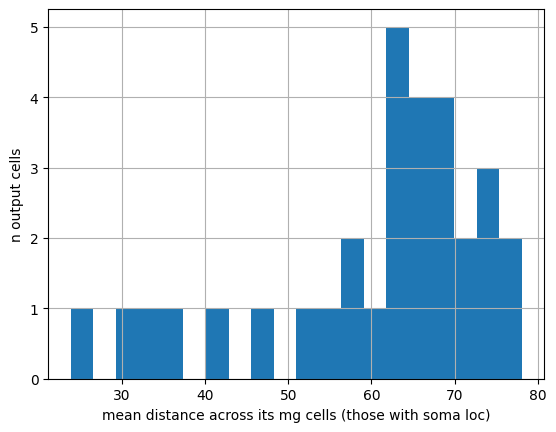

In [314]:
ax = result_df['distance_mean'].hist(bins=20)

ax.set_xlabel('mean distance across its mg cells (those with soma loc)')
ax.set_ylabel('n output cells')

# cluster map

In [18]:
types_ =  ['mg1','mg2']#df_edges['pre_type'].unique() # ['mg1','mg2','lg','lf','sg1','sg2','sgx1','sgx2','grc-d','grc-s','aff','dml']#
df_map = pd.DataFrame()
for t in types_:
    df_grouped = df_edges[df_edges['pre_type']==t].groupby(
        ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
        index='pre', columns='post_type', values='weight').fillna(0).reset_index()
    
    # df_grouped = df_edges[df_edges['pre_type']==t].groupby(
    #     ['pre','pre_type','post_type']).count().reset_index().pivot(
    #     index='pre', columns='post_type', values='post').fillna(0).reset_index()
    
    df_grouped['pre_type']=t
    df_map = pd.concat([df_map,df_grouped])
    

    
df_map = df_map.fillna(0)

df_map = df_map.set_index('pre')

In [19]:
tmp_type = pd.DataFrame(df_map['pre_type'])

In [20]:
df_map = df_map.drop(['pre_type'],axis=1)

# data_df = df_map[df_edges['post_type'].unique()].div(df_map[df_edges['post_type'].unique()].sum(axis=1),axis=0).mul(100).round(0)
data_df = df_map.div(df_map.sum(axis=1),axis=0).mul(100).round(0)
# data_df.loc[:,'pre_type']=tmp_type

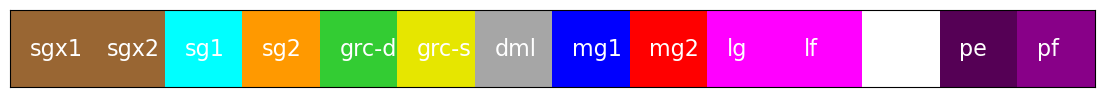

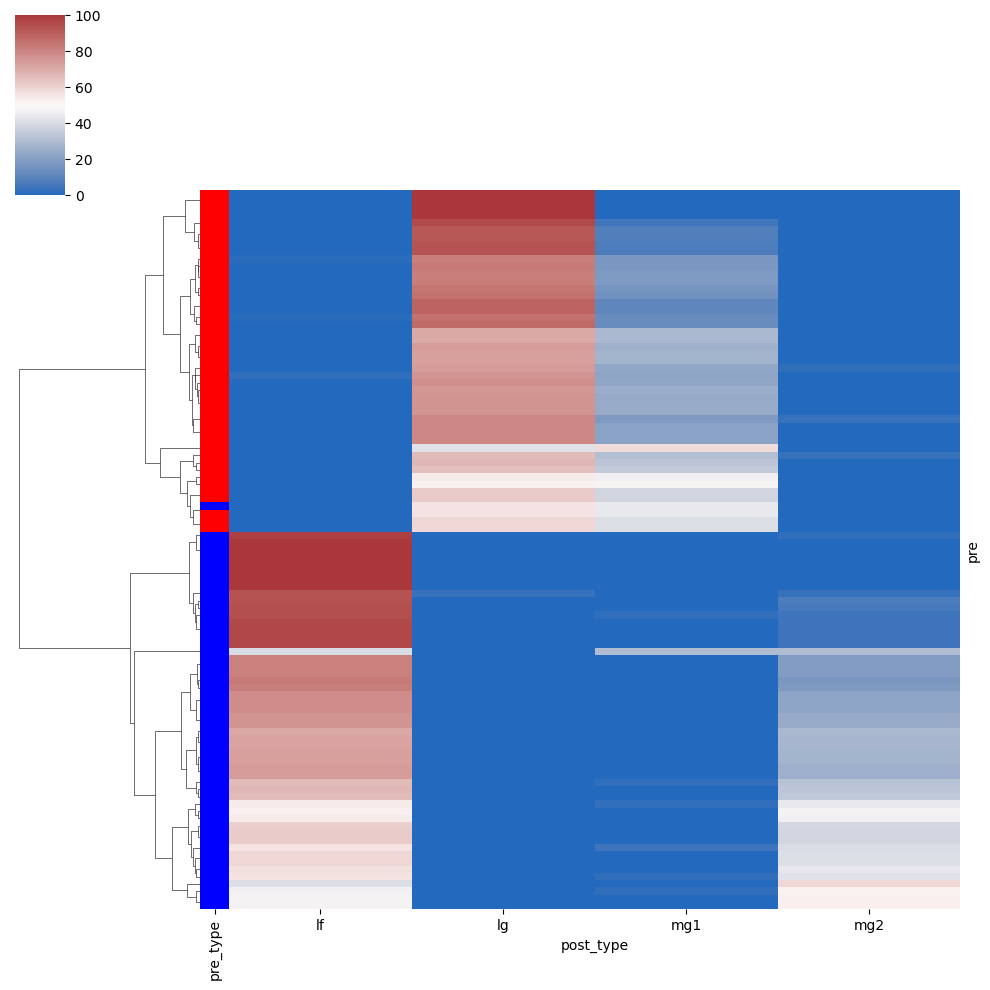

In [21]:
labels = tmp_type['pre_type'].unique()#df_map['pre_type'].unique()
color_pal = sns.color_palette("deep", len(labels))

color_dict = {
    'sgx1':'#996633',
    'sgx2':'#996633',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#a6a6a6',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#ff00ff',
    'lf':'#ff00ff',
    'aff':'#ffffff',
    'pe':'#550055',
    'pf':'#880088'
}
sns.palplot(color_dict.values())
ax = plt.gca()
ax.tick_params(left=False, bottom=False)

for i,v in enumerate(color_dict):
    ax.text(i-0.25, 0.1, v,fontsize=16,color='white') 


sns.clustermap(data = data_df,
               method='average',
               col_cluster=False, cmap="vlag", center=50,yticklabels=False,
               row_colors = tmp_type['pre_type'].map(color_dict));

# sns.clustermap(data = data_df,
#                method='average',
#                col_cluster=False, cmap="YlGnBu", yticklabels=False,
#                row_colors = tmp_type['pre_type'].map(color_dict));

# data_df = df_map[df_edges['post_type'].unique()]
# cmap = sns.color_palette("blend:#d9d9d9,#000000", as_cmap=True)
# cmap.set_under('white')
# sns.clustermap(data = data_df,
#                method='average',
#                col_cluster=False, cmap=cmap, vmin=1, yticklabels=False,
#                row_colors = df_map['pre_type'].map(color_dict));


# The methods are single, complete, average, weighted, ward, median, centroid
# from https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage
# default for seaborn is "average"

# CDF

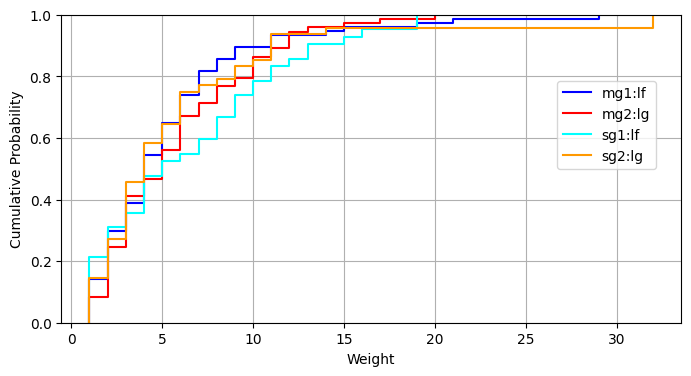

In [227]:
unique_connections = df_edges.groupby(['pre_type', 'post_type'])

hfig,ax = plt.subplots(1,figsize=(8, 4))
# hfig.set_title(f'Cumulative Distribution Plot for {pre_type}:{post_type} Connection')
for (pre_type, post_type), group_df in unique_connections:
    if (pre_type in ['mg1','sg1']) & (post_type in ['lf']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'])
    if (pre_type in ['mg2','sg2']) & (post_type in ['lg']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'])
ax.set_xlabel('Weight')
ax.set_ylabel('Cumulative Probability')
plt.legend(loc=(0.8,0.5))
plt.grid(True)
plt.show()

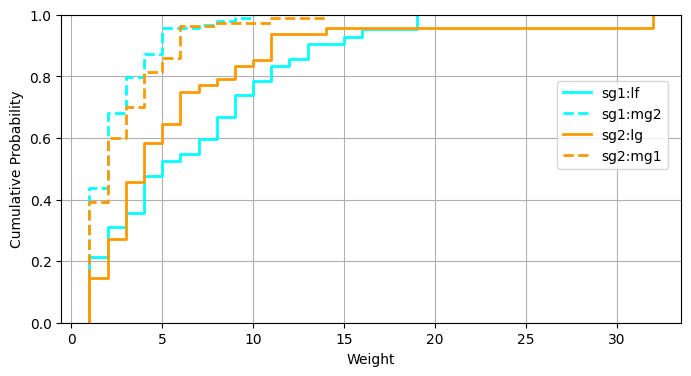

In [228]:
unique_connections = df_edges.groupby(['pre_type', 'post_type'])

hfig,ax = plt.subplots(1,figsize=(8, 4))
# hfig.set_title(f'Cumulative Distribution Plot for {pre_type}:{post_type} Connection')
for (pre_type, post_type), group_df in unique_connections:
    if (pre_type in ['sg1']) & (post_type in ['mg2']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2, linestyle='--')
    if (pre_type in ['sg2']) & (post_type in ['mg1']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2, linestyle='--')
    if (pre_type in ['sg1']) & (post_type in ['lf']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2)
    if (pre_type in ['sg2']) & (post_type in ['lg']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2)
    
ax.set_xlabel('Weight')
ax.set_ylabel('Cumulative Probability')
plt.legend(loc=(0.8,0.5))
plt.grid(True)
plt.show()

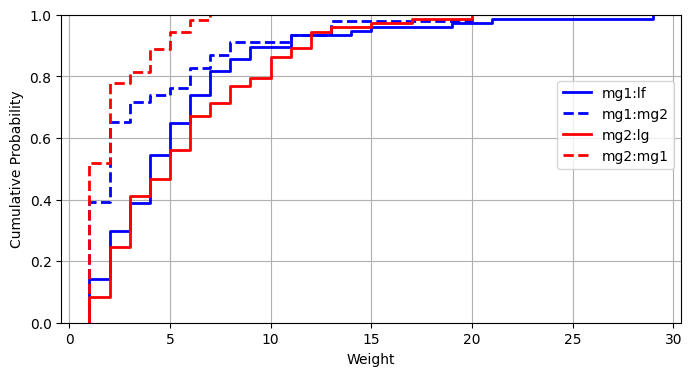

In [229]:
unique_connections = df_edges.groupby(['pre_type', 'post_type'])

hfig,ax = plt.subplots(1,figsize=(8, 4))
# hfig.set_title(f'Cumulative Distribution Plot for {pre_type}:{post_type} Connection')
for (pre_type, post_type), group_df in unique_connections:
    if (pre_type in ['mg1']) & (post_type in ['mg2']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2, linestyle='--')
    if (pre_type in ['mg2']) & (post_type in ['mg1']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2, linestyle='--')
    if (pre_type in ['mg1']) & (post_type in ['lf']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2)
    if (pre_type in ['mg2']) & (post_type in ['lg']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2)
    
ax.set_xlabel('Weight')
ax.set_ylabel('Cumulative Probability')
plt.legend(loc=(0.8,0.5))
plt.grid(True)
plt.show()

# Distribution of weights by type

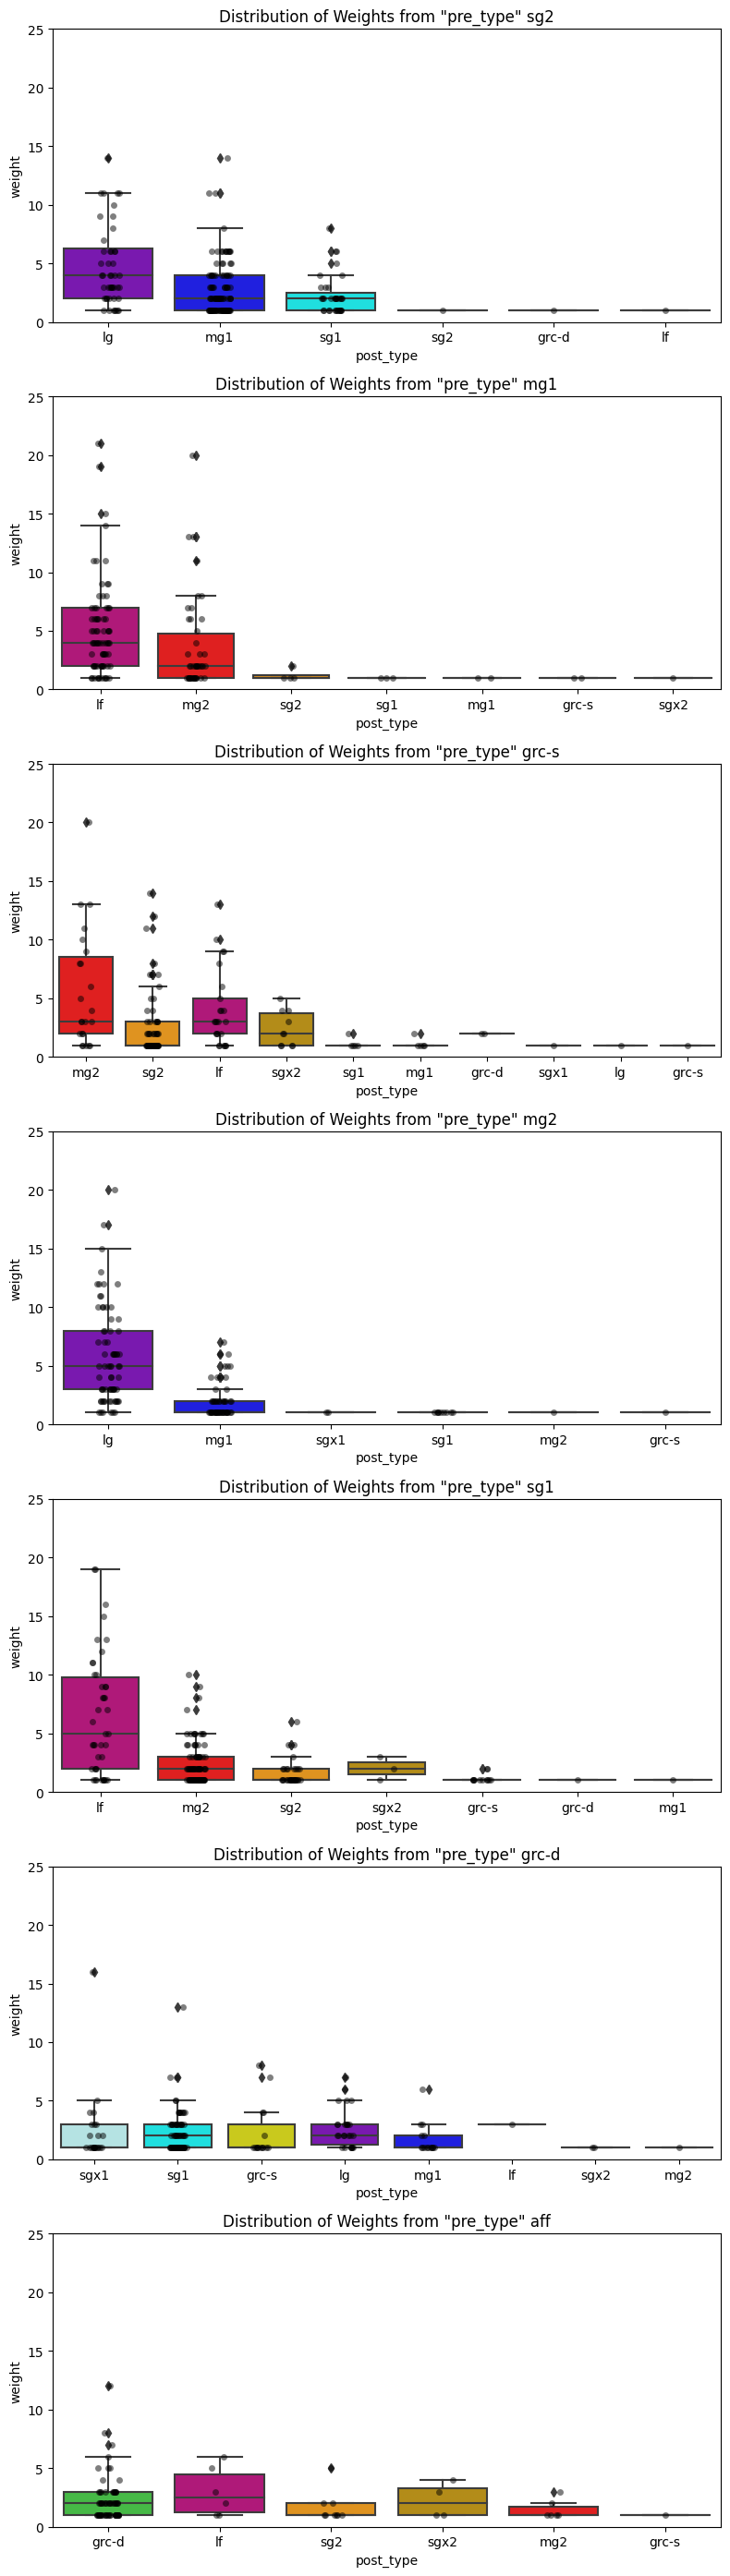

In [1833]:
# df= df_edges[(df_edges['pre_type'].isin(['sg1','sg2','mg1','mg2'])) & (df_edges['post_type'].isin(['mg1','mg2','lf','lg']))]

fig, axes = plt.subplots(len(df_edges['pre_type'].unique()), 1, figsize=(8, 4 * len(df_edges['pre_type'].unique())))

for i,p in enumerate(df_edges['pre_type'].unique()):

    sns.boxplot(data=df_edges[df_edges['pre_type'] == p], x='post_type', y='weight', ax=axes[i],palette=syn_colors)#, inner='quartile', palette='Set2')
    sns.stripplot(data=df_edges[df_edges['pre_type'] == p], x='post_type', y='weight', ax=axes[i],color='black',alpha=0.5)
    axes[i].set_title(f'Distribution of Weights from "pre_type" {p}')
    axes[i].set_ylim(0,25)

plt.tight_layout()
plt.show()